In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


# Clone github repo

In [1]:
# Clone the entire repo.
!git clone https://github.com/Tuan-Lee-23/Vietnamese-Reactionary-Article-Classification-.git
%cd Vietnamese-Reactionary-Article-Classification-/
!ls

Cloning into 'Vietnamese-Reactionary-Article-Classification-'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 185 (delta 4), reused 25 (delta 3), pack-reused 154
Receiving objects: 100% (185/185), 125.12 MiB | 20.41 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Checking out files: 100% (57/57), done.
/content/Vietnamese-Reactionary-Article-Classification-
analysis  data	demo  modeling	README.md


# Import Libs

In [2]:
import re
import seaborn as sns
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pickle
import plotly.express as px
import plotly.figure_factory as ff

tqdm.pandas()

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



# Import data from GDRIVE

In [3]:
%cd data/datasets/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data/datasets
0  1  README.md


In [4]:
dataset_1 = os.listdir(os.getcwd() + '/1/')
dataset_0 = os.listdir(os.getcwd() + '/0/')

dataset_1 =  sorted(dataset_1, reverse= True)

print(dataset_1)
print(dataset_0)


['viettan_quandiem.csv', 'viettan_org_4.csv', 'viettan_org_3.csv', 'viettan_org_2.csv', 'viettan_org.csv', 'viettan_hoatdong.csv', 'viettan_fb.csv', 'viettan_diendan_3.csv', 'viettan_diendan_2.csv', 'viettan_diendan_1.csv', 'thanhnienconggiao.csv', 'sbtn.csv', 'rfa.csv', 'khoi8406.csv', 'haudue_vnch.csv', 'chantroimoi_media.csv', 'bpsos.csv', 'PhamMinhVuFBd.csv', 'KhoaLuatTapChi_XaHoi.csv', 'KhoaLuatTapChi_VNCH.csv', 'KhoaLuatTapChi_ChinhTri.csv', 'GiaoChucChuVanAn.csv']
['vnexpress_thoisu_2.csv', 'tinnoichinh.csv', 'vnexpress_kinhdoanh.csv', 'qdnd_dienbienhoabinh.csv', 'vnexpress_phapluat.csv', 'vnexpress_thoisu_1.csv', 'qdnd_chinhtri.csv']


# Preprocessing

- [x]  Open csv
- [x]  Drop missing values
- [x]  Assign label for dataframe base on class
- [x]  Clean html
- [x]  Normalize unicode
- [x]  Remove long - short articles (len_limit)
- [x]  Remove hyperlinks
- [x]  Plot len distribution (3 type - pdf, ecdf, rug plot)
- [x]  Keep number, special character, punctuation since BERT can handle all of them
- [x]  Save as pickle (name)
- [x]  Read pickle (name)
- Keep number, special character, punctuation since BERT can handle them

In [6]:
class Dataframe:
    
    def __init__(self):
        self.directory = ''
        self.name = ''

        self.df = []
        self.label = 0


    def __init__(self, directory, label):
        self.name = directory
        self.directory = directory
        self.label = label
        self.df = []

    # read csv file and add label column
    def read_csv(self):
        df = pd.read_csv(os.getcwd() + self.directory)
        print("df: ", df)
        df = df.drop(['Unnamed: 0'], axis = 1)
        if 'blue' in df.columns:
            df.rename(columns = {'blue': 'content'}, inplace = True)
        
        if self.label:
            df['label'] = np.ones((df.shape)).astype('int')
        else:
            df['label'] = np.zeros((df.shape)).astype('int')
        df['label'].astype('category')
        df = df.dropna()
        df['avg_length'] = df['content'].apply(len)

        self.df = df
        

    def plot(self): #df
        plt.style.use('ggplot')
        plt.figure(figsize = (15, 10))

        sns.rugplot(self.df['avg_length'])
        plt.show()

        px.histogram(self.df['avg_length'])
        plt.show()

        sns.kdeplot(self.df['avg_length'])
        plt.show()

        sns.ecdfplot(self.df['avg_length'])
        plt.show()

        fig = ff.create_distplot([self.df['avg_length']], [''])
        fig.update_layout(title='Dist Plot')
        fig.show()



    def preprocess(self):
        def clean_html(raw_html): #text
            cleanr = re.compile('<.*?>')
            cleantext = re.sub(cleanr, '', raw_html)
            return cleantext

         # Normalize unicode
        def normalize_unicode(txt): # text
            def loaddicchar():
                dic = {}
                char1252 = 'aÃÄ|aÃÅ|aÃâ|aÃÉ|aÃ£|√¢ÃÄ|√¢ÃÅ|√¢Ãâ|√¢ÃÉ|√¢Ã£|ƒÉÃÄ|ƒÉÃÅ|ƒÉÃâ|ƒÉÃÉ|ƒÉÃ£|eÃÄ|eÃÅ|eÃâ|eÃÉ|eÃ£|√™ÃÄ|√™ÃÅ|√™Ãâ|√™ÃÉ|√™Ã£|iÃÄ|iÃÅ|iÃâ|iÃÉ|iÃ£|oÃÄ|oÃÅ|oÃâ|oÃÉ|oÃ£|√¥ÃÄ|√¥ÃÅ|√¥Ãâ|√¥ÃÉ|√¥Ã£|∆°ÃÄ|∆°ÃÅ|∆°Ãâ|∆°ÃÉ|∆°Ã£|uÃÄ|uÃÅ|uÃâ|uÃÉ|uÃ£|∆∞ÃÄ|∆∞ÃÅ|∆∞Ãâ|∆∞ÃÉ|∆∞Ã£|yÃÄ|yÃÅ|yÃâ|yÃÉ|yÃ£|AÃÄ|AÃÅ|AÃâ|AÃÉ|AÃ£|√ÇÃÄ|√ÇÃÅ|√ÇÃâ|√ÇÃÉ|√ÇÃ£|ƒÇÃÄ|ƒÇÃÅ|ƒÇÃâ|ƒÇÃÉ|ƒÇÃ£|EÃÄ|EÃÅ|EÃâ|EÃÉ|EÃ£|√äÃÄ|√äÃÅ|√äÃâ|√äÃÉ|√äÃ£|IÃÄ|IÃÅ|IÃâ|IÃÉ|IÃ£|OÃÄ|OÃÅ|OÃâ|OÃÉ|OÃ£|√îÃÄ|√îÃÅ|√îÃâ|√îÃÉ|√îÃ£|∆†ÃÄ|∆†ÃÅ|∆†Ãâ|∆†ÃÉ|∆†Ã£|UÃÄ|UÃÅ|UÃâ|UÃÉ|UÃ£|∆ØÃÄ|∆ØÃÅ|∆ØÃâ|∆ØÃÉ|∆ØÃ£|YÃÄ|YÃÅ|YÃâ|YÃÉ|YÃ£'.split(
                    '|')
                charutf8 = "√†|√°|·∫£|√£|·∫°|·∫ß|·∫•|·∫©|·∫´|·∫≠|·∫±|·∫Ø|·∫≥|·∫µ|·∫∑|√®|√©|·∫ª|·∫Ω|·∫π|·ªÅ|·∫ø|·ªÉ|·ªÖ|·ªá|√¨|√≠|·ªâ|ƒ©|·ªã|√≤|√≥|·ªè|√µ|·ªç|·ªì|·ªë|·ªï|·ªó|·ªô|·ªù|·ªõ|·ªü|·ª°|·ª£|√π|√∫|·ªß|≈©|·ª•|·ª´|·ª©|·ª≠|·ªØ|·ª±|·ª≥|√Ω|·ª∑|·ªπ|·ªµ|√Ä|√Å|·∫¢|√É|·∫†|·∫¶|·∫§|·∫®|·∫™|·∫¨|·∫∞|·∫Æ|·∫≤|·∫¥|·∫∂|√à|√â|·∫∫|·∫º|·∫∏|·ªÄ|·∫æ|·ªÇ|·ªÑ|·ªÜ|√å|√ç|·ªà|ƒ®|·ªä|√í|√ì|·ªé|√ï|·ªå|·ªí|·ªê|·ªî|·ªñ|·ªò|·ªú|·ªö|·ªû|·ª†|·ª¢|√ô|√ö|·ª¶|≈®|·ª§|·ª™|·ª®|·ª¨|·ªÆ|·ª∞|·ª≤|√ù|·ª∂|·ª∏|·ª¥".split(
                    '|')
                for i in range(len(char1252)):
                    dic[char1252[i]] = charutf8[i]
                return dic

            def convert_unicode(txt):
                dicchar = loaddicchar()
                return re.sub(
                    r'aÃÄ|aÃÅ|aÃâ|aÃÉ|aÃ£|√¢ÃÄ|√¢ÃÅ|√¢Ãâ|√¢ÃÉ|√¢Ã£|ƒÉÃÄ|ƒÉÃÅ|ƒÉÃâ|ƒÉÃÉ|ƒÉÃ£|eÃÄ|eÃÅ|eÃâ|eÃÉ|eÃ£|√™ÃÄ|√™ÃÅ|√™Ãâ|√™ÃÉ|√™Ã£|iÃÄ|iÃÅ|iÃâ|iÃÉ|iÃ£|oÃÄ|oÃÅ|oÃâ|oÃÉ|oÃ£|√¥ÃÄ|√¥ÃÅ|√¥Ãâ|√¥ÃÉ|√¥Ã£|∆°ÃÄ|∆°ÃÅ|∆°Ãâ|∆°ÃÉ|∆°Ã£|uÃÄ|uÃÅ|uÃâ|uÃÉ|uÃ£|∆∞ÃÄ|∆∞ÃÅ|∆∞Ãâ|∆∞ÃÉ|∆∞Ã£|yÃÄ|yÃÅ|yÃâ|yÃÉ|yÃ£|AÃÄ|AÃÅ|AÃâ|AÃÉ|AÃ£|√ÇÃÄ|√ÇÃÅ|√ÇÃâ|√ÇÃÉ|√ÇÃ£|ƒÇÃÄ|ƒÇÃÅ|ƒÇÃâ|ƒÇÃÉ|ƒÇÃ£|EÃÄ|EÃÅ|EÃâ|EÃÉ|EÃ£|√äÃÄ|√äÃÅ|√äÃâ|√äÃÉ|√äÃ£|IÃÄ|IÃÅ|IÃâ|IÃÉ|IÃ£|OÃÄ|OÃÅ|OÃâ|OÃÉ|OÃ£|√îÃÄ|√îÃÅ|√îÃâ|√îÃÉ|√îÃ£|∆†ÃÄ|∆†ÃÅ|∆†Ãâ|∆†ÃÉ|∆†Ã£|UÃÄ|UÃÅ|UÃâ|UÃÉ|UÃ£|∆ØÃÄ|∆ØÃÅ|∆ØÃâ|∆ØÃÉ|∆ØÃ£|YÃÄ|YÃÅ|YÃâ|YÃÉ|YÃ£',
                    lambda x: dicchar[x.group()], txt)
            return convert_unicode(txt)
                
         # Remove short articles
        def remove_short(limit): #df
            self.df = self.df[self.df['avg_length'] > limit]

        # Remove long articles
        def remove_long(limit): #df
            self.df = self.df[self.df['avg_length'] < limit]

        # Remove hyperlinks in text
        def remove_urls(input_text): #text
            return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

        # Normalize Vietnamese
        # def normalize_vietnamese():
            # self.df['content'] = self.df['content'].progress_apply(lambda x: TTSnorm(x, lower = False, punc = True))



        self.df['content'] = self.df['content'].apply(clean_html)
        self.df['content'] = self.df['content'].apply(normalize_unicode)
        self.df['content'] = self.df['content'].apply(remove_urls)

        limit = input('Enter < limit:')
        limit = int(limit)

        remove_short(limit)

        limit = input('Enter > limit:')
        limit = int(limit)

        remove_long(limit)
        # normalize_vietnamese()

        

    # Save dataframe to pickle file
    def save_preprocess(self, name):
        self.df.to_csv(name + '.csv')
 
    
def read_preprocess(name):
    temp = pd.read_pickle(name)
    return temp

# Perform on datasets

## Viettan

### Define new instances

In [7]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [8]:
viettan_ls = []

for i in [0, 1, 2, 3, 4, 5, 7, 8, 9]:
    test = Dataframe('/1/' + dataset_1[i], 1)
    print(test.name)
    test.read_csv()
    viettan_ls.append(test.df)

viettan= Dataframe('', 1)
viettan.df = pd.concat(viettan_ls)
df = viettan.df

print(df.shape)

/1/viettan_quandiem.csv
df:       Unnamed: 0                                            content
0             0  Vi·ªát Nam c√≥ n√™n ti·∫øp t·ª•c ‚Äúch·ªëng d·ªãch nh∆∞ ch·ªëng...
1             1  Nguy·ªÖn Ph√∫ Tr·ªçng v√† con ƒë∆∞·ªùng ti·∫øn l√™n x√£ h·ªôi ...
2             2  Ng√†y 30 th√°ng 4\nTh·∫•m tho√°t bi·∫øn c·ªë 30 th√°ng 4...
3             3  Myanmar ƒë·ª©ng tr∆∞·ªõc nguy c∆° n·ªôi chi·∫øn\nCu·ªôc ƒë·∫£o...
4             4  Vai tr√≤ ‚Äútrung t√¢m‚Äù c·ªßa Nh·∫≠t B·∫£n trong chi·∫øn l...
..          ...                                                ...
351         351  NƒÉm M·ªõi ‚Äî Tinh Th·∫ßn M·ªõi ‚Äî N·ªó L·ª±c M·ªõi\nCh√∫ng ta...
352         352  Th√°i ƒê·ªô C·ªßa Ch√∫ng Ta Tr∆∞·ªõc Th·∫£m K·ªãch Ng∆∞ D√¢n V...
353         353  Ph√° V·ª° B·ª©c T∆∞·ªùng NgƒÉn C√°ch\nTh√°ng 11 v·ª´a qua, ...
354         354  Th·∫ø Li√™n Minh D√¢n T·ªôc H√¥m Nay\nLi√™n minh d√¢n t...
355         355  ƒê·ªÉ X√¢y D·ª±ng N·ªÅn Gi√°o D·ª•c Vi·ªát Nam Hi·ªán ƒê·∫°i\nI-...

[356 rows x 2 colum

### Content Filter

In [9]:
temp = df[df['content'].str.contains("CS|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|c√¥ng an|" + 
        "quan ch·ª©c|c∆∞·ªõp|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|ch√≠nh tr·ªã|ch√≠nh quy·ªÅn|XHCN", regex = True, flags=re.IGNORECASE)]

print(viettan.name)
viettan.df = temp
df = viettan.df

viettan.df

content  label  avg_length
0     Vi·ªát Nam c√≥ n√™n ti·∫øp t·ª•c ‚Äúch·ªëng d·ªãch nh∆∞ ch·ªëng...      1        9109
1     Nguy·ªÖn Ph√∫ Tr·ªçng v√† con ƒë∆∞·ªùng ti·∫øn l√™n x√£ h·ªôi ...      1        5084
2     Ng√†y 30 th√°ng 4\nTh·∫•m tho√°t bi·∫øn c·ªë 30 th√°ng 4...      1        4186
3     Myanmar ƒë·ª©ng tr∆∞·ªõc nguy c∆° n·ªôi chi·∫øn\nCu·ªôc ƒë·∫£o...      1       11835
4     Vai tr√≤ ‚Äútrung t√¢m‚Äù c·ªßa Nh·∫≠t B·∫£n trong chi·∫øn l...      1        5762
...                                                 ...    ...         ...
1245  H√†ng ch·ª•c ng∆∞·ªùi tham gia ƒë·ªìng h√†nh tuy·ªát th·ª±c ...      1        4886
1246  Tr·∫ßn Hu·ª≥nh Duy Th·ª©c ‚ÄúL·ª≠a Vi·ªát Ch√°y Trong T√π‚Äù\n...      1        4473
1247  Qu·ªëc kh√°nh‚Ä¶ cu·ªëi c√πng?\n73 nƒÉm ‚Äúƒê√¥Ã£c L√¢Ã£p ‚Äì T∆∞...      1       11363
1248  ‚ÄòS√°p nh·∫≠p ti·ªÅn t·ªá‚Äô ƒë·ªÉ ti·∫øn t·ªõi ‚Äòs√°p nh·∫≠p l√£nh ...      1        7291
1249  D·ªãp 2/9: Bi·ªÉu t√¨nh: kh√¥ng; b·∫Øt b·ªõ, ƒë√†n √°p: m·∫°n...      1        7470

[7250 rows x 3 columns]

In [10]:
df = viettan.df

df[df['content'].duplicated()]

content  label  avg_length
12   Vi·ªát Nam c√≥ n√™n ti·∫øp t·ª•c ‚Äúch·ªëng d·ªãch nh∆∞ ch·ªëng...      1        9109
13   Nguy·ªÖn Ph√∫ Tr·ªçng v√† con ƒë∆∞·ªùng ti·∫øn l√™n x√£ h·ªôi ...      1        5084
14   Ng√†y 30 th√°ng 4\nTh·∫•m tho√°t bi·∫øn c·ªë 30 th√°ng 4...      1        4186
15   Myanmar ƒë·ª©ng tr∆∞·ªõc nguy c∆° n·ªôi chi·∫øn\nCu·ªôc ƒë·∫£o...      1       11835
16   Vai tr√≤ ‚Äútrung t√¢m‚Äù c·ªßa Nh·∫≠t B·∫£n trong chi·∫øn l...      1        5762
..                                                 ...    ...         ...
332  B·ªô Tr∆∞·ªüng Ngo·∫°i Giao √öc tr·∫£ l·ªùi D√¢n Bi·ªÉu Chris...      1        2346
554  Ph·ªèng v·∫•n K·ªπ S∆∞ ƒê·ªó Ho√†ng ƒêi·ªÅm, Ch·ªß T·ªãch ƒê·∫£ng V...      1        8427
555  Ch·ªß t·ªãch ƒê·∫£ng Vi·ªát T√¢n: ‚ÄòPh·∫£i ph√° b·ªè ƒë·ªôc t√†i C...      1        7550
580  C·ªông ƒê·ªìng √öc th√¥ng b√°o chi·∫øn d·ªãch v·∫≠n ƒë·ªông t·ª± ...      1        3662
592  √îng Ch√¢u VƒÉn Kh·∫£m c√≥ ph·∫°m t·ªôi kh·ªßng b·ªë kh√¥ng?\...      1        8364

[405 rows x 3 columns]

### Plot distribution

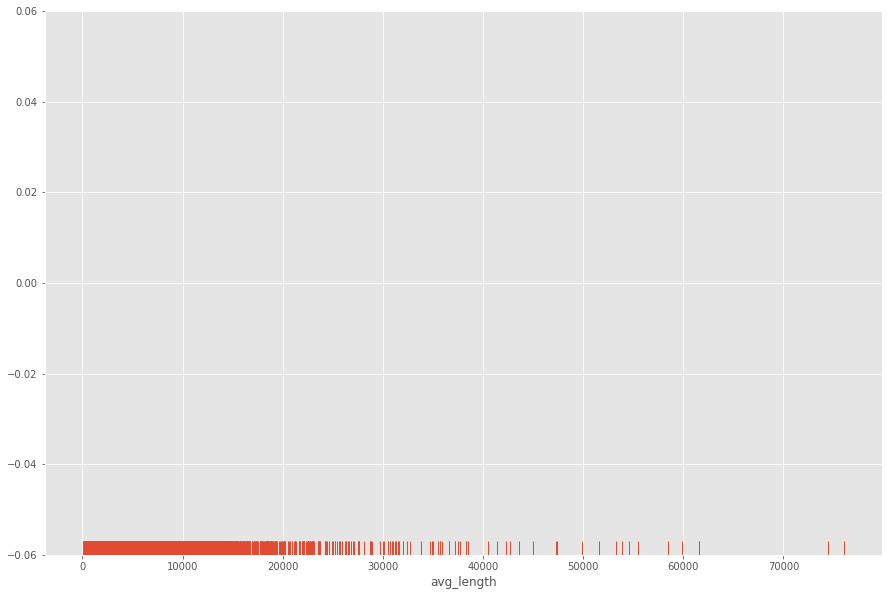

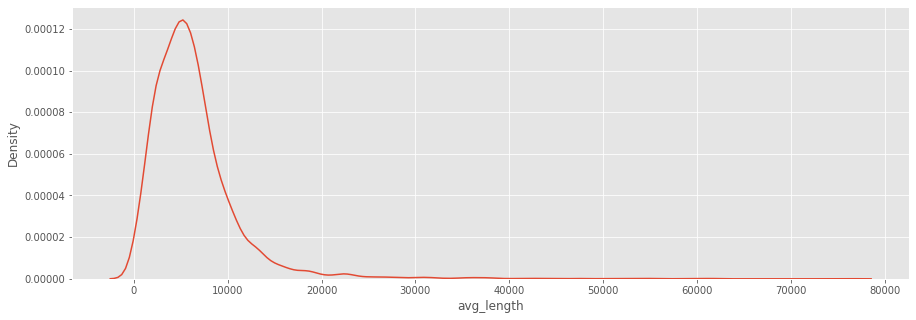

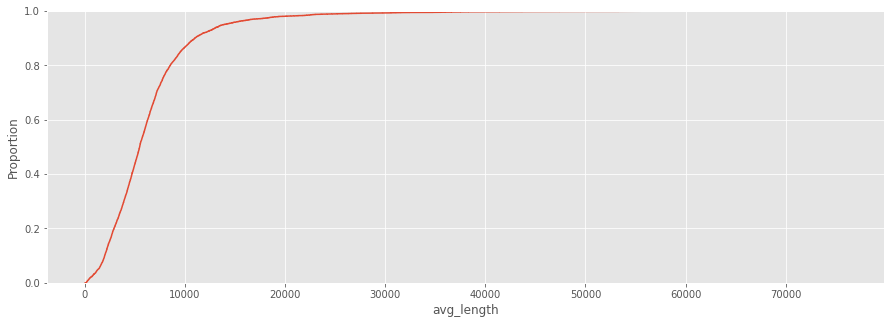

In [11]:
viettan.plot()

### Observations

In [12]:
limit = 750

In [13]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[-3])

116     G√≥c Nh√¨n Vi·ªát T√¢n: Vi·ªÖn c·∫£nh Vi·ªát Nam 2018\nKa...
208     √îng L√Ω Th√°i H√πng nh·∫≠n ƒë·ªãnh v·ªÅ l√£nh ƒë·∫°o m·ªõi c·ªßa...
55      C·∫•p b√°o c·ªßa To√† gi√°o m·ª•c X√£ ƒêo√†i\nC·∫§P B√ÅO\n20....
186     Bi·ªÉu T√¨nh Ph·∫£n ƒê·ªëi R∆∞·ªõc ƒêu·ªëc Th·∫ø V·∫≠n H·ªôi B·∫Øc K...
41      Bi·ªÉu t√¨nh ng√†y 19/6/2011 t·∫°i S√†i G√≤n v√† H√† N·ªôi...
                              ...                        
1389    ·ª¶y Ban C√¥ng L√Ω ‚Äì H√≤a B√¨nh VN hi·ªáp th√¥ng c√πng G...
1393    M·ª´ng Ph∆∞∆°ng Uy√™n‚Ä¶ nh·ªõ Minh H·∫°nh\nSau khi sinh ...
1396    ƒê·ªìng ƒë·ªôi m·ª´ng sinh nh·∫≠t Ls. L√™ Qu·ªëc Qu√¢n\nSau ...
1432    Phim m·ªõi ƒëang b·ªã c·∫•m: Truy·ªÅn ƒê∆°n K·ª≥ √Ån\nH√£ng p...
532     V√≤ng hoa ‚Äúm·ªì c√¥i‚Äù\nV√≤ng hoa c·ªßa trang Bauxite ...
Name: content, Length: 181, dtype: object
--------------------



ƒê·ªìng ƒë·ªôi m·ª´ng sinh nh·∫≠t Ls. L√™ Qu·ªëc Qu√¢n
Sau ƒë√¢y l√† t√¢m t√¨nh c·ªßa m·ªôt s·ªë nh√† d√¢n ch·ªß g·ªüi Ls. L√™ Qu·ªëc Qu√¢n nh√¢n ng√†y si

In [14]:
limit = 48000

In [15]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

196     220 S·ª± Ki·ªán N·ªïi B·∫≠t C·ªßa Phong Tr√†o Tranh ƒê·∫•u D...
252     T√†i li·ªáu t·ªë gi√°c Nguy·ªÖn Ch√≠ V·ªãnh\nL·ªùi gi·ªõi thi...
396     Kh√¥ng ai ƒëo√°n ƒë∆∞·ª£c hi·ªáu ·ª©ng Domino nƒÉm 1989*\n...
2137    ƒê·ªçc t·∫≠p s√°ch ‚ÄúCh·∫øt B·ªüi Trung Qu·ªëc‚Äù c·ªßa t√°c gi·∫£...
217     Lu·∫≠t Hi·∫øn ph√°p v√† Ch√≠nh tr·ªã h·ªçc (2)\nCh∆∞∆°ng m·ªü...
959     Nh·ªØng b·∫•t l·ª£i l·ªõn trong c√°c d·ª± √°n khai th√°c b√¥...
1067    B√†i B√™nh V·ª±c Lu·∫≠t S∆∞ Nguy·ªÖn VƒÉn ƒê√†i Nh√¢n Phi√™n...
1145    Cu·ªôc C√°ch M·∫°ng D√¢n Ch·ªß T·∫°i Ba Lan\nNh√¢n k·ª∑ ni·ªá...
1151    Vi·ªát Nam: B∆∞·ªõc Ra Th·∫ø Gi·ªõi C·∫°nh Tranh\nB√†i vi·∫ø...
1143    L·∫°i n√≥i v·ªÅ ƒë·ªìng minh\nVi·ªác gi√†n khoan Haiyang ...
1407    Lu·∫≠t Hi·∫øn ph√°p v√† Ch√≠nh tr·ªã h·ªçc (2)\nCh∆∞∆°ng m·ªü...
424     √în l·∫°i m·ªôt s·ªë ƒë·∫∑c ƒëi·ªÉm trong l·ªãch s·ª≠ t·ªã n·∫°n Vi...
Name: content, dtype: object
--------------------



220 S·ª± Ki·ªán N·ªïi B·∫≠t C·ªßa Phong Tr√†o Tranh ƒê·∫•u D√¢n Ch·ªß 

### Run Preprocessing method

In [16]:
# 750 - 48000
# ...
viettan.preprocess()

Enter < limit:750
Enter > limit:48000


### Save

In [17]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	   viettan_fb.pickle
chantroimoi.pickle	 rfa.pickle		   viettan.pickle
giaochucchuvanan.pickle  sbtn.pickle
khoi8406.pickle		 thanhnienconggiao.pickle


In [18]:
viettan.save_preprocess(os.getcwd() + "/viettan")

In [19]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Viettan FB

### Define new instances

In [20]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

viettan_fb = Dataframe('/1/' + 'viettan_fb.csv', 1)
print(viettan_fb.name)
viettan_fb.read_csv()

df = viettan_fb.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/viettan_fb.csv
df:        Unnamed: 0                                            content
0              0  B·ªô m√°y tuy√™n gi√°o CSVN lu√¥n tuy√™n truy·ªÅn v·ªÅ va...
1              1  B·∫ÆC KINH B·ªä C√ÅO BU·ªòC DI·ªÜT CH·ª¶NG NG∆Ø·ªúI NG√î DUY ...
2              2  S·ª± b·∫•t c√¥ng c·ªßa ng√†nh c√¥ng an ƒëang ƒë∆∞·ª£c b·ªôc l·ªô...
3              3  5 NG∆Ø·ªúI B·ªä B·∫ÆT V√å ƒê∆ØA 200 NG∆Ø·ªúI TRUNG QU·ªêC XU·∫§...
4              4  B·∫¶U C·ª¨ NH∆Ø VI·ªÜC N·∫§U ƒÇN\nLs Lu√¢n L√™\n\nKhi s·ª± s...
...          ...                                                ...
1669        1669  NGHI NG·ªú D√ÇN, S·ª¢ D√ÇN, ƒêCSVN DI·ªÑN T·∫¨P CH·ªêNG D√ÇN...
1670        1670  An Ninh ƒêi·ªán T·ª≠ - B·∫£o M·∫≠t S·ªë\n\nWHATSAPP TH√ÇU ...
1671        1671  √ù CH√ç S·∫ÆT ƒê√Å V√Ä HI·∫æU H·ªåC ƒê√É BI·∫æN NG∆Ø·ªúI T√ô TH√ÄN...
1672        1672  VIEÃÇÃÅT VEÃÇÃÄ NGUÃõOÃõÃÄI OÃÇNG ƒêAÃÅNG KIÃÅNH COÃÅ TEÃÇN...
1673        1673  VI·ªÜT NAM C·∫¶N TH·∫®M PH√ÅN SU·ªêT ƒê·ªúI?\n\nS√°ng, ch·ª£t...

[1674 rows 

content  label  avg_length
0     B·ªô m√°y tuy√™n gi√°o CSVN lu√¥n tuy√™n truy·ªÅn v·ªÅ va...      1         576
1     B·∫ÆC KINH B·ªä C√ÅO BU·ªòC DI·ªÜT CH·ª¶NG NG∆Ø·ªúI NG√î DUY ...      1         701
2     S·ª± b·∫•t c√¥ng c·ªßa ng√†nh c√¥ng an ƒëang ƒë∆∞·ª£c b·ªôc l·ªô...      1         335
3     5 NG∆Ø·ªúI B·ªä B·∫ÆT V√å ƒê∆ØA 200 NG∆Ø·ªúI TRUNG QU·ªêC XU·∫§...      1         703
4     B·∫¶U C·ª¨ NH∆Ø VI·ªÜC N·∫§U ƒÇN\nLs Lu√¢n L√™\n\nKhi s·ª± s...      1         706
...                                                 ...    ...         ...
1669  NGHI NG·ªú D√ÇN, S·ª¢ D√ÇN, ƒêCSVN DI·ªÑN T·∫¨P CH·ªêNG D√ÇN...      1         702
1670  An Ninh ƒêi·ªán T·ª≠ - B·∫£o M·∫≠t S·ªë\n\nWHATSAPP TH√ÇU ...      1         693
1671  √ù CH√ç S·∫ÆT ƒê√Å V√Ä HI·∫æU H·ªåC ƒê√É BI·∫æN NG∆Ø·ªúI T√ô TH√ÄN...      1         705
1672  VIEÃÇÃÅT VEÃÇÃÄ NGUÃõOÃõÃÄI OÃÇNG ƒêAÃÅNG KIÃÅNH COÃÅ TEÃÇN...      1         697
1673  VI·ªÜT NAM C·∫¶N TH·∫®M PH√ÅN SU·ªêT ƒê·ªúI?\n\nS√°ng, ch·ª£t...      1         703

[1673 rows x 3 columns]

### Content Filter

In [21]:
temp = df[df['content'].str.contains("VN|CS|Vi·ªát Nam|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|c·ªông s·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c", regex = True, flags=re.IGNORECASE)]

viettan_fb.df = temp
viettan_fb.df

content  label  avg_length
0     B·ªô m√°y tuy√™n gi√°o CSVN lu√¥n tuy√™n truy·ªÅn v·ªÅ va...      1         576
1     B·∫ÆC KINH B·ªä C√ÅO BU·ªòC DI·ªÜT CH·ª¶NG NG∆Ø·ªúI NG√î DUY ...      1         701
2     S·ª± b·∫•t c√¥ng c·ªßa ng√†nh c√¥ng an ƒëang ƒë∆∞·ª£c b·ªôc l·ªô...      1         335
3     5 NG∆Ø·ªúI B·ªä B·∫ÆT V√å ƒê∆ØA 200 NG∆Ø·ªúI TRUNG QU·ªêC XU·∫§...      1         703
4     B·∫¶U C·ª¨ NH∆Ø VI·ªÜC N·∫§U ƒÇN\nLs Lu√¢n L√™\n\nKhi s·ª± s...      1         706
...                                                 ...    ...         ...
1668  ƒê·ªíNG T√ÇM ‚Äì M·ªòT T·∫§M BIA GHI L·∫†I T·ªòI √ÅC CS TH·ªúI ...      1         701
1669  NGHI NG·ªú D√ÇN, S·ª¢ D√ÇN, ƒêCSVN DI·ªÑN T·∫¨P CH·ªêNG D√ÇN...      1         702
1671  √ù CH√ç S·∫ÆT ƒê√Å V√Ä HI·∫æU H·ªåC ƒê√É BI·∫æN NG∆Ø·ªúI T√ô TH√ÄN...      1         705
1672  VIEÃÇÃÅT VEÃÇÃÄ NGUÃõOÃõÃÄI OÃÇNG ƒêAÃÅNG KIÃÅNH COÃÅ TEÃÇN...      1         697
1673  VI·ªÜT NAM C·∫¶N TH·∫®M PH√ÅN SU·ªêT ƒê·ªúI?\n\nS√°ng, ch·ª£t...      1         703

[1351 rows x 3 columns]

### Plot distribution

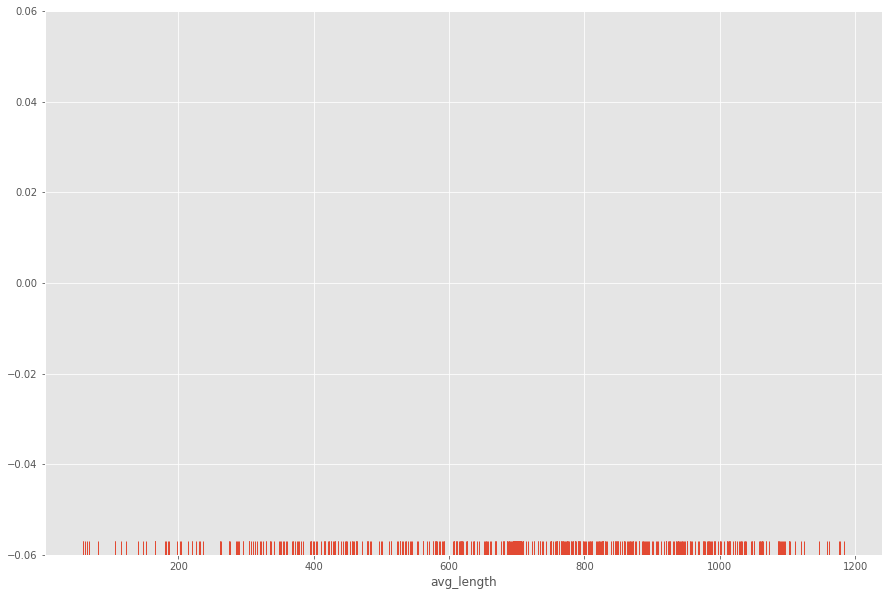

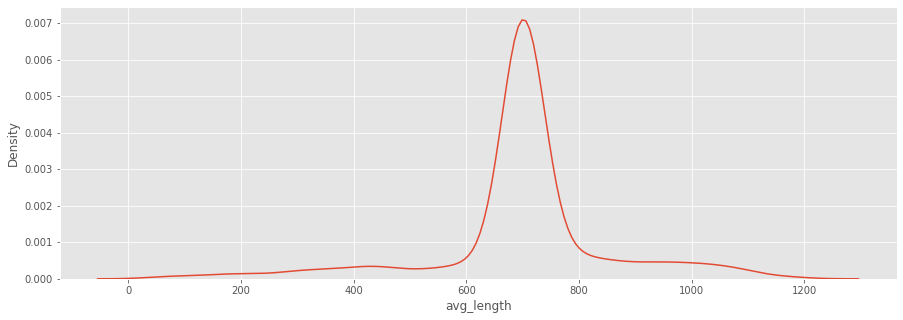

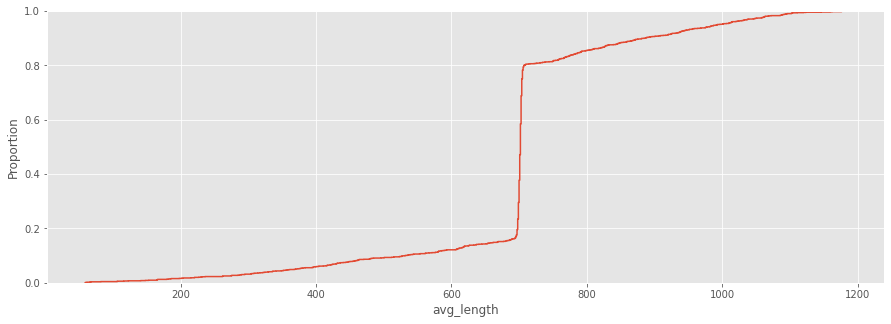

In [22]:
viettan_fb.plot()

### Observations

In [23]:
limit = 350

In [24]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[3])

2       S·ª± b·∫•t c√¥ng c·ªßa ng√†nh c√¥ng an ƒëang ƒë∆∞·ª£c b·ªôc l·ªô...
14      S·ª± kh√°c bi·ªát gi·ªØa c√¥ng an tr√™n tivi v√† c√¥ng an...
19      B·∫°n nghƒ© g√¨ v√® c√°ch th·ª©c tuy√™n truy·ªÅn nay?\n\n...
30      Kh√¥ng c·∫ßn ph·∫£i ƒë·∫ßu t∆∞ trang ph·ª•c k·ª≥ c√¥ng, v∆∞·ª£t...
36      C√ì NH·ªÆNG HI SINH TH·∫¶M L·∫∂NG, T√î ƒê·∫∏P CHO ƒê·ªúI ‚ù§\n...
                              ...                        
1595    DANH CA L·ªÜ THU ƒê√É RA ƒêI V√å COVID-19\n\nN·ªØ danh...
1601    Hai Ti·∫øn sƒ© c·ªßa n∆∞·ªõc CHXHCN Vi·ªát Nam chuy√™n bu...
1635    T·ªêN BAO NHI√äU TI·ªÄN CHO CHI·∫æC XE M√Ä C√ÅC ƒê·ªíNG CH...
1657    √îng T√¥ L√¢m l√†m B·ªô tr∆∞·ªüng B·ªô C√¥ng an kh√¥ng lo t...
1662    Tr√≤n m·ªôt nƒÉm tang t√≥c cho d√¢n l√†ng ƒê·ªìng T√¢m n√≥...
Name: content, Length: 113, dtype: object
--------------------



Kh√¥ng c·∫ßn ph·∫£i ƒë·∫ßu t∆∞ trang ph·ª•c k·ª≥ c√¥ng, v∆∞·ª£t qua 73 ƒë·ªëi th·ªß, Thuzar Wint Lwin ƒë√£ ch√≠nh th·ª©c th·∫Øng gi·∫£i "Trang ph·ª•c d√¢n t·ªôc", ch·ª

In [25]:
limit = 1120

In [26]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

13      T·∫†I SAO ƒêCSVN NH·∫§T ƒê·ªäNH PH·∫¢I B·∫ÆT D√ÇN ƒêI B·ªé PHI...
279     ·∫¢NH H∆Ø·ªûNG GIA TƒÇNG C·ª¶A QU√ÇN ƒê·ªòI TRONG CH√çNH TR...
570     PH·∫†M MINH CH√çNH THAM V·ªåNG GH·∫æ T·ªîNG B√ç TH∆Ø C·ª¶A ...
939     TI·∫æT L·ªò DANH S√ÅCH D·ª∞ KI·∫æN NH√ÇN S·ª∞ L√ÉNH ƒê·∫†O C√ÅC...
1418    Trung qu·ªëc ki·ªÉm so√°t ch√≠nh tr·ªã Vi·ªát Nam: Ph·∫°m ...
1556    B·ªô ch√≠nh tr·ªã ph√° v·ª° nhi·ªÅu chu·∫©n t·∫Øc trong s·∫Øp ...
1641    Danh s√°ch "t·ª© tr·ª•" ƒê·∫°i h·ªôi 13: c√¢n b·∫±ng th·∫ø l·ª±...
Name: content, dtype: object
--------------------



T·∫†I SAO ƒêCSVN NH·∫§T ƒê·ªäNH PH·∫¢I B·∫ÆT D√ÇN ƒêI B·ªé PHI·∫æU B·∫¶U C·ª¨ QU·ªêC H·ªòI?

T·∫°i Vi·ªát Nam, ng∆∞·ªùi ta lu√¥n c·∫£m th·∫•y t·ª©c c∆∞·ªùi khi nghƒ© t·ªõi chuy·ªán b·∫ßu c·ª≠. B·∫•t k·ª≥ cu·ªôc b·∫ßu c·ª≠ n√†o, t·ª´ c·∫•p trung ∆∞∆°ng cho ƒë·∫øn c·∫•p ƒë·ªãa ph∆∞∆°ng, h·∫ßu h·∫øt ƒë·ªÅu cho th·∫•y t√≠nh kh√¥i h√†i. B·ªüi d√¢n ch∆∞a b·∫ßu th√¨ ng∆∞·ªùi ta ƒë√£ bi·∫øt √¥ng n√†o l√†m v·ªã tr√≠ n√†o, b√† n√†o ng·ªìi gh·∫

### Run Preprocessing method

In [27]:
# 350 - 50000
# ...
viettan_fb.preprocess()

Enter < limit:350
Enter > limit:50000


### Save

In [28]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	   viettan.csv
chantroimoi.pickle	 rfa.pickle		   viettan_fb.pickle
giaochucchuvanan.pickle  sbtn.pickle		   viettan.pickle
khoi8406.pickle		 thanhnienconggiao.pickle


In [29]:
viettan_fb.save_preprocess(os.getcwd() + "/viettan_fb")

In [30]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Thanh nien cong giao

### Define new instances

In [31]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

thanhniencongiao = Dataframe('/1/' + 'thanhnienconggiao.csv', 1)
print(thanhniencongiao.name)
thanhniencongiao.read_csv()

df = thanhniencongiao.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/thanhnienconggiao.csv
df:        Unnamed: 0                                            content
0              0  ‚ÄúN·∫øu linh h·ªìn thu·ªôc v·ªÅ nh√† n∆∞·ªõc, th√¨ vi·ªác d√¢ng...
1              1  MU·ªêN V√ÄO N∆Ø·ªöC TR·ªúI H√ÉY N√äN NH∆Ø TR·∫∫ NH·ªé\n\nL√≤ng...
2              2  M∆Ø·ªúI CƒÇN B·ªÜNH L√ÄM BƒÇNG HO·∫†I NG∆Ø·ªúI C√îNG GI√ÅO\n(...
3              3  B·∫¢N TIN ƒê·∫∂C BI·ªÜT V·ªÄ N·ªÆ T√ô NH√ÇN L∆Ø∆†NG T√ÇM VI·ªÜT ...
4              4  B·ªô m√°y nh√† n∆∞·ªõc Vi·ªát Nam hi·ªán t·∫°i c√≥ kho·∫£ng 3 ...
...          ...                                                ...
5507        5507  T·∫†I X√É DI·ªÑN M·ª∏ NG√ÄY 30/10, C√îNG AN D√ÄY ƒê·∫∂C ƒê·ªÇ ...
5508        5508  NH·ªÆNG B√ä B·ªêI ·ªû TR·∫†I GIAM NGHƒ®A AN - QU·∫¢NG TR·ªä ...
5509        5509  B·∫∞NG CH·ª®NG C·ªú ƒê·ªé DI·ªÑN M·ª∏ ƒê√ÅNH NG∆Ø·ªúI\n\n#TNCG -...
5510        5510  C√ÇY C·∫¶U CHO X·ª® NGH√àO V√ôNG N√öI\n#TNCG - Gi√°o x·ª©...
5511        5511  LINH M·ª§C NGUY·ªÑN NG·ªåC NG·ªÆ ƒê√É B√åNH AN TR·ªû V·ªÄ GI√Å

content  label  avg_length
0     ‚ÄúN·∫øu linh h·ªìn thu·ªôc v·ªÅ nh√† n∆∞·ªõc, th√¨ vi·ªác d√¢ng...      1         625
1     MU·ªêN V√ÄO N∆Ø·ªöC TR·ªúI H√ÉY N√äN NH∆Ø TR·∫∫ NH·ªé\n\nL√≤ng...      1         700
2     M∆Ø·ªúI CƒÇN B·ªÜNH L√ÄM BƒÇNG HO·∫†I NG∆Ø·ªúI C√îNG GI√ÅO\n(...      1         703
3     B·∫¢N TIN ƒê·∫∂C BI·ªÜT V·ªÄ N·ªÆ T√ô NH√ÇN L∆Ø∆†NG T√ÇM VI·ªÜT ...      1         702
4     B·ªô m√°y nh√† n∆∞·ªõc Vi·ªát Nam hi·ªán t·∫°i c√≥ kho·∫£ng 3 ...      1         703
...                                                 ...    ...         ...
5507  T·∫†I X√É DI·ªÑN M·ª∏ NG√ÄY 30/10, C√îNG AN D√ÄY ƒê·∫∂C ƒê·ªÇ ...      1        1094
5508  NH·ªÆNG B√ä B·ªêI ·ªû TR·∫†I GIAM NGHƒ®A AN - QU·∫¢NG TR·ªä ...      1         702
5509  B·∫∞NG CH·ª®NG C·ªú ƒê·ªé DI·ªÑN M·ª∏ ƒê√ÅNH NG∆Ø·ªúI\n\n#TNCG -...      1         189
5510  C√ÇY C·∫¶U CHO X·ª® NGH√àO V√ôNG N√öI\n#TNCG - Gi√°o x·ª©...      1         411
5511  LINH M·ª§C NGUY·ªÑN NG·ªåC NG·ªÆ ƒê√É B√åNH AN TR·ªû V·ªÄ GI√Å...      1         464

[5447 rows x 3 columns]

### Content Filter

In [32]:
temp = df[df['content'].str.contains("VN|CS|Vi·ªát Nam|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|c·ªông s·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c|ch√≠nh tr·ªã", regex = True, flags=re.IGNORECASE)]

thanhniencongiao.df = temp
thanhniencongiao.df

content  label  avg_length
0     ‚ÄúN·∫øu linh h·ªìn thu·ªôc v·ªÅ nh√† n∆∞·ªõc, th√¨ vi·ªác d√¢ng...      1         625
1     MU·ªêN V√ÄO N∆Ø·ªöC TR·ªúI H√ÉY N√äN NH∆Ø TR·∫∫ NH·ªé\n\nL√≤ng...      1         700
2     M∆Ø·ªúI CƒÇN B·ªÜNH L√ÄM BƒÇNG HO·∫†I NG∆Ø·ªúI C√îNG GI√ÅO\n(...      1         703
3     B·∫¢N TIN ƒê·∫∂C BI·ªÜT V·ªÄ N·ªÆ T√ô NH√ÇN L∆Ø∆†NG T√ÇM VI·ªÜT ...      1         702
4     B·ªô m√°y nh√† n∆∞·ªõc Vi·ªát Nam hi·ªán t·∫°i c√≥ kho·∫£ng 3 ...      1         703
...                                                 ...    ...         ...
5505  CH·∫æT L√Ä VI·ªÜC C·ª¶A H·ªå, TAU KH√îNG QUAN T√ÇM\n\n#TN...      1         703
5506  NG√ÄY L·ªÑ C√ÅC TH√ÅNH, NH·ªö V·ªÄ T√ô NH√ÇN L∆Ø∆†NG T√ÇM VI...      1         705
5507  T·∫†I X√É DI·ªÑN M·ª∏ NG√ÄY 30/10, C√îNG AN D√ÄY ƒê·∫∂C ƒê·ªÇ ...      1        1094
5508  NH·ªÆNG B√ä B·ªêI ·ªû TR·∫†I GIAM NGHƒ®A AN - QU·∫¢NG TR·ªä ...      1         702
5509  B·∫∞NG CH·ª®NG C·ªú ƒê·ªé DI·ªÑN M·ª∏ ƒê√ÅNH NG∆Ø·ªúI\n\n#TNCG -...      1         189

[3583 rows x 3 columns]

In [33]:
aaa = pd.concat([temp, df])
aaa.drop_duplicates('content', keep = False)['content'].iloc[5]

'CU·ªòC G·ªåI TH√ÅNG 5/2021!\n\nH√¥m qua, ng√†y 14.5.2021, ch·ªìng em l√† th·∫ßy gi√°o Nguy·ªÖn NƒÉng Tƒ©nh ƒë√£ g·ªçi ƒëi·ªán v·ªÅ. May th√°ng n√†y anh ƒë∆∞·ª£c g·ªçi s·ªõm kh√¥ng th√¨ em ƒë·ª£i qu·∫±n qu·∫°i lu√¥n. Nghe th√¨ ngh·ªãch l√Ω, v·ª£ ch·ªìng m√† m·ªói th√°ng ƒë∆∞·ª£c n√≥i chuy·ªán v·ªõi nhau 10 ph√∫t ƒë√£ h·∫°nh ph√∫c, m·ª´ng r∆°i n∆∞·ªõc m·∫Øt. Th·∫≠t l√† b·∫•t c√¥ng m·ªçi ng∆∞·ªùi ·∫°. V·ª£ ch·ªìng mong c·∫£ th√°ng m√† ch∆∞a k·ªãp n√≥i g√¨ ƒë√£ h·∫øt gi·ªù. Gi·ªù em l·∫°i mong cu·ªôc g·ªçi th√°ng 6. Y nh∆∞ ng∆∞·ªùi y√™u th·ªùi chi·∫øn ·∫•y!\n\nAnh n√≥i t·ª´ th√°ng 5 n√†y kh√¥ng ƒë∆∞·ª£c thƒÉm g·∫∑p cho ƒë·∫øn khi c√≥ th√¥ng b√°o m·ªõi. D·∫´u em ƒë√£ ƒëo√°n bi·∫øt l√† nh∆∞ v·∫≠y tr∆∞·ªõc khi anh g·ªçi nh∆∞ng nghe xong v·∫´n bu·ªìn l·∫Øm ·∫°! K·∫ø ho·∫°ch th√°ng 5 em ƒëi thƒÉm ch·ªìng l·∫°i b·ªã c√¥ Vy tranh ph·∫ßn. Bao gi·ªù c√¥ ·∫•y m·ªõi bi·∫øn kh·ªèi th·∫ø gian n√†y ch·ª©!?\n\nAnh b·∫£o, s·ª©c‚Ä¶'

### Plot distribution

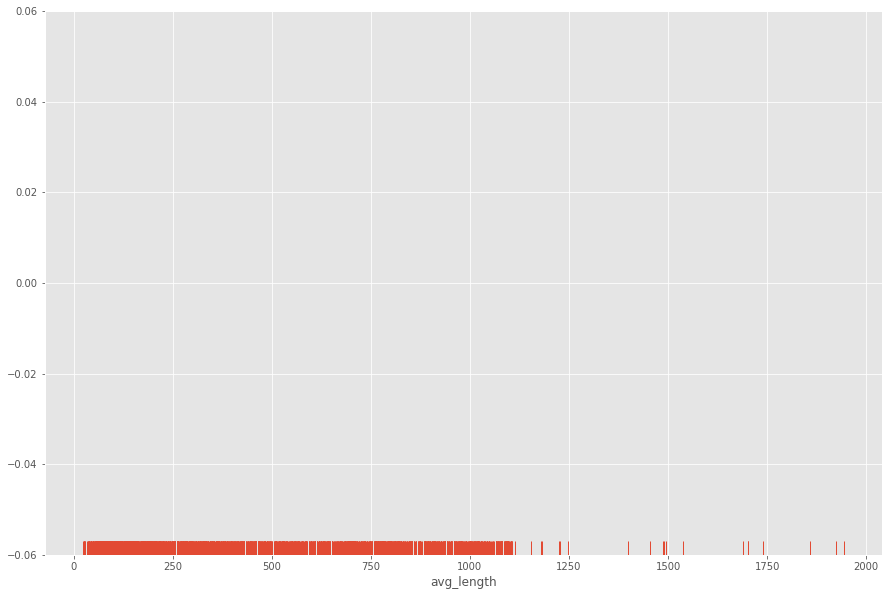

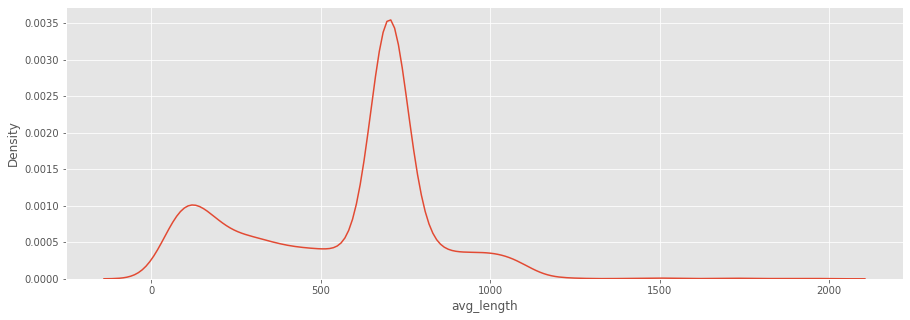

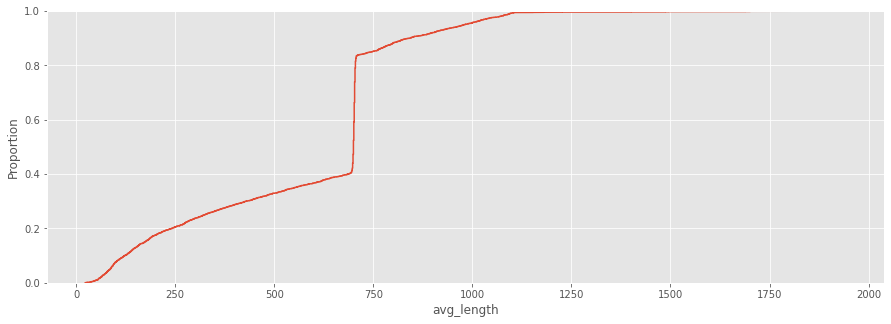

In [34]:
thanhniencongiao.plot()

### Observations

In [35]:
df = thanhniencongiao.df
limit = 400

In [36]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[-15])

31      CHA GIOAN B. TR·∫¶N QUANG TRUY·ªÄN XU·∫§T VI·ªÜN\n\nCh...
36      #TNCG - S·ªê CA COVID 19 L√ÇY NHI·ªÑM C·ªòNG ƒê·ªíNG T·ª™ ...
49      ‚Äúƒê·ª´ng tin nh·ªØng g√¨ c·ªông s·∫£n n√≥i, m√† h√£y xem nh...
52      "T√äN T√îI L√Ä N·∫†N NH√ÇN C·ªòNG S·∫¢N"\n\nƒê√≥ l√† c√¢u tr...
68      30/4/1975 NG√ÄY C·ªêT NH·ª§C T∆Ø∆†NG T√ÄN, NG√ÄY N·ªÄN VƒÇ...
                              ...                        
5465    Nguy c∆° Th·ªß t∆∞·ªõng Canada Justin Trudeau ƒëang t...
5466    O la la, Vi·ªát Nam ta ƒë√¢y\nC√≥ n∆°i n√†o tr√™n th·∫ø ...
5467    Advancing human rights = ch·∫•m l·ª≠ng (...)?\n\nA...
5477    T√¢n ƒë·∫°i s·ª© qu√°n M·ªπ t·∫°i Vi·ªát Nam, √¥ng Daniel Kr...
5509    B·∫∞NG CH·ª®NG C·ªú ƒê·ªé DI·ªÑN M·ª∏ ƒê√ÅNH NG∆Ø·ªúI\n\n#TNCG -...
Name: content, Length: 1029, dtype: object
--------------------



500 ƒë·ªìng kh√¥ng mua n·ªïi c√¢y kem, nh∆∞ng l·∫°i khi·∫øn c·∫£ m·ªôt h·ªá th·ªëng d·ªü kh√≥c d·ªü c∆∞·ªùi. Ch·ªâ v√¨ ng∆∞·ªùi d√¢n d√πng ti·ªÅn l·∫ª m√† l·∫°i d√πng c√¥ng an c∆° ƒ

In [37]:
limit = 1700

In [38]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

663     ƒê√É H∆†N BA NƒÇM R·ªíI KH√îNG BI·∫æT T√çA RA SAO\n\nVi·∫ø...
1213    QU·∫¢ L√Ä NGAO NG√ÅN CHO C√ÅC B·∫†N DU H·ªåC SINH\n\nC√°...
2581    CHUNG TAY ƒê√ôM B·ªåC C√î G√ÅI KI√äN C∆Ø·ªúNG, B·∫§T KHU·∫§T...
2891    Sƒ® PHU VI·ªÜT NAM S·∫º BI·ªÇU T√åNH N·∫æU NH√Ä N∆Ø·ªöC ƒê·ªÇ N...
3905    TH√îNG B√ÅO K·∫∫ GI·∫¢ DANH LINH M·ª§C ƒê·ªÇ CHIA R·∫∫ GI√ÅO...
3932    C√ÅN B·ªò ƒê·∫¢NG B·∫¢O K√ä CHO NG∆Ø·ªúI D√ÇN CHI·∫æM ƒê·∫§T C·ª¶A...
Name: content, dtype: object
--------------------



ƒê√É H∆†N BA NƒÇM R·ªíI KH√îNG BI·∫æT T√çA RA SAO

Vi·∫øt v√†i d√≤ng ƒë·ªÉ nh·ªõ ƒë·∫øn t√≠a ! C·∫ßu mong t√≠a m·∫°nh kh·ªèe b√¨nh an trong ng·ª•c t√π t√¢m t·ªëi ·∫•y.
Gi·ªù kh√¥ng bi·∫øt s·ª©c kh·ªèe t√≠a th·∫ø n√†o v√† s·ªëng ra sao khi m√† kh√¥ng nh·∫≠n ƒë∆∞·ª£c th·ª©c ƒÉn t·ª´ gia ƒë√¨nh v√† kh√¥ng ƒë∆∞·ª£c thƒÉm nu√¥i nh∆∞ m·ªçi ng∆∞·ªùi kh√°c, th·ªùi gian t√≠a ·ªü cho ƒë·∫øn nay ƒë√£ h∆°n 3 nƒÉm r·ªìi nh∆∞ng gia ƒë√¨nh kh√¥ng ƒë∆∞·ª£c g·∫∑p m·∫∑t t√≠a. ƒê√£ 2 nƒÉm con r·∫•t ƒëau kh·ªï v√† bu·ªìn nh∆∞n

### Run Preprocessing method

In [39]:
# 400 - 10000
# ...
thanhniencongiao.preprocess()

Enter < limit:400
Enter > limit:10000


### Save

In [40]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	   viettan.csv
chantroimoi.pickle	 rfa.pickle		   viettan_fb.csv
giaochucchuvanan.pickle  sbtn.pickle		   viettan_fb.pickle
khoi8406.pickle		 thanhnienconggiao.pickle  viettan.pickle


In [41]:
thanhniencongiao.df.iloc[0]['content']

'‚ÄúN·∫øu linh h·ªìn thu·ªôc v·ªÅ nh√† n∆∞·ªõc, th√¨ vi·ªác d√¢ng linh h·ªìn m√¨nh l√™n cho Thi√™n Ch√∫a l√† m·ªôt s·ª± ph·∫£n b·ªôi ƒë·ªëi v·ªõi nh√† n∆∞·ªõc. ƒê√≥ l√† l√Ω do v√¨ sao Gi√°o H·ªôi C√¥ng Gi√°o b·ªã d√°n nh√£n l√† ‚ÄúPh·∫£n ƒê·ªông‚Äù. M·ªôt nh√† n∆∞·ªõc v√¥ th·∫ßn hi·ªÉu r√µ r·∫±ng h·ªç kh√¥ng th·ªÉ ho√†n to√†n s·ªü h·ªØu con ng∆∞·ªùi nh∆∞ m·ªôt c√¥ng c·ª• c·ªßa nh√† n∆∞·ªõc, tr·ª´ khi h·ªç ph√° h·ªßy Gi√°o H·ªôi, m√† Gi√°o H·ªôi ƒë√≥ d·∫°y r·∫±ng: Con ng∆∞·ªùi l√† con c√°i Thi√™n Ch√∫a. Nh√† n∆∞·ªõc ƒë√≥ kh√¥ng th·ªÉ bi·∫øn con ng∆∞·ªùi th√†nh n√¥ l·ªá cho t·ªõi khi n√≥ n√¥ l·ªá h√≥a ƒë∆∞·ª£c Gi√°o H·ªôi, m√† Gi√°o H·ªôi ƒë√≥ d·∫°y r·∫±ng: Con ng∆∞·ªùi c√≥ t·ª± do‚Äù\n\nTr√≠ch: ‚ÄúCh·ªß nghƒ©a c·ªông s·∫£n v√† l∆∞∆°ng t√¢m Ph∆∞∆°ng T√¢y‚Äù - ƒê·ª©c t·ªïng Gi√°m m·ª•c Fulton Sheen Hoa K·ª≥.\n\nNgu·ªìn: Ho√†i Th·∫°ch S∆°n.'

In [42]:
thanhniencongiao.save_preprocess(os.getcwd() + "/thanhnienconggiao")

In [43]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## SBTN

### Define new instances

In [44]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

sbtn = Dataframe('/1/' + 'sbtn.csv', 1)
print(sbtn.name)
sbtn.read_csv()

df = sbtn.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/sbtn.csv
df:        Unnamed: 0                                            content
0              0  Ngh·ªá s·ªπ h√†i D∆∞∆°ng Ho√†i Linh b·ªã ch·ªâ tr√≠ch v√¨ gi...
1              1  Ng∆∞·ªùi d√¢n b·ªã l·∫≠p bi√™n b·∫£n v√¨ kh√¥ng mu·ªën l√†m tr...
2              2  Ng√¢n h√†ng th·∫ø gi·ªõi n√≥i d√≤ng v·ªën ƒë·∫ßu t∆∞ tr·ª±c ti...
3              3  Ng∆∞·ªùi Vi·ªát u·ªëng nhi·ªÅu bia r∆∞·ª£u h∆°n trong ƒë·∫°i d...
4              4  Nhi·ªÅu ng∆∞·ªùi Vi·ªát Nam mu·ªën ƒëi Hoa K·ª≥ ti√™m vacci...
...          ...                                                ...
2900        2900  B·ªô c√¥ng an ƒë·ªÅ ngh·ªã gi·∫£m t·ªôi cho Ph·∫°m Nh·∫≠t V≈© v...
2901        2901  ƒê·ªìng b·∫±ng s√¥ng C·ª≠u Long ƒëang ch√¨m v·ªõi t·ªëc ƒë·ªô n...
2902        2902  CSVN ƒë∆∞a ƒë∆°n v·ªã tr√∫ng th·∫ßu xa l·ªô B·∫Øc- Nam v√†o ...
2903        2903  M·ªôt th·ª±c t·∫≠p sinh ng∆∞·ªùi Vi·ªát b·ªã b·∫Øt ·ªü Nh·∫≠t t·ªôi...
2904        2904  C√¥ng an CSVN gi·∫£i th√≠ch nguy√™n nh√¢n tr·∫£ 400 t·ªô...

[2905 rows x

content  label  avg_length
0     Ngh·ªá s·ªπ h√†i D∆∞∆°ng Ho√†i Linh b·ªã ch·ªâ tr√≠ch v√¨ gi...      1        1683
1     Ng∆∞·ªùi d√¢n b·ªã l·∫≠p bi√™n b·∫£n v√¨ kh√¥ng mu·ªën l√†m tr...      1        1588
2     Ng√¢n h√†ng th·∫ø gi·ªõi n√≥i d√≤ng v·ªën ƒë·∫ßu t∆∞ tr·ª±c ti...      1        1412
3     Ng∆∞·ªùi Vi·ªát u·ªëng nhi·ªÅu bia r∆∞·ª£u h∆°n trong ƒë·∫°i d...      1        1017
4     Nhi·ªÅu ng∆∞·ªùi Vi·ªát Nam mu·ªën ƒëi Hoa K·ª≥ ti√™m vacci...      1        1402
...                                                 ...    ...         ...
2900  B·ªô c√¥ng an ƒë·ªÅ ngh·ªã gi·∫£m t·ªôi cho Ph·∫°m Nh·∫≠t V≈© v...      1        1734
2901  ƒê·ªìng b·∫±ng s√¥ng C·ª≠u Long ƒëang ch√¨m v·ªõi t·ªëc ƒë·ªô n...      1        1683
2902  CSVN ƒë∆∞a ƒë∆°n v·ªã tr√∫ng th·∫ßu xa l·ªô B·∫Øc- Nam v√†o ...      1        1526
2903  M·ªôt th·ª±c t·∫≠p sinh ng∆∞·ªùi Vi·ªát b·ªã b·∫Øt ·ªü Nh·∫≠t t·ªôi...      1        1070
2904  C√¥ng an CSVN gi·∫£i th√≠ch nguy√™n nh√¢n tr·∫£ 400 t·ªô...      1        1700

[2905 rows x 3 columns]

### Content Filter

In [45]:
temp = df[df['content'].str.contains("VN|CS|Vi·ªát Nam|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|c·ªông s·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c|ch√≠nh tr·ªã", regex = True, flags=re.IGNORECASE)]

print(sbtn.name)
sbtn.df = temp
sbtn.df

df = sbtn.df

/1/sbtn.csv


In [46]:
sbtn.df['content'].iloc[1]

'Ng∆∞·ªùi d√¢n b·ªã l·∫≠p bi√™n b·∫£n v√¨ kh√¥ng mu·ªën l√†m tr√°i l∆∞∆°ng t√¢m, nh·∫Øm m·∫Øt b·ªè phi·∫øu cho ·ª©ng c·ª≠ vi√™n c·ªßa ƒë·∫£ng C·ªông s·∫£n\nTin Vietnam.- Li√™n quan ƒë·∫øn v·ªü k·ªãch b·∫ßu c·ª≠ gi·∫£ hi·ªáu t·∫°i Vi·ªát Nam v√†o ng√†y 23 th√°ng 5 nƒÉm 2021, nhi·ªÅu ng∆∞·ªùi d√¢n ph·∫£n √°nh, h·ªç ƒë√£ b·ªã c√°c nh√¢n vi√™n, vi√™n ch·ª©c C·ªông s·∫£n v√°c th√πng phi·∫øu ƒë·∫øn t·∫≠n nh√† √©p b·ªè phi·∫øu cho nh·ªØng ·ª©ng c·ª≠ vi√™n do ƒë·∫£ng C·ªông s·∫£n c·ª≠ ra.\nTr√™n trang Facebook c√° nh√¢n, √¥ng ƒêinh VƒÉn H·∫£i, ·ªü huy·ªán ƒê·ª©c Tr·ªçng, t·ªânh L√¢m ƒê·ªìng cho bi·∫øt, chi·ªÅu t·ªëi 23, ban b·∫ßu c·ª≠ ƒë·ªãa ph∆∞∆°ng ƒë√£ mang theo th√πng phi·∫øu ƒë·∫øn t·∫≠n nh√† √¥ng ƒë·ªÉ y√™u c·∫ßu √¥ng b·ªè phi·∫øu. Nh∆∞ng √¥ng H·∫£i ƒë√£ ki√™n quy·∫øt t·ª´ ch·ªëi v√¨ √¥ng kh√¥ng bi·∫øt r√µ c√°c ·ª©ng c·ª≠ vi√™n l√† ai n√™n kh√¥ng th·ªÉ l√†m tr√°i l∆∞∆°ng t√¢m m√¨nh. Kh√¥ng th√∫c √©p ƒë∆∞·ª£c √¥ng H·∫£i, ban b·∫ßu c·ª≠ C·ªông s·∫£n ƒë√£ l·∫≠p bi√™n b·∫£n s·ª± vi·ªác, xong

In [47]:
aaa = pd.concat([temp, df])
aaa.drop_duplicates('content', keep = False)['content'].iloc[3]

IndexError: ignored

### Plot distribution

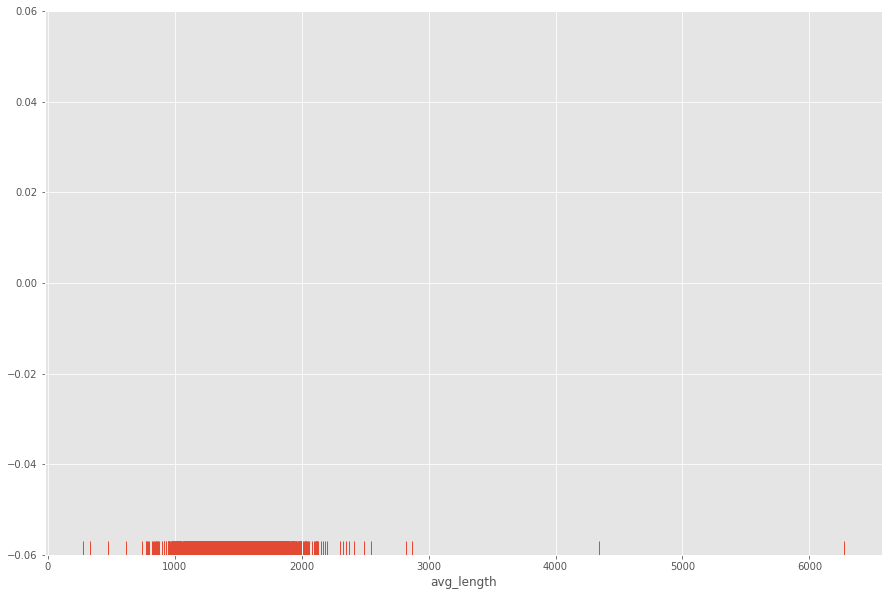

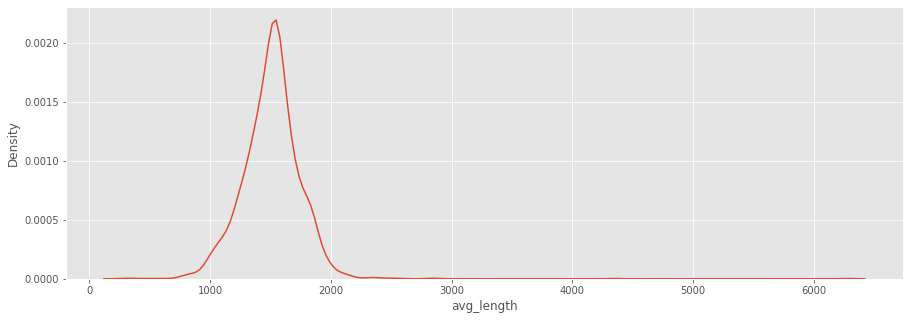

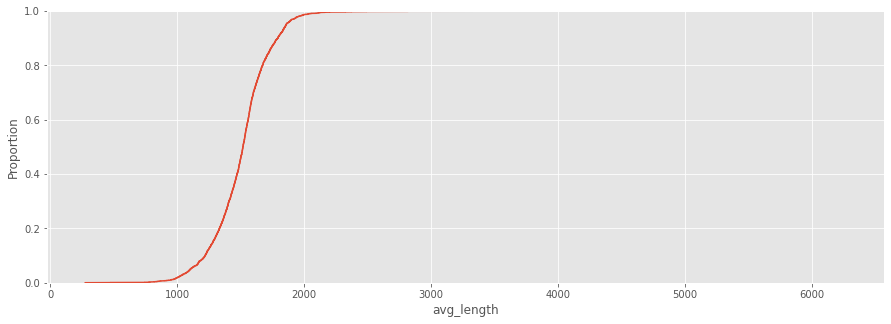

In [49]:
sbtn.plot()

### Observations

In [50]:
df = sbtn.df
limit = 700

In [51]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

332     Cu·ªôc s·ªëng tu·ªïi ‚Äúx·∫ø chi·ªÅu‚Äù c·ªßa th√†nh vi√™n trong...
518     Th∆∞∆°ng ph·∫ø binh VNCH nghƒ© g√¨ v·ªÅ c·ªù VNCH trong ...
913     Ngo·∫°i tr∆∞·ªüng Pompeo g·∫∑p b·ªô tr∆∞·ªüng c√¥ng an CSVN...
2053    21 thuy·ªÅn vi√™n Vi·ªát Nam ·ªü v√πng bi·ªÉn Th√°i Lan ƒë...
Name: content, dtype: object
--------------------



Cu·ªôc s·ªëng tu·ªïi ‚Äúx·∫ø chi·ªÅu‚Äù c·ªßa th√†nh vi√™n trong ban nh·∫°c Ph∆∞·ª£ng Ho√†ng
Tr∆∞·ªõc nƒÉm 1975, trong gi·ªõi thanh ni√™n sinh vi√™n, kh√¥ng ai l·∫°i kh√¥ng bi·∫øt ƒë·∫øn ban nh·∫°c Ph∆∞·ª£ng Ho√†ng. Sau khi c·ªông s·∫£n c∆∞·ª°ng chi·∫øm mi·ªÅn Nam mi·ªÅn Nam, m·ªói ng∆∞·ªùi l∆∞u l·∫°c m·ªôt n∆°i. K·∫ª tr·ªùi ƒê√¥ng, ng∆∞·ªùi tr·ªùi T√¢y, k·∫ª ƒë√£ khu·∫•t. Xin m·ªùi qu√Ω kh√°n gi·∫£ theo d√µi ph√≥ng s·ª± sau ƒë√¢y:


In [52]:
limit = 4000

In [53]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

586     Tuy√™n b·ªë c·ªßa H·ªôi Nh√† B√°o ƒê·ªôc L·∫≠p Vi·ªát Nam\nV·ªÅ ...
2754    CSVN gia tƒÉng cƒÉng th·∫≥ng v·ªõi Trung C·ªông trong ...
Name: content, dtype: object
--------------------



Tuy√™n b·ªë c·ªßa H·ªôi Nh√† B√°o ƒê·ªôc L·∫≠p Vi·ªát Nam
V·ªÅ vi·ªác: Nh√† c·∫ßm quy·ªÅn Vi·ªát Nam k·∫øt √°n th√†nh vi√™n H·ªôi Nh√† B√°o ƒê·ªôc l·∫≠p Vi·ªát Nam.
Ng√†y 05 th√°ng 01 nƒÉm 2021, T√≤a √°n Tp H·ªì Ch√≠ Minh ƒë√£ t·ªï ch·ª©c c√°i g·ªçi l√† ‚ÄúPhi√™n t√≤a s∆° th·∫©m‚Äù ƒë·ªÉ x√©t x·ª≠ ba th√†nh vi√™n c·ªßa H·ªôi Nh√† B√°o ƒê·ªôc L·∫≠p Vi·ªát Nam (HNBƒêLVN) theo theo ƒêi·ªÅu 117 c·ªßa B·ªô lu·∫≠t H√¨nh s·ª± v·ªÅ c√°o bu·ªôc ‚ÄúL√†m, t√†ng tr·ªØ, ph√°t t√°n ho·∫∑c tuy√™n truy·ªÅn th√¥ng tin, t√†i li·ªáu, v·∫≠t ph·∫©m nh·∫±m ch·ªëng Nh√† n∆∞·ªõc C·ªông h√≤a x√£ h·ªôi ch·ªß nghƒ©a Vi·ªát Nam‚Äù.
Ba th√†nh vi√™n c·ªßa H·ªôi Nh√† B√°o ƒê·ªôc L·∫≠p Vi·ªát Nam b·ªã nh√† c·∫ßm quy·ªÅn Vi·ªát Nam k·∫øt √°n v·ªõi m·ª©c √°n nh∆∞ sau:
Ti·∫øn sƒ© Ph·∫°m Ch√≠ D≈©ng, Ch·ªß t·ªãch H·ªôi NBƒêLVN, 15

### Run Preprocessing method

In [54]:
# 700 - 10000
# ...
sbtn.preprocess()

Enter < limit:700
Enter > limit:10000


### Save

In [55]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa.pickle		   viettan_fb.csv
chantroimoi.pickle	 sbtn.pickle		   viettan_fb.pickle
giaochucchuvanan.pickle  thanhnienconggiao.csv	   viettan.pickle
khoi8406.pickle		 thanhnienconggiao.pickle
phamminhvu.pickle	 viettan.csv


In [56]:
sbtn.df.iloc[1]['content']

'Ng∆∞·ªùi d√¢n b·ªã l·∫≠p bi√™n b·∫£n v√¨ kh√¥ng mu·ªën l√†m tr√°i l∆∞∆°ng t√¢m, nh·∫Øm m·∫Øt b·ªè phi·∫øu cho ·ª©ng c·ª≠ vi√™n c·ªßa ƒë·∫£ng C·ªông s·∫£n\nTin Vietnam.- Li√™n quan ƒë·∫øn v·ªü k·ªãch b·∫ßu c·ª≠ gi·∫£ hi·ªáu t·∫°i Vi·ªát Nam v√†o ng√†y 23 th√°ng 5 nƒÉm 2021, nhi·ªÅu ng∆∞·ªùi d√¢n ph·∫£n √°nh, h·ªç ƒë√£ b·ªã c√°c nh√¢n vi√™n, vi√™n ch·ª©c C·ªông s·∫£n v√°c th√πng phi·∫øu ƒë·∫øn t·∫≠n nh√† √©p b·ªè phi·∫øu cho nh·ªØng ·ª©ng c·ª≠ vi√™n do ƒë·∫£ng C·ªông s·∫£n c·ª≠ ra.\nTr√™n trang Facebook c√° nh√¢n, √¥ng ƒêinh VƒÉn H·∫£i, ·ªü huy·ªán ƒê·ª©c Tr·ªçng, t·ªânh L√¢m ƒê·ªìng cho bi·∫øt, chi·ªÅu t·ªëi 23, ban b·∫ßu c·ª≠ ƒë·ªãa ph∆∞∆°ng ƒë√£ mang theo th√πng phi·∫øu ƒë·∫øn t·∫≠n nh√† √¥ng ƒë·ªÉ y√™u c·∫ßu √¥ng b·ªè phi·∫øu. Nh∆∞ng √¥ng H·∫£i ƒë√£ ki√™n quy·∫øt t·ª´ ch·ªëi v√¨ √¥ng kh√¥ng bi·∫øt r√µ c√°c ·ª©ng c·ª≠ vi√™n l√† ai n√™n kh√¥ng th·ªÉ l√†m tr√°i l∆∞∆°ng t√¢m m√¨nh. Kh√¥ng th√∫c √©p ƒë∆∞·ª£c √¥ng H·∫£i, ban b·∫ßu c·ª≠ C·ªông s·∫£n ƒë√£ l·∫≠p bi√™n b·∫£n s·ª± vi·ªác, xong

In [57]:
sbtn.save_preprocess(os.getcwd() + "/sbtn")

In [58]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## RFA

### Define new instances

In [59]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

rfa = Dataframe('/1/' + 'rfa.csv', 1)
print(rfa.name)
rfa.read_csv()

df = rfa.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/rfa.csv
df:        Unnamed: 0                                            content
0              0  T√†u tu·∫ßn duy√™n M·ªπ kho√°c "√°o m·ªõi": Vietnam Coas...
1              1  H√¥m nay sau g·∫ßn m·ªôt tu·∫ßn b·ªã d√¢n m·∫°ng phanh phu...
2              2  T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...
3              3  T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...
4              4  C√¥ng d√¢n khi·∫øm th·ªã, v·ª£ ·ª©ng vi√™n ƒë·ªôc l·∫≠p, b·ªã l·∫≠...
...          ...                                                ...
1261        1261  T·ªï ch·ª©c Ph√≥ng vi√™n Kh√¥ng Bi√™n Gi·ªõi (RSF) v√†o n...
1262        1262  C√≥ v·∫ª nh∆∞ t·ªânh H·∫£i D∆∞∆°ng - Vi·ªát Nam ƒëang √°p d·ª•...
1263        1263  Chi·∫øn d·ªãch 5K: ‚ÄúT·ª© tr·ª•‚Äù kh√¥ng l√†m g∆∞∆°ng d√π B·ªô ...
1264        1264  H·∫£i D∆∞∆°ng: 60 ng∆∞·ªùi d√πng 1 nh√† v·ªá sinh trong k...
1265        1265  M√¥ h√¨nh ch·ªëng d·ªãch gi√° r·∫ª t·ª´ng gi√∫p VN th√†nh c...

[1266 rows x 2 columns]

content  label  avg_length
0     T√†u tu·∫ßn duy√™n M·ªπ kho√°c "√°o m·ªõi": Vietnam Coas...      1        1413
1     H√¥m nay sau g·∫ßn m·ªôt tu·∫ßn b·ªã d√¢n m·∫°ng phanh phu...      1        1758
2     T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...      1         580
3     T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...      1         690
4     C√¥ng d√¢n khi·∫øm th·ªã, v·ª£ ·ª©ng vi√™n ƒë·ªôc l·∫≠p, b·ªã l·∫≠...      1         813
...                                                 ...    ...         ...
1261  T·ªï ch·ª©c Ph√≥ng vi√™n Kh√¥ng Bi√™n Gi·ªõi (RSF) v√†o n...      1        2214
1262  C√≥ v·∫ª nh∆∞ t·ªânh H·∫£i D∆∞∆°ng - Vi·ªát Nam ƒëang √°p d·ª•...      1        2159
1263  Chi·∫øn d·ªãch 5K: ‚ÄúT·ª© tr·ª•‚Äù kh√¥ng l√†m g∆∞∆°ng d√π B·ªô ...      1        1413
1264  H·∫£i D∆∞∆°ng: 60 ng∆∞·ªùi d√πng 1 nh√† v·ªá sinh trong k...      1        1412
1265  M√¥ h√¨nh ch·ªëng d·ªãch gi√° r·∫ª t·ª´ng gi√∫p VN th√†nh c...      1        1404

[1266 rows x 3 columns]

### Content Filter

In [60]:
temp = df[df['content'].str.contains("VN|CS|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|c·ªông s·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|t·ª± do|d·ªëi|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c", regex = True, flags=re.IGNORECASE)]

print(rfa.name)
rfa.df = temp
rfa.df

# df = rfa.df

/1/rfa.csv


content  label  avg_length
1     H√¥m nay sau g·∫ßn m·ªôt tu·∫ßn b·ªã d√¢n m·∫°ng phanh phu...      1        1758
2     T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...      1         580
3     T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...      1         690
4     C√¥ng d√¢n khi·∫øm th·ªã, v·ª£ ·ª©ng vi√™n ƒë·ªôc l·∫≠p, b·ªã l·∫≠...      1         813
5     Th·∫Øng l·ª£i b·∫±ng m·ªçi gi√°\nNhi·ªÅu ng√†y qua, Vi·ªát N...      1        2034
...                                                 ...    ...         ...
1260  Th·ªß t∆∞·ªõng Vi·ªát Nam kh·∫≥ng ƒë·ªãnh nh·∫≠p vaccine ph√≤...      1         999
1261  T·ªï ch·ª©c Ph√≥ng vi√™n Kh√¥ng Bi√™n Gi·ªõi (RSF) v√†o n...      1        2214
1262  C√≥ v·∫ª nh∆∞ t·ªânh H·∫£i D∆∞∆°ng - Vi·ªát Nam ƒëang √°p d·ª•...      1        2159
1263  Chi·∫øn d·ªãch 5K: ‚ÄúT·ª© tr·ª•‚Äù kh√¥ng l√†m g∆∞∆°ng d√π B·ªô ...      1        1413
1265  M√¥ h√¨nh ch·ªëng d·ªãch gi√° r·∫ª t·ª´ng gi√∫p VN th√†nh c...      1        1404

[876 rows x 3 columns]

In [61]:
aaa = pd.concat([temp, df])
aaa.drop_duplicates('content', keep = False)['content']

0       T√†u tu·∫ßn duy√™n M·ªπ kho√°c "√°o m·ªõi": Vietnam Coas...
6       Trung Qu·ªëc ƒëe do·∫° M·ªπ-Nam H√†n kh√¥ng can thi·ªáp ƒê...
8       Nghi√™n c·ª©u sinh Vi·ªán Virus V≈© H√°n nh·∫≠p vi·ªán tr...
9       ƒê·ªÉ t√¨m hi·ªÉu th·ª±c t·∫ø, RFA h√¥m 24/5 li√™n l·∫°c Anh...
21      B√≥ng t·ªëi c·ªßa nƒÉng l∆∞·ª£ng m·∫∑t tr·ªùi\nC√°c nh√† m√°y ...
                              ...                        
1245    B√† c·ª• ƒë·ªçc th∆° ch·ªëng b√†nh tr∆∞·ªõng B·∫Øc Kinh\nƒêo·∫°n...
1251    ·∫§n ƒê·ªô v√† TQ r√∫t qu√¢n kh·ªèi khu v·ª±c tranh ch·∫•p ·ªü...
1252    H√†ng lo·∫°t t·ªânh th√†nh cho h·ªçc sinh ngh·ªâ h·ªçc sau...
1254    H√†ng lo·∫°t t·ªânh th√†nh cho h·ªçc sinh ngh·ªâ h·ªçc sau...
1264    H·∫£i D∆∞∆°ng: 60 ng∆∞·ªùi d√πng 1 nh√† v·ªá sinh trong k...
Name: content, Length: 390, dtype: object

### Plot distribution

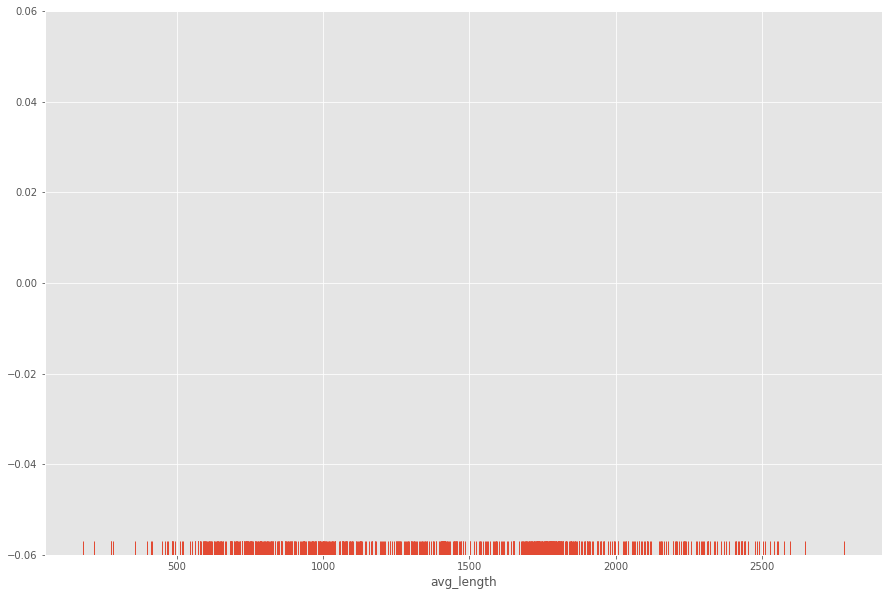

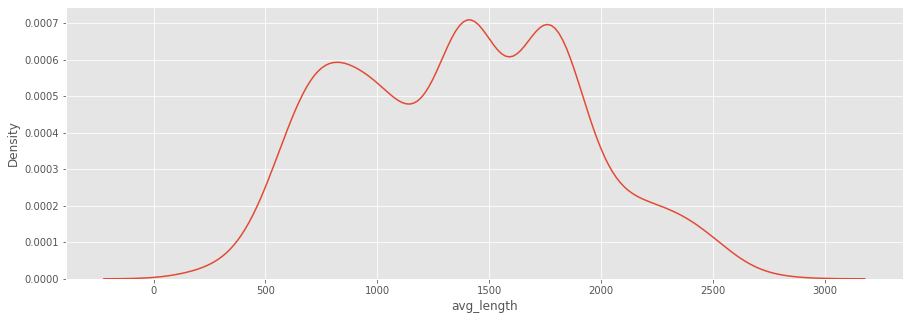

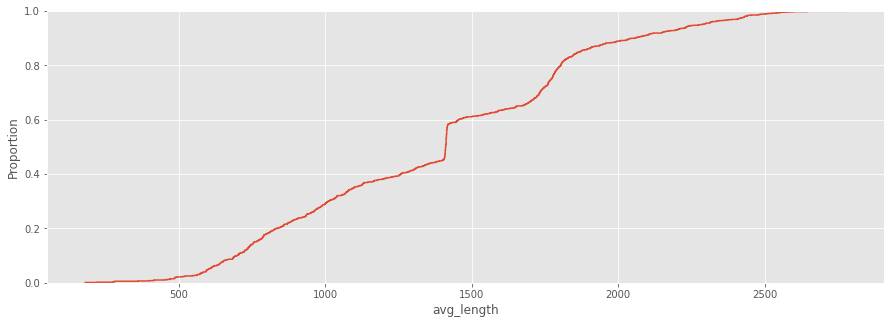

In [62]:
rfa.plot()

### Observations

In [63]:
df = rfa.df
limit = 700

In [64]:
df

content  label  avg_length
1     H√¥m nay sau g·∫ßn m·ªôt tu·∫ßn b·ªã d√¢n m·∫°ng phanh phu...      1        1758
2     T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...      1         580
3     T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...      1         690
4     C√¥ng d√¢n khi·∫øm th·ªã, v·ª£ ·ª©ng vi√™n ƒë·ªôc l·∫≠p, b·ªã l·∫≠...      1         813
5     Th·∫Øng l·ª£i b·∫±ng m·ªçi gi√°\nNhi·ªÅu ng√†y qua, Vi·ªát N...      1        2034
...                                                 ...    ...         ...
1260  Th·ªß t∆∞·ªõng Vi·ªát Nam kh·∫≥ng ƒë·ªãnh nh·∫≠p vaccine ph√≤...      1         999
1261  T·ªï ch·ª©c Ph√≥ng vi√™n Kh√¥ng Bi√™n Gi·ªõi (RSF) v√†o n...      1        2214
1262  C√≥ v·∫ª nh∆∞ t·ªânh H·∫£i D∆∞∆°ng - Vi·ªát Nam ƒëang √°p d·ª•...      1        2159
1263  Chi·∫øn d·ªãch 5K: ‚ÄúT·ª© tr·ª•‚Äù kh√¥ng l√†m g∆∞∆°ng d√π B·ªô ...      1        1413
1265  M√¥ h√¨nh ch·ªëng d·ªãch gi√° r·∫ª t·ª´ng gi√∫p VN th√†nh c...      1        1404

[876 rows x 3 columns]

In [65]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

2       T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...
3       T·ªïng b√≠ th∆∞ Nguy·ªÖn Ph√∫ Tr·ªçng l√™ m·ªôt ch√¢n ƒëi b·ªè...
16      T·ªï b·∫ßu c·ª≠ s·ªë 5 c·ªßa ph∆∞·ªùng Ph√π ƒê·ªïng, th√†nh ph·ªë ...
42      1. Th√™m m·ªôt ca t·ª≠ vong do COVID-19 n√¢ng t·ªïng s...
43      1. Th√™m m·ªôt ca t·ª≠ vong do COVID-19 n√¢ng t·ªïng s...
                              ...                        
1175    LHQ l√™n √°n c√°c n∆∞·ªõc l·∫•y c·ªõ COVID-19 ƒë·ªÉ ƒë√†n √°p ...
1208    T∆∞·ªõng qu√¢n ƒë·ªôi chuy·ªÉn qua l√†m Tr∆∞·ªüng ban Tuy√™n...
1250    Ph√°p: 10 ng√†n ng∆∞·ªùi k√Ω t√™n y√™u c·∫ßu VN t√¥n tr·ªçn...
1258    RSF k√™u g·ªçi tr·∫£ t·ª± do cho nh√† b√°o Phan B√πi B·∫£o...
1259    RSF k√™u g·ªçi tr·∫£ t·ª± do cho nh√† b√°o Phan B√πi B·∫£o...
Name: content, Length: 89, dtype: object
--------------------





In [66]:
limit = 2500

In [67]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

24      ƒê·∫°i s·ª© Nga: "G7 m·∫°o hi·ªÉm khi ƒë·∫©y Nga-Trung g·∫ßn...
265     H√£y tr·∫£ t·ª± do cho ba th√†nh vi√™n trong m·ªôt nh√† ...
392     Ph√≥ ch·ªß t·ªãch Bhargava n√≥i ·ª¶y h·ªôi c≈©ng ƒëang r·∫•t...
507     Gi·ªõi quan s√°t cho r·∫±ng nh·ªØng ho√†i nghi v√† b·ª©c ...
619     Kh·ªßng ho·∫£ng th·ªÉ ch·∫ø lu√¥n k√©o theo suy gi·∫£m ni·ªÅ...
684     Xin c√≥ l·ªùi m·ª´ng, ƒë·ªìng th·ªùi c≈©ng xin chia bu·ªìn ...
746     H√¨nh ·∫£nh D∆∞∆°ng Khi·∫øt Tr√¨ ‚Äúm·ªìm ph√πng m√° tr·ª£n‚Äù n...
931     Nh√† ho·∫°t ƒë·ªông d√¢n ch·ªß ƒêinh Quang Tuy·∫øn c≈©ng t·ª´...
1035    Kh√¥ng kh√°c g√¨ ‚Äúcua g·∫∑p ·∫øch‚Äù, ngo·∫°i tr∆∞·ªüng Ph·∫°m...
1084    PGS-TS. Ho√†ng D≈©ng, thu·ªôc tr∆∞·ªùng ƒê·∫°i h·ªçc S∆∞ ph...
Name: content, dtype: object
--------------------



ƒê·∫°i s·ª© Nga: "G7 m·∫°o hi·ªÉm khi ƒë·∫©y Nga-Trung g·∫ßn nhau"
√îng Andrei Kelin, ƒê·∫°i s·ª© Nga t·∫°i London, Anh, h√¥m 20/5 l√™n ti·∫øng ƒëe do·∫° c√°c n∆∞·ªõc G7 (M·ªπ, Anh, ƒê·ª©c Ph√°p, Nh·∫≠t, Canada, Italy) r·∫±ng G

### Run Preprocessing method

In [68]:
# 500 - 10000
# ...
rfa.preprocess()

Enter < limit:500
Enter > limit:10000


### Save

In [69]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa.pickle		   viettan.csv
chantroimoi.pickle	 sbtn.csv		   viettan_fb.csv
giaochucchuvanan.pickle  sbtn.pickle		   viettan_fb.pickle
khoi8406.pickle		 thanhnienconggiao.csv	   viettan.pickle
phamminhvu.pickle	 thanhnienconggiao.pickle


In [70]:
rfa.save_preprocess(os.getcwd() + "/rfa_fixed")

In [71]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## khoi8406

### Define new instances

In [72]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

khoi8406 = Dataframe('/1/' + 'khoi8406.csv', 1)
print(khoi8406.name)
khoi8406.read_csv()

df = khoi8406.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/khoi8406.csv
df:      Unnamed: 0                                            content
0            0                                                NaN
1            1                                                NaN
2            2  d√¢n oan d∆∞∆°ng n·ªôi bi·ªÉu t√¨nh tr∆∞·ªõc ƒë·∫°i s·ª© qu√°n ...
3            3  ƒê√°nh ƒë·∫≠p d√£ man\n\nTrong nh·ªØng ng√†y qua, nhi·ªÅu...
4            4  C√≥ qu√Ω v·ªã n√†o cho r·∫±ng bi·ªÉu t√¨nh ch·ªëng Trung Q...
5            5  L·ªúI K√äU G·ªåI BI·ªÇU T√åNH CH·ªêNG TRUNG QU·ªêC X√ÇM L∆Ø·ª¢...
6            6  B√™n l·ªÅ ƒë∆∞·ªùng.....\n\nKhi m√† c∆°m kh√¥ng ƒë·ªß no, √°...
7            7  Tr·∫£ l·ªùi Xu√¢n H·ªìngÔªø BBC. B√† B·∫£y V√¢n v·ª£ T·ªïng BT ...
8            8  TH·∫æ H·ªÜ H√àN NH√ÅT\n\nCh·∫Øc c√°c ch√∫, c√°c anh s·∫Ω bu...
9            9  CH·ªêNG TRUNG QU·ªêC KH√îNG PH·∫¢I L√Ä T·ªòI\n\n[BBC] M·∫π...
10          10  B√ç ·∫®N NH·ªÆNG V·ª§ T·ª∞ S√ÅT T·∫¨P TH·ªÇ C·ª¶A LO√ÄI V·∫¨T\n\n...
11          11  CH√ÄO M·ª™NG K·ª∂ NI·ªÜM 50 NƒÇM NG√ÄY T

content  label  avg_length
2   d√¢n oan d∆∞∆°ng n·ªôi bi·ªÉu t√¨nh tr∆∞·ªõc ƒë·∫°i s·ª© qu√°n ...      1         159
3   ƒê√°nh ƒë·∫≠p d√£ man\n\nTrong nh·ªØng ng√†y qua, nhi·ªÅu...      1         783
4   C√≥ qu√Ω v·ªã n√†o cho r·∫±ng bi·ªÉu t√¨nh ch·ªëng Trung Q...      1         656
5   L·ªúI K√äU G·ªåI BI·ªÇU T√åNH CH·ªêNG TRUNG QU·ªêC X√ÇM L∆Ø·ª¢...      1        1047
6   B√™n l·ªÅ ƒë∆∞·ªùng.....\n\nKhi m√† c∆°m kh√¥ng ƒë·ªß no, √°...      1         698
7   Tr·∫£ l·ªùi Xu√¢n H·ªìngÔªø BBC. B√† B·∫£y V√¢n v·ª£ T·ªïng BT ...      1         521
8   TH·∫æ H·ªÜ H√àN NH√ÅT\n\nCh·∫Øc c√°c ch√∫, c√°c anh s·∫Ω bu...      1         709
9   CH·ªêNG TRUNG QU·ªêC KH√îNG PH·∫¢I L√Ä T·ªòI\n\n[BBC] M·∫π...      1         981
10  B√ç ·∫®N NH·ªÆNG V·ª§ T·ª∞ S√ÅT T·∫¨P TH·ªÇ C·ª¶A LO√ÄI V·∫¨T\n\n...      1        1441
11  CH√ÄO M·ª™NG K·ª∂ NI·ªÜM 50 NƒÇM NG√ÄY TRUY·ªÄN TH·ªêNG CSN...      1         776
12  Xu·ªëng ƒë∆∞·ªùng nh·∫±m gi√°o d·ª•c tinh th·∫ßn y√™u n∆∞·ªõc c...      1        1476
13  Ch·ªã em √¥i, B·∫Øc Nam l√† m·ªôt,\nCh·ªã em l√† r∆∞·ªùng c·ªô...      1        1471
14  "L·ª±c l∆∞·ª£ng c·∫£nh s√°t c·ª© d√πng d√πi cui ƒë√°nh d√¢n. ...      1         778
15  H√¨nh ·∫¢nh M·ªõi nh·∫•t v·ªÅ v·ª• c∆∞·ª°ng ch·∫ø ƒë·∫•t ·ªü V·ª• B·∫£n...      1         784
16  V·ª• B·∫£n, Nam ƒê·ªãnh: c∆∞·ªõp ƒë·∫•t, ƒë√°nh d√¢n t√†n b·∫°o\n...      1        1454
17  YOUTUBE.COM\n20120506_1855_35 Yem Tro Khoi 840...      1          90
18  Ph√≤ng b·ªánh h∆°n ch·ªØa b·ªánh. Ng∆∞·ªùi Vi·ªát Nam ch√∫ng...      1         731
19  V·ª• √°n Ti√™n L√£ng 2 - Ph·∫ßn 1: ƒê·∫øn ƒë·∫≠p nh√† kh√¥ng ...      1         780
20  M·ªôt tuy√™n b·ªë chung d√†i 3208 ch·ªØ c√≥ th·ªÉ ƒë∆∞·ª£c t√≥...      1        1161
21  Kh√°ng th∆∞ 32 c·ªßa Kh·ªëi 8406\nL√™n √°n nh·ªØng h√†nh ...      1         701
22  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nNh·∫≠t k√Ω ...      1         640
23  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nYOUTUBE....      1         115
24  H√†ng tri·ªáu ng∆∞·ªùi ƒë√£ b·ªè m·∫°ng trong th·∫£m h·ªça thu...      1         478
25  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNGM·∫∂T TR·∫¨N THA...      1          99
26  M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !H·ªòI NH·ªÆNG...      1        1250
27  M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !ƒê·∫°i H·ªçc B...      1         455
28  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nNh·∫≠t k√Ω ...      1         807
30  8406WA.BLOGSPOT.COM\nKHOI 8406: K√™u g·ªçi ƒê·ªìng b...      1         108
31  Pray for Japan from Vietnam‚ô• T√¥i y√™u Vi·ªát Nam ...      1         551
32  Nh·∫≠t k√Ω y√™u n∆∞·ªõcM·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N...      1         175
33  Tin T·ª©c H√†ng Ng√†y Online is with Dang Vu and 6...      1         787
34  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNGM·∫∂T TR·∫¨N THA...      1         848
35  CHUNGTA.COM\nTrao ƒë·ªïi v·ªÅ hai cu·ªôc c√°ch m·∫°ng t·∫°...      1         112
36  ‚Äúƒê·ª´ng t·ª± h√†o v√¨ n∆∞·ªõc Vi·ªát Nam ngh√®o nh∆∞ng c√≥ l...      1         117
37  GDATA.YOUTUBE.COM\nNhat Ky Yeu Nuoc - T√¨nh H√¨n...      1          90
38  DANLAMBAO1.WORDPRESS.COM\nLibya d·∫≠y s√≥ng | D√ÇN...      1          69
39  B·∫•t H·ªßNh·ªØng C√¢u N√≥i B·∫•t H·ªßT√¥i v·∫´n v√†o ƒë∆∞·ª£c FB ...      1         307
40  DANLAMBAO1.WORDPRESS.COM\nKh·ªëi 8406: Tuy√™n b·ªë ...      1         125
41  Tri·ªáu Ng∆∞·ªùi Vi·ªát Y√™u N∆∞·ªõc Xu·ªëng ƒê∆∞·ªùng ƒê√≤i T·ª± D...      1         807
42  Tri·ªáu Ng∆∞·ªùi Vi·ªát Y√™u N∆∞·ªõc Xu·ªëng ƒê∆∞·ªùng ƒê√≤i T·ª± D...      1         103
43  GDATA.YOUTUBE.COM\nHo√†ng Minh Ch√≠nh, ph·ªèng v·∫•n...      1          78
44  TDNGONLUAN.COM\nFreedom Democrcy for Vietnam t...      1          93
45  Kh·ªëi 8406 l√† m·ªôt t·∫≠p h·ª£p nh·ªØng C√¥ng d√¢n Vi·ªát N...      1         191

### Content Filter

In [73]:
temp = df[df['content'].str.contains("VN|CS|Vi·ªát Nam|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|c·ªông s·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c|ch√≠nh tr·ªã", regex = True, flags=re.IGNORECASE)]

print(khoi8406.name)
khoi8406.df = temp
khoi8406.df

/1/khoi8406.csv


content  label  avg_length
2   d√¢n oan d∆∞∆°ng n·ªôi bi·ªÉu t√¨nh tr∆∞·ªõc ƒë·∫°i s·ª© qu√°n ...      1         159
3   ƒê√°nh ƒë·∫≠p d√£ man\n\nTrong nh·ªØng ng√†y qua, nhi·ªÅu...      1         783
4   C√≥ qu√Ω v·ªã n√†o cho r·∫±ng bi·ªÉu t√¨nh ch·ªëng Trung Q...      1         656
5   L·ªúI K√äU G·ªåI BI·ªÇU T√åNH CH·ªêNG TRUNG QU·ªêC X√ÇM L∆Ø·ª¢...      1        1047
6   B√™n l·ªÅ ƒë∆∞·ªùng.....\n\nKhi m√† c∆°m kh√¥ng ƒë·ªß no, √°...      1         698
7   Tr·∫£ l·ªùi Xu√¢n H·ªìngÔªø BBC. B√† B·∫£y V√¢n v·ª£ T·ªïng BT ...      1         521
9   CH·ªêNG TRUNG QU·ªêC KH√îNG PH·∫¢I L√Ä T·ªòI\n\n[BBC] M·∫π...      1         981
10  B√ç ·∫®N NH·ªÆNG V·ª§ T·ª∞ S√ÅT T·∫¨P TH·ªÇ C·ª¶A LO√ÄI V·∫¨T\n\n...      1        1441
11  CH√ÄO M·ª™NG K·ª∂ NI·ªÜM 50 NƒÇM NG√ÄY TRUY·ªÄN TH·ªêNG CSN...      1         776
12  Xu·ªëng ƒë∆∞·ªùng nh·∫±m gi√°o d·ª•c tinh th·∫ßn y√™u n∆∞·ªõc c...      1        1476
14  "L·ª±c l∆∞·ª£ng c·∫£nh s√°t c·ª© d√πng d√πi cui ƒë√°nh d√¢n. ...      1         778
15  H√¨nh ·∫¢nh M·ªõi nh·∫•t v·ªÅ v·ª• c∆∞·ª°ng ch·∫ø ƒë·∫•t ·ªü V·ª• B·∫£n...      1         784
16  V·ª• B·∫£n, Nam ƒê·ªãnh: c∆∞·ªõp ƒë·∫•t, ƒë√°nh d√¢n t√†n b·∫°o\n...      1        1454
18  Ph√≤ng b·ªánh h∆°n ch·ªØa b·ªánh. Ng∆∞·ªùi Vi·ªát Nam ch√∫ng...      1         731
20  M·ªôt tuy√™n b·ªë chung d√†i 3208 ch·ªØ c√≥ th·ªÉ ƒë∆∞·ª£c t√≥...      1        1161
21  Kh√°ng th∆∞ 32 c·ªßa Kh·ªëi 8406\nL√™n √°n nh·ªØng h√†nh ...      1         701
22  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nNh·∫≠t k√Ω ...      1         640
23  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nYOUTUBE....      1         115
24  H√†ng tri·ªáu ng∆∞·ªùi ƒë√£ b·ªè m·∫°ng trong th·∫£m h·ªça thu...      1         478
26  M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !H·ªòI NH·ªÆNG...      1        1250
27  M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !ƒê·∫°i H·ªçc B...      1         455
28  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nNh·∫≠t k√Ω ...      1         807
31  Pray for Japan from Vietnam‚ô• T√¥i y√™u Vi·ªát Nam ...      1         551
33  Tin T·ª©c H√†ng Ng√†y Online is with Dang Vu and 6...      1         787
34  H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNGM·∫∂T TR·∫¨N THA...      1         848
36  ‚Äúƒê·ª´ng t·ª± h√†o v√¨ n∆∞·ªõc Vi·ªát Nam ngh√®o nh∆∞ng c√≥ l...      1         117
37  GDATA.YOUTUBE.COM\nNhat Ky Yeu Nuoc - T√¨nh H√¨n...      1          90
39  B·∫•t H·ªßNh·ªØng C√¢u N√≥i B·∫•t H·ªßT√¥i v·∫´n v√†o ƒë∆∞·ª£c FB ...      1         307
40  DANLAMBAO1.WORDPRESS.COM\nKh·ªëi 8406: Tuy√™n b·ªë ...      1         125
41  Tri·ªáu Ng∆∞·ªùi Vi·ªát Y√™u N∆∞·ªõc Xu·ªëng ƒê∆∞·ªùng ƒê√≤i T·ª± D...      1         807
42  Tri·ªáu Ng∆∞·ªùi Vi·ªát Y√™u N∆∞·ªõc Xu·ªëng ƒê∆∞·ªùng ƒê√≤i T·ª± D...      1         103
45  Kh·ªëi 8406 l√† m·ªôt t·∫≠p h·ª£p nh·ªØng C√¥ng d√¢n Vi·ªát N...      1         191

In [74]:
khoi8406.df['content'].iloc[1]

'ƒê√°nh ƒë·∫≠p d√£ man\n\nTrong nh·ªØng ng√†y qua, nhi·ªÅu t√≠n ƒë·ªì Ph·∫≠t Gi√°o H√≤a H·∫£o ch√¢n tu ·ªü Mi·ªÅn T√¢y ti·∫øp t·ª•c b·ªã ƒë√†n √°p ƒë√°ng ng·∫°i, nh·∫•t l√† trong nh·ªØng ng√†y l·ªÖ l·ªõn c·ªßa ƒê·∫°o PGHH.\n\nC√°ch nay √≠t l√¢u, m·ªôt vi√™n ch·ª©c c√¥ng an cao c·∫•p t·∫°i Mi·ªÅn T√¢y kh·∫≥ng ƒë·ªãnh r·∫±ng:\n\n‚ÄúV·∫•n ƒë·ªÅ t√≠n ng∆∞·ª°ng t√¥n gi√°o l√† quy·ªÅn c·ªßa c√¥ng d√¢n VN ƒë∆∞·ª£c ph√°p lu·∫≠t VN b·∫£o h·ªô. Kh√¥ng ai c√≥ quy·ªÅn x√¢m ph·∫°m ƒë·∫øn h·ªç.‚Äù\n\nTh√¨ m·ªõi ƒë√¢y, v√†o th·ª© Hai 24 th√°ng 6 v·ª´a r·ªìi, t·ª©c ngay tr∆∞·ªõc ng√†y18 th√°ng NƒÉm √¢m l·ªãch k·ª∑ ni·ªám th·ªùi ƒëi·ªÉm ƒê·ª©c Hu·ª≥nh Gi√°o Ch·ªß khai s√°ng ƒê·∫°o PGHH t·∫°i Mi·ªÅn T√¢y Nam B·ªô c√°ch nay h∆°n 50 nƒÉm, l·ª±c l∆∞·ª£ng g·ªìm c√¥ng an, m·∫≠t v·ª•, d√¢n ph√≤ng t·∫•n c√¥ng ƒëo√†n r∆∞·ªõc l·ªÖ t·∫°i Quang Minh T·ª± ·ªü ·∫•p Long Ho√† 2, x√£ Long ƒêi·ªÅn A, huy·ªán Ch·ª£ M·ªõi, t·ªânh An Giang. Tu sƒ© Nguy·ªÖn VƒÉn‚Ä¶\n\nYOUTUBE.COM\nC√¥ng An ƒë√†n √°p PGHH - T√≠n ƒë·ªì Ph·∫≠

In [75]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[3])

V·ª• √°n Ti√™n L√£ng 2 - Ph·∫ßn 1: ƒê·∫øn ƒë·∫≠p nh√† kh√¥ng c·∫ßn gi·∫•y t·ªù !
T√°i ƒë·ªãnh c∆∞‚Ä¶ ngo√†i ƒë∆∞·ªùng

PN - UBND qu·∫≠n Th·ªß ƒê·ª©c ra quy·∫øt ƒë·ªãnh (Qƒê) y√™u c·∫ßu ng∆∞·ªùi d√¢n t·ª± th√°o d·ª° nh√† trong v√≤ng 20 ng√†y ƒë·ªÉ ph·ª•c v·ª• d·ª± √°n ƒë∆∞·ªùng T√¢n S∆°n Nh·∫•t - B√¨nh L·ª£i - V√†nh ƒêai Ngo√†i (TSN - BL - VƒêN), n·∫øu kh√¥ng s·∫Ω c∆∞·ª°ng ch·∫ø. Th·∫ø nh∆∞ng qu·∫≠n l·∫°i ch∆∞a b·ªë tr√≠ nh√† t√°i ƒë·ªãnh c∆∞ v√† c≈©ng kh√¥ng c√≥ ph∆∞∆°ng √°n t·∫°m c∆∞ cho ng∆∞·ªùi d√¢n.

ƒê·∫•t t√°i ƒë·ªãnh c∆∞ ƒë·ªÉ l√†m g√¨?

ƒê∆∞·ª£c bi·∫øt, d·ª± aÃÅn TSN - BL - VƒêN ƒë∆∞·ª£c UBND TP.HCM ra Qƒê s·ªë 19/Qƒê-UBND thu h·ªìi ƒë·∫•t v√†o ƒë·∫ßu nƒÉm 2008. Gi√° b·ªìi th∆∞·ªùng cho ng∆∞·ªùi d√¢n b·ªã thu h·ªìi ƒë·∫•t tr√™n tuy·∫øn ƒë∆∞·ªùng Kha V·∫°n C√¢n (Q.Th·ªß ƒê·ª©c) l√† 10,7 tri·ªáu ƒë·ªìng/m2. Ph·∫ßn l·ªõn c√°c h·ªô d√¢n ƒë·ªÅu ƒë·ªìng t√¨nh v·ªõi ph∆∞∆°ng √°n ƒë·ªÅn b√π n√†y, nh∆∞ng ri√™ng 36 h·ªô d√¢n ·ªü‚Ä¶

YOUTUBE.COM
T√°i ƒë·ªãnh c∆∞... ngo√†i ƒë∆∞·ªùng - D√¢n

### Plot distribution

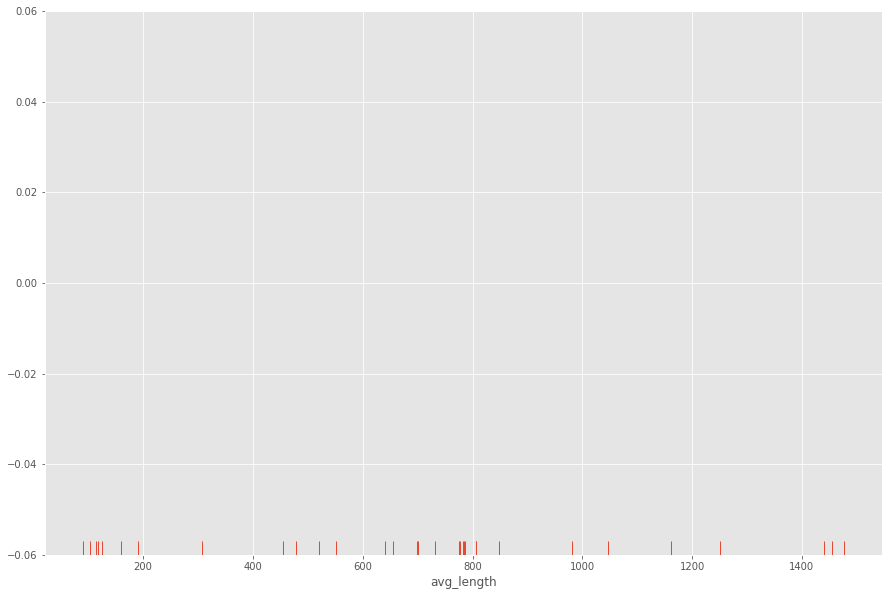

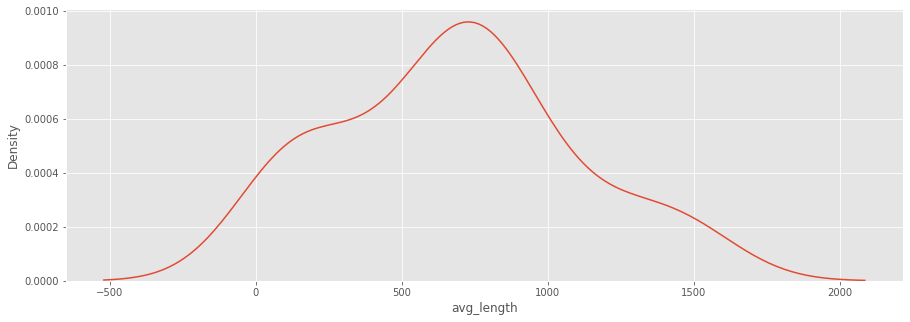

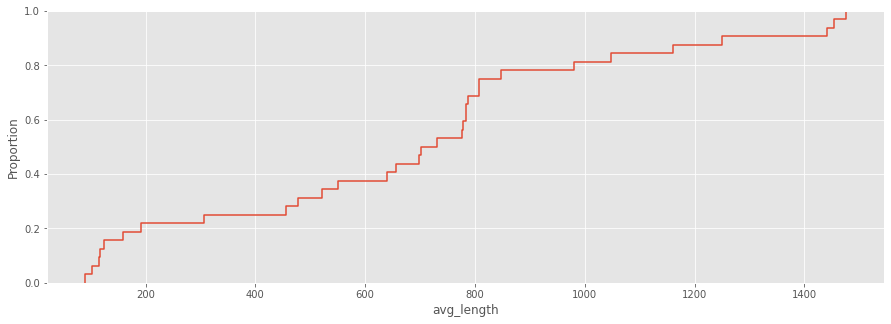

In [76]:
khoi8406.plot()

### Observations

In [77]:
df = khoi8406.df
limit = 500

In [78]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[3])

2     d√¢n oan d∆∞∆°ng n·ªôi bi·ªÉu t√¨nh tr∆∞·ªõc ƒë·∫°i s·ª© qu√°n ...
23    H·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG\n\nYOUTUBE....
24    H√†ng tri·ªáu ng∆∞·ªùi ƒë√£ b·ªè m·∫°ng trong th·∫£m h·ªça thu...
27    M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !ƒê·∫°i H·ªçc B...
36    ‚Äúƒê·ª´ng t·ª± h√†o v√¨ n∆∞·ªõc Vi·ªát Nam ngh√®o nh∆∞ng c√≥ l...
37    GDATA.YOUTUBE.COM\nNhat Ky Yeu Nuoc - T√¨nh H√¨n...
39    B·∫•t H·ªßNh·ªØng C√¢u N√≥i B·∫•t H·ªßT√¥i v·∫´n v√†o ƒë∆∞·ª£c FB ...
40    DANLAMBAO1.WORDPRESS.COM\nKh·ªëi 8406: Tuy√™n b·ªë ...
42    Tri·ªáu Ng∆∞·ªùi Vi·ªát Y√™u N∆∞·ªõc Xu·ªëng ƒê∆∞·ªùng ƒê√≤i T·ª± D...
45    Kh·ªëi 8406 l√† m·ªôt t·∫≠p h·ª£p nh·ªØng C√¥ng d√¢n Vi·ªát N...
Name: content, dtype: object
--------------------



M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !ƒê·∫°i H·ªçc B√°ch Khoa H√† N·ªôiH·ªòI NH·ªÆNG NG∆Ø·ªúI GH√âT B·ªåN PH·∫¢N ƒê·ªòNG

Nh·∫≠t k√Ω y√™u n∆∞·ªõc is with Joe Cao and 24 others.
18 April 2011 at 16:57 ¬∑

M·ªùi c√°c b·∫°n cho √Ω ki·

In [79]:
limit = 1000

In [80]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

5     L·ªúI K√äU G·ªåI BI·ªÇU T√åNH CH·ªêNG TRUNG QU·ªêC X√ÇM L∆Ø·ª¢...
10    B√ç ·∫®N NH·ªÆNG V·ª§ T·ª∞ S√ÅT T·∫¨P TH·ªÇ C·ª¶A LO√ÄI V·∫¨T\n\n...
12    Xu·ªëng ƒë∆∞·ªùng nh·∫±m gi√°o d·ª•c tinh th·∫ßn y√™u n∆∞·ªõc c...
16    V·ª• B·∫£n, Nam ƒê·ªãnh: c∆∞·ªõp ƒë·∫•t, ƒë√°nh d√¢n t√†n b·∫°o\n...
20    M·ªôt tuy√™n b·ªë chung d√†i 3208 ch·ªØ c√≥ th·ªÉ ƒë∆∞·ª£c t√≥...
26    M·∫∂T TR·∫¨N THANH NI√äN CH·ªêNG PH·∫¢N ƒê·ªòNG !H·ªòI NH·ªÆNG...
Name: content, dtype: object
--------------------



L·ªúI K√äU G·ªåI BI·ªÇU T√åNH CH·ªêNG TRUNG QU·ªêC X√ÇM L∆Ø·ª¢C NG√ÄY 9/12/2012

ƒê·ªãa ƒëi·ªÉm t·∫≠p k·∫øt: tr∆∞·ªõc c·ª≠a Nh√† H√°t L·ªõn - H√† N·ªôi. B·∫Øt ƒë·∫ßu l√∫c 9h.
Tu·∫ßn h√†nh ƒë·∫øn ƒê·∫°i S·ª© qu√°n Trung Qu·ªëc - s·ªë 46 ƒë∆∞·ªùng Ho√†ng Di·ªáu.

VIDEO V·ªöI L·ªúI K√äU G·ªåI:
http://www.youtube.com/watch?v=diMtYQlVSsw

Nh·∫≠t k√Ω y√™u n∆∞·ªõc is with Nguy·ªÖn Ho√†ng Vi and 34 others.
5 December 2012 at 12:52 ¬∑

‚ô•‚ô•‚ô•‚ô•‚ô•‚ô• S√†i G√≤n v√† H√† N·ªôi c√πng ƒë·ª©ng l√™n ‚ô•‚ô•‚ô•‚ô•‚ô•

### Run Preprocessing method

In [81]:
# 500 - 1000
# ...
khoi8406.preprocess()

Enter < limit:500
Enter > limit:1000


### Save

In [82]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa_fixed.csv		thanhnienconggiao.pickle
chantroimoi.pickle	 rfa.pickle		viettan.csv
giaochucchuvanan.pickle  sbtn.csv		viettan_fb.csv
khoi8406.pickle		 sbtn.pickle		viettan_fb.pickle
phamminhvu.pickle	 thanhnienconggiao.csv	viettan.pickle


In [83]:
khoi8406.df.iloc[1]['content']

'C√≥ qu√Ω v·ªã n√†o cho r·∫±ng bi·ªÉu t√¨nh ch·ªëng Trung Qu·ªëc "kh√¥ng h·ªÅ c√≥ t√°c d·ª•ng g√¨" th√¨ h√£y n√™n xem l·∫°i r·∫±ng: li·ªáu ph√°t bi·ªÉu ph·∫£n ƒë·ªëi Trung Qu·ªëc nh∆∞ nhai ƒëi nhai l·∫°i c·ªßa L∆∞∆°ng Thanh Ngh·ªã c√≥ ƒë∆∞·ª£c tr√≠ch d·∫´n, ƒëƒÉng t·∫£i nhi·ªÅu b·∫±ng h√¨nh ·∫£nh c·ªßa cu·ªôc bi·ªÉu t√¨nh ch·ªëng Trung Qu·ªëc v·ª´a qua kh√¥ng?\n\nTh·ªëng k√™ c√≥ th·∫•y ƒë√£ c√≥ √≠t nh·∫•t 10 h√£ng th√¥ng t·∫•n l·ªõn nh·∫•t th·∫ø gi·ªõi nh∆∞ AP, AFP, BBC, VOA, Al Jazeera, Euronews, Fox News, Yahoo!News, Washington Post, ABC, Guardian, DW ƒë√£ ƒëƒÉng t·∫£i th√¥ng tin v·ªÅ cu·ªôc bi·ªÉu t√¨nh ng√†y 09/12 (ch∆∞a k·ªÉ c√°c t·ªù b√°o nh·ªè ƒëƒÉng l·∫°i).\n\nCu·ªôc bi·ªÉu t√¨nh ƒë√£ ƒë·∫°t ƒë∆∞·ª£c m·ª•c ƒë√≠ch quan tr·ªçng l√† ƒë√°nh ƒë·ªông d∆∞ lu·∫≠n th·∫ø gi·ªõi v·ªÅ nh·ªØng g√¨ Trung Qu·ªëc ƒëang l√†m ·ªü Bi·ªÉn ƒê√¥ng.'

In [84]:
khoi8406.save_preprocess(os.getcwd() + "/khoi8406")

In [85]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## chantroimoi media

### Define new instances

In [86]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [87]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

chantroimoi = Dataframe('/1/' + 'chantroimoi_media.csv', 1)
print(chantroimoi.name)
chantroimoi.read_csv()

df = chantroimoi.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/chantroimoi_media.csv
df:        Unnamed: 0                                            content
0              0  EM CH·ªà MONG ‚ÄúM·ªåI VI·ªÜC S·∫º ·ªîN‚Äù TH√îI M√Ä ?\n\nVu K...
1              1  NH√Ä CHO C√îNG NH√ÇN QU√Å √çT!\n\nPh·∫°m Nh·∫≠t B√¨nh - ...
2              2  V√†i trao ƒë·ªïi c√πng ‚Äúb√°c c·∫£‚Äù Tr·ªçng... v·ªÅ "kinh t...
3              3  B·∫¶U C·ª¨ KI·ªÇU ·ªû VN X√É NGHƒ®A\n\nNguy·ªÖn Do√£n ƒê√¥n\n...
4              4  Nguy·ªÖn Ph√∫ Tr·ªçng v√† con ƒë∆∞·ªùng ti·∫øn l√™n x√£ h·ªôi ...
...          ...                                                ...
3917        3917  Tr·∫ßn Th·ªã Kim Anh\n¬∑\nV√† t·∫°i sao c√°c ƒë·∫£ng vi√™n ...
3918        3918  NgƒÉn ch·∫∑n k·∫ª ·ª©c hi·∫øp ·ªü Bi·ªÉn ƒê√¥ng\n\nGregory B....
3919        3919  R·∫≠p khu√¥n Trung Qu·ªëc, S√†i G√≤n l·∫Øp th√™m 10.000 ...
3920        3920  Lo cho ƒë·∫£ng vi√™n tr·∫ª b·ªã di·ªÖn bi·∫øn ho√† b√¨nh\n\n...
3921        3921  Trung Hoa M·ªông\n\nNg√¥ Nh·∫≠t ƒêƒÉng\n\nC√°c nh√† ph√¢...

[3922 rows x 2 col

content  label  avg_length
0     EM CH·ªà MONG ‚ÄúM·ªåI VI·ªÜC S·∫º ·ªîN‚Äù TH√îI M√Ä ?\n\nVu K...      1         704
1     NH√Ä CHO C√îNG NH√ÇN QU√Å √çT!\n\nPh·∫°m Nh·∫≠t B√¨nh - ...      1         704
2     V√†i trao ƒë·ªïi c√πng ‚Äúb√°c c·∫£‚Äù Tr·ªçng... v·ªÅ "kinh t...      1         818
3     B·∫¶U C·ª¨ KI·ªÇU ·ªû VN X√É NGHƒ®A\n\nNguy·ªÖn Do√£n ƒê√¥n\n...      1         704
4     Nguy·ªÖn Ph√∫ Tr·ªçng v√† con ƒë∆∞·ªùng ti·∫øn l√™n x√£ h·ªôi ...      1         697
...                                                 ...    ...         ...
3917  Tr·∫ßn Th·ªã Kim Anh\n¬∑\nV√† t·∫°i sao c√°c ƒë·∫£ng vi√™n ...      1         119
3918  NgƒÉn ch·∫∑n k·∫ª ·ª©c hi·∫øp ·ªü Bi·ªÉn ƒê√¥ng\n\nGregory B....      1         708
3919  R·∫≠p khu√¥n Trung Qu·ªëc, S√†i G√≤n l·∫Øp th√™m 10.000 ...      1         703
3920  Lo cho ƒë·∫£ng vi√™n tr·∫ª b·ªã di·ªÖn bi·∫øn ho√† b√¨nh\n\n...      1         703
3921  Trung Hoa M·ªông\n\nNg√¥ Nh·∫≠t ƒêƒÉng\n\nC√°c nh√† ph√¢...      1         705

[3919 rows x 3 columns]

### Content Filter

In [88]:
temp = df[df['content'].str.contains("VN|CS|Vi·ªát Nam|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c|ch√≠nh tr·ªã|t·∫ßm ph√†o|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(chantroimoi.name)
chantroimoi.df = temp
chantroimoi.df

/1/chantroimoi_media.csv


content  label  avg_length
1     NH√Ä CHO C√îNG NH√ÇN QU√Å √çT!\n\nPh·∫°m Nh·∫≠t B√¨nh - ...      1         704
2     V√†i trao ƒë·ªïi c√πng ‚Äúb√°c c·∫£‚Äù Tr·ªçng... v·ªÅ "kinh t...      1         818
3     B·∫¶U C·ª¨ KI·ªÇU ·ªû VN X√É NGHƒ®A\n\nNguy·ªÖn Do√£n ƒê√¥n\n...      1         704
4     Nguy·ªÖn Ph√∫ Tr·ªçng v√† con ƒë∆∞·ªùng ti·∫øn l√™n x√£ h·ªôi ...      1         697
5     B·∫¶U\n\nNguy·ªÖn Th√¥ng\n\nC·ª© nh∆∞ tivi b√°o ch√≠ tru...      1         678
...                                                 ...    ...         ...
3917  Tr·∫ßn Th·ªã Kim Anh\n¬∑\nV√† t·∫°i sao c√°c ƒë·∫£ng vi√™n ...      1         119
3918  NgƒÉn ch·∫∑n k·∫ª ·ª©c hi·∫øp ·ªü Bi·ªÉn ƒê√¥ng\n\nGregory B....      1         708
3919  R·∫≠p khu√¥n Trung Qu·ªëc, S√†i G√≤n l·∫Øp th√™m 10.000 ...      1         703
3920  Lo cho ƒë·∫£ng vi√™n tr·∫ª b·ªã di·ªÖn bi·∫øn ho√† b√¨nh\n\n...      1         703
3921  Trung Hoa M·ªông\n\nNg√¥ Nh·∫≠t ƒêƒÉng\n\nC√°c nh√† ph√¢...      1         705

[3359 rows x 3 columns]

In [89]:
print(chantroimoi.df['content'].iloc[10])

‚ÄòT√†o lao Vi·ªát Nam‚Äô: C√¢u chuy·ªán nhi·ªÅu t·∫≠p‚ÄòT√†o lao Vi·ªát Nam‚Äô: C√¢u chuy·ªán nhi·ªÅu t·∫≠p

Ho√†ng Tr∆∞·ªùng (G·ªüi VOA t·ª´ S√†i G√≤n)

T·ª´ tuy√™n b·ªë c·ªßa Ch·ªß t·ªãch n∆∞·ªõc, T·ªïng b√≠ th∆∞ ƒë·∫øn c√°c ph√°t bi·ªÉu c·ªßa Th·ªß t∆∞·ªõng, k√®m theo ƒë√≥ l√† nh·ªØng ch·ªß tr∆∞∆°ng tr√°i kho√°y‚Ä¶ con d√¢n n∆∞·ªõc Vi·ªát h√†ng ng√†y h√†ng gi·ªù ph·∫£i ch·ª©ng ki·∫øn bi·∫øt bao ƒëi·ªÅu t·∫ßm ph√†o v√† s√°o r·ªóng.

Tuy√™n b·ªë c·ªßa Nguy·ªÖn Xu√¢n Ph√∫c

√îng Nguy·ªÖn Xu√¢n Ph√∫c c√≥ l·∫Ω l√† nguy√™n th·ªß hi·∫øm hoi trong l·ªãch s·ª≠ n∆∞·ªõc nh√†, v√¨ ƒë√£ ƒë·ªÉ l·∫°i nh·ªØng ph√°t ng√¥n ‚Äúc√≥ c√°nh‚Äù. T·ª´ c√°ch g·ªçi t·∫Øt 4 n∆∞·ªõc ASEAN l√† ‚Äúc·ªù-l·ªù-m·ªù-v·ªù‚Äù h·ªìi ƒë·ª©ng ƒë·∫ßu c√°i n·ªôi c√°c c·ªßa ‚Äúh·∫≠u Ba A-T√≠‚Äù (Y-T√° Nguy·ªÖn T·∫•n D≈©ng) cho ƒë·∫øn tuy√™n b·ªë m·ªõi ƒë√¢y nh·∫•t v·ªÅ m·ªôt n·ªÅn ‚Äúd√¢n ch·ªß t√†o lao‚Äù n√†o ƒë√≥. Trong tuy√™n b·ªë ng·∫Øn ng·ªßn ‚Äúƒê·∫£ng lu√¥n xem tr·ªçng √Ω ki·∫øn‚Ä¶


In [90]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[-10])

ViÃÄ c√¢Ã£u laÃÄ ... haÃÄng th√¢Ã£t!

Thach Vu

C√¢Ã£u chiÃâ m∆°ÃÅi 21 tu√¥Ãâi ...

C√¢Ã£u kh√¥ng bi√™ÃÅt 29 ngoaÃ£i ng∆∞ÃÉ ...

C√¢Ã£u kh√¥ng bi√™ÃÅt caÃÅch nung gaÃ£ch s∆∞∆°Ãâi muÃÄa ƒë√¥ng ...

C√¢Ã£u kh√¥ng bi√™ÃÅt laÃÄm th∆° hay m∆∞∆°Ã£n th∆° trong tuÃÄ ...

C√¢Ã£u kh√¥ng coÃÅ buÃÅt hi√™Ã£u naÃÄo khaÃÅc ƒë√™Ãâ vi√™ÃÅt v√™ÃÄ HoaÃÄng Chi Phong ...

C√¢Ã£u kh√¥ng che gi√¢ÃÅu daÃÅng veÃâ "mƒÉÃ£t d∆°i moÃÉm chu√¥Ã£t" cuÃâa miÃÄnh ...

Th√™ÃÅ maÃÄ caÃâ th√™ÃÅ gi∆°ÃÅi n√™Ãâ phuÃ£c, y√™u quiÃÅ c√¢Ã£u.

ViÃÄ hoÃ£ bi√™ÃÅt c√¢Ã£u laÃÄ ... haÃÄng th√¢Ã£t!


### Plot distribution

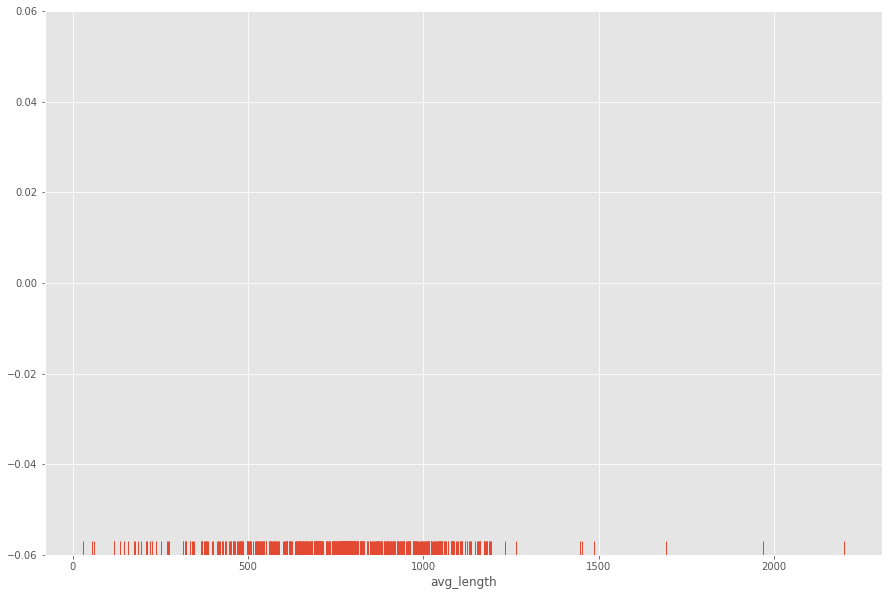

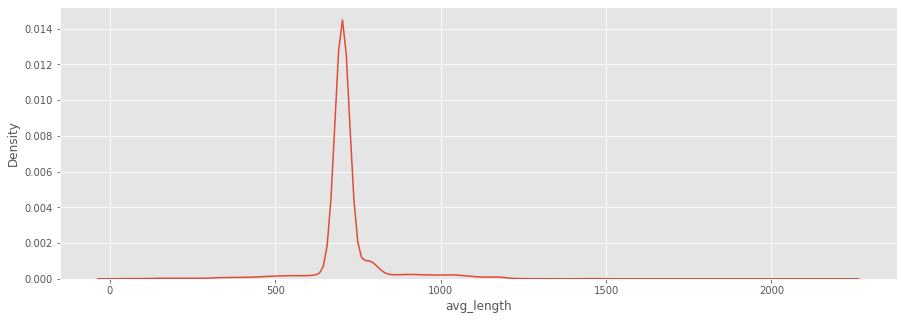

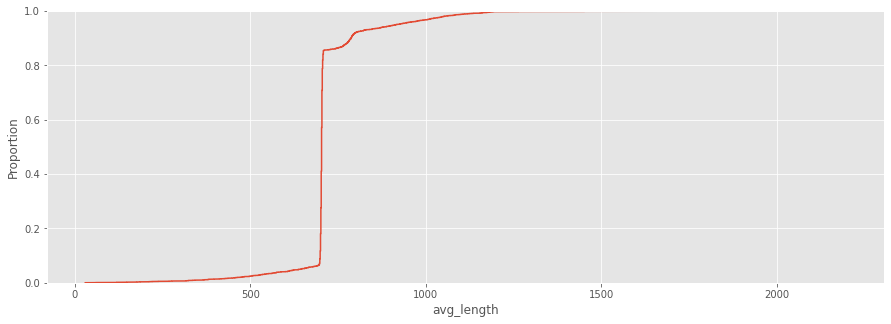

In [91]:
chantroimoi.plot()

### Observations

In [92]:
df = chantroimoi.df
limit = 450

In [93]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[4])

80      Chuy·ªán r√°c ·ªü Vi·ªát Nam: Quan ch·ª©c ƒÉn r√°c, nh√¢n ...
144     Tuy√™n C√°o c·ªßa C·ªông ƒê·ªìng Ng∆∞·ªùi Vi·ªát T·ª± Do Li√™n ...
250     N·∫øu sau nƒÉm 1975, thay v√¨ ƒë√°nh t∆∞ s·∫£n, ng∆∞·ªùi t...
341     Ki·∫øn th·ª©c c·∫ßn chia s·∫ª g·∫•p:\n\nƒê·ªÉ c√¥ng an, an n...
567     B√† Aung San Suu Kyi, kh√¥i nguy√™n gi·∫£i Nobel H√≤...
674     Ad h·ªèi th·∫≠t c√°c b·∫°n d∆∞ lu·∫≠n vi√™n, ak47, c√¥ng a...
783     BI·∫æN C·ªê ƒê·ªíNG T√ÇM: NH·ªÆNG S·ª∞ TH·∫¨T C·∫¶N TO√ÄN D√ÇN N...
1028    H√£y xem h√¨nh\n\nhttps://www.facebook.com/photo...
1124    √îng n√†o so s√°nh th·∫ø n√†y l√† ch·∫≥ng hi·ªÉu g√¨ v·ªÅ ƒëi...
1127    Ch√¢n Tr·ªùi M·ªõi Media k√≠nh ch√∫c Qu√Ω V·ªã v√† Gia ƒê√¨...
1167    Ch·ªâ 5 tri·ªáu ng∆∞·ªùi y√™u c·ªông s·∫£n chuy√™n ch√≠nh, ƒê...
1202    T√π nh√¢n l∆∞∆°ng t√¢m Tr·∫ßn Hu·ª≥nh Duy Th·ª©c ng·ª´ng tu...
1219    C√°c ph√¢n t√≠ch gia ch√≠nh tr·ªã: nh·ªØng m·ªëi quan t√¢...
1250    B√°nh v·∫Ω c·ªßa ƒë·∫£ng CSVN d√†nh cho nh√¢n d√¢n\nH√¨nh:...
1388    √î. L√Ω 

In [94]:
limit = 1500

In [95]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

212    30.4: NGHƒ® V·ªÄ PH·∫®M CH·∫§T ANH H√ôNG C·ª¶A NG√ÄNH GI√Å...
484    GIA ƒê√åNH C√îNG D√ÇN √öC CH√ÇU VƒÇN KH·∫¢M LO S·ª¢ CHO A...
735    C√ì PH·∫¢I M·ªòT ‚ÄúM√ôA XU√ÇN ƒê√îNG √Å‚Äù ƒêANG DI·ªÑN RA?\n\...
Name: content, dtype: object
--------------------



30.4: NGHƒ® V·ªÄ PH·∫®M CH·∫§T ANH H√ôNG C·ª¶A NG√ÄNH GI√ÅO

Chu M·ªông Long

Th√°ng tr∆∞·ªõc, khi t√¥i ƒë√≥ng c·ª≠a FB ƒë·ªÉ luy·ªán c√¥ng th√¨ nghe ·∫ßm ƒ© trong gi·ªõi giang h·ªì v·ªÅ m·ªôt s·ª± ki·ªán tr·ªçng ƒë·∫°i ·ªü Tr∆∞·ªùng Ti·ªÉu h·ªçc S√†i S∆°n B, Qu·ªëc Oai, H√† N·ªôi. H·ªçc sinh l·ªõp 5 m√† d√°m t·∫•n c√¥ng c√¥ gi√°o ngay t·∫°i l·ªõp h·ªçc l√† chuy·ªán x∆∞a nay ch∆∞a t·ª´ng c√≥. Th∆∞·ªùng h·ªçc sinh ti·ªÉu h·ªçc s·ª£ c√¥ gi√°o h∆°n s·ª£ c·ªçp. Ai kh√¥ng tin th√¨ th·ª≠ xem. M·ªôt ƒë·ª©a b√© h∆∞ h·ªèng, l√¨ l·ª£m nh·∫•t ng∆∞·ªùi l·ªõn n√≥i kh√¥ng nghe, ch·ªâ c·∫ßn b·∫Øt m√°y do·∫° g·ªçi cho c√¥ gi√°o l√† n√≥ h·∫øt h·ªìn.

V·∫≠y th√¨ ch·ªâ c√≥ th·ªÉ c√¥ gi√°o Tu·∫•t thu·ªôc th·∫ø l·ª±c th√π ƒë·ªãch, ph·∫£n ƒë·ªông, 

### Run Preprocessing method

In [96]:
# 450 - 1500
# ...
chantroimoi.preprocess()

Enter < limit:450
Enter > limit:1500


### Save

In [97]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 rfa_fixed.csv		   viettan.csv
chantroimoi.pickle	 rfa.pickle		   viettan_fb.csv
giaochucchuvanan.pickle  sbtn.csv		   viettan_fb.pickle
khoi8406.csv		 sbtn.pickle		   viettan.pickle
khoi8406.pickle		 thanhnienconggiao.csv
phamminhvu.pickle	 thanhnienconggiao.pickle


In [98]:
chantroimoi.df.iloc[1]['content']

'V√†i trao ƒë·ªïi c√πng ‚Äúb√°c c·∫£‚Äù Tr·ªçng... v·ªÅ "kinh t·∫ø th·ªã tr∆∞·ªùng ƒë·ªãnh h∆∞·ªõng XHCN"\n\nB√†i vi·∫øt v·ªõi nhan ƒë·ªÅ ‚ÄòM·ªôt s·ªë v·∫•n ƒë·ªÅ l√Ω lu·∫≠n v√† th·ª±c ti·ªÖn v·ªÅ ch·ªß nghƒ©a x√£ h·ªôi v√† con ƒë∆∞·ªùng ƒëi l√™n ch·ªß nghƒ©a x√£ h·ªôi ·ªü Vi·ªát Nam‚Äô c·ªßa T·ªïng B√≠ th∆∞ ƒê·∫£ng c·ªông s·∫£n Vi·ªát Nam Nguy·ªÖn Ph√∫ Tr·ªçng ƒë√£ b·ªã nhi·ªÅu √Ω ki·∫øn ph·∫£n b√°c.\nT√°c gi√† L∆∞u tr·ªçng VƒÉn ƒë·∫∑c bi·ªát ch√∫ √Ω ƒë·∫øn ph·∫ßn √¥ng Tr·ªçng n√≥i v·ªÅ kinh t·∫ø th·ªã tr∆∞·ªùng ƒë·ªãnh h∆∞·ªõng XHCN.\n\nB√†i \'V√†i trao ƒë·ªïi c√πng ‚Äúb√°c c·∫£‚Äù Tr·ªçng\' - L∆∞u Tr·ªçng VƒÉn\n\n#Vi·ªátT√¢n #Nguy·ªÖnPh√∫Tr·ªçng\n\nN·∫øu kh√¥ng xem ƒë∆∞·ª£c tr√™n YouTube, b·∫°n c√≥ th·ªÉ v√†o link n√†y ƒë·ªÉ xem: \nDO YOUTUBE B·ªä NH√Ä C·∫¶M QUY·ªÄN CSVN √ÅP L·ª∞C NGƒÇN CH·∫∂N M·ªòT C√ÅCH B·∫§T H·ª¢P PH√ÅP KH√îNG CHO NHI·ªÄU VIDEO C·ª¶A VI·ªÜT T√ÇN ƒê∆Ø·ª¢C XEM ·ªû VI·ªÜT NAM\n\nVIMEO.COM\nV√†i trao ƒë·ªïi c√πng ‚Äúb√°c c·∫£‚Äù Tr·ªçng v·ªÅ "kinh t·∫ø th·ªã tr∆∞·ªù

In [99]:
chantroimoi.save_preprocess(os.getcwd() + "/chantroimoi")

In [100]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## BPSOS

### Define new instances

In [101]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [102]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

bpsos = Dataframe('/1/' + 'bpsos.csv', 1)
print(bpsos.name)
bpsos.read_csv()

df = bpsos.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/bpsos.csv
df:        Unnamed: 0                                            content
0              0  Theo c√°c ƒë·∫°i di·ªán c·ªßa c∆∞ d√¢n Ti·ªÉu Khu 179, ch√≠...
1              1  Trong cu·ªôc b·∫ßu c·ª≠ ng√†y 23 th√°ng 5 nƒÉm 2021 v·ª´a...
2              2  M·ªòT CU·ªòC BI·ªÇU T√åNH ƒê∆Ø·ª¢C COI L√Ä H·ª¢P PH√ÅP T·∫†I VI...
3              3  \n\nBPSOS - Vietnam Advocacy Project\n20 mei o...
4              4  G·∫ßn ƒë√¢y, nhi·ªÅu c√° nh√¢n, t·ªï ch·ª©c b·∫£o v·ªá nh√¢n qu...
...          ...                                                ...
1384        1384  https://news.zing.vn/bi-cong-an-phuong-moi-len...
1385        1385  Trong th·ªùi gian qua, th√†nh vi√™n H·ªôi C·ªù ƒê·ªè ƒë√£ c...
1386        1386  Trong m·ªôt v·ª• ki·ªán d√¢n s·ª±, to√† √°n ƒë√≤i h·ªèi nguy√™...
1387        1387  http://www.tinmungchonguoingheo.com/blog/2018/...
1388        1388  D∆∞·ªõi ƒë√¢y l√† h∆∞·ªõng d·∫´n v·ªÅ c√°ch ·ª©ng x·ª≠ khi nh·∫≠n ...

[1389 rows x 2 columns]


content  label  avg_length
0     Theo c√°c ƒë·∫°i di·ªán c·ªßa c∆∞ d√¢n Ti·ªÉu Khu 179, ch√≠...      1        3085
1     Trong cu·ªôc b·∫ßu c·ª≠ ng√†y 23 th√°ng 5 nƒÉm 2021 v·ª´a...      1        1882
2     M·ªòT CU·ªòC BI·ªÇU T√åNH ƒê∆Ø·ª¢C COI L√Ä H·ª¢P PH√ÅP T·∫†I VI...      1        1406
3     \n\nBPSOS - Vietnam Advocacy Project\n20 mei o...      1        2297
4     G·∫ßn ƒë√¢y, nhi·ªÅu c√° nh√¢n, t·ªï ch·ª©c b·∫£o v·ªá nh√¢n qu...      1        1606
...                                                 ...    ...         ...
1384  https://news.zing.vn/bi-cong-an-phuong-moi-len...      1         528
1385  Trong th·ªùi gian qua, th√†nh vi√™n H·ªôi C·ªù ƒê·ªè ƒë√£ c...      1        1425
1386  Trong m·ªôt v·ª• ki·ªán d√¢n s·ª±, to√† √°n ƒë√≤i h·ªèi nguy√™...      1        1425
1387  http://www.tinmungchonguoingheo.com/blog/2018/...      1         457
1388  D∆∞·ªõi ƒë√¢y l√† h∆∞·ªõng d·∫´n v·ªÅ c√°ch ·ª©ng x·ª≠ khi nh·∫≠n ...      1        1425

[1387 rows x 3 columns]

### Content Filter

In [103]:
temp = df[df['content'].str.contains("VN|CS|Vi·ªát Nam|ch√≠nh ph·ªß|c√¥ng an|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|" + 
        "ch·ªß t·ªãch|c∆∞·ªõp|trung ∆∞∆°ng|l√£nh ƒë·∫°o|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|l·ª±c l∆∞·ª£ng|quan ch·ª©c|ch√≠nh tr·ªã|t·∫ßm ph√†o|ch√≠nh quy·ªÅn|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(bpsos.name)
bpsos.df = temp
bpsos.df

/1/bpsos.csv


content  label  avg_length
0     Theo c√°c ƒë·∫°i di·ªán c·ªßa c∆∞ d√¢n Ti·ªÉu Khu 179, ch√≠...      1        3085
1     Trong cu·ªôc b·∫ßu c·ª≠ ng√†y 23 th√°ng 5 nƒÉm 2021 v·ª´a...      1        1882
2     M·ªòT CU·ªòC BI·ªÇU T√åNH ƒê∆Ø·ª¢C COI L√Ä H·ª¢P PH√ÅP T·∫†I VI...      1        1406
3     \n\nBPSOS - Vietnam Advocacy Project\n20 mei o...      1        2297
4     G·∫ßn ƒë√¢y, nhi·ªÅu c√° nh√¢n, t·ªï ch·ª©c b·∫£o v·ªá nh√¢n qu...      1        1606
...                                                 ...    ...         ...
1381  \n\nV√µ An ƒê√¥n\n22 oktober 2018 om 09:29 ¬∑\nH√íA...      1        2252
1384  https://news.zing.vn/bi-cong-an-phuong-moi-len...      1         528
1385  Trong th·ªùi gian qua, th√†nh vi√™n H·ªôi C·ªù ƒê·ªè ƒë√£ c...      1        1425
1387  http://www.tinmungchonguoingheo.com/blog/2018/...      1         457
1388  D∆∞·ªõi ƒë√¢y l√† h∆∞·ªõng d·∫´n v·ªÅ c√°ch ·ª©ng x·ª≠ khi nh·∫≠n ...      1        1425

[1126 rows x 3 columns]

In [104]:
for post in bpsos.df['content'].iloc[:30]:
    print(post)
    print("---------------------")
# print(bpsos.df['content'].iloc[:-1])

Theo c√°c ƒë·∫°i di·ªán c·ªßa c∆∞ d√¢n Ti·ªÉu Khu 179, ch√≠nh quy·ªÅn huy·ªán s·∫Ω c·∫•p th·∫ª cƒÉn c∆∞·ªõc c√¥ng d√¢n v√†o th√°ng 7 n√†y, v√† c≈©ng th√°ng 7 n√†y s·∫Ω tri·ªÉn khai c√°c d·ª± √°n x√¢y d·ª±ng h·∫° t·∫ßng c∆° s·ªü bao g·ªìm ƒë∆∞·ªùng x√°, tr·∫°m x√° y t·∫ø, nh√†‚Ä¶ Meer tr·∫ª, s√¢n ch∆°i, v√† trung t√¢m c·ªông ƒë·ªìng. ƒê·∫ßu th√°ng 3 v·ª´a qua, Qu√¢n Khu 7 c·ª≠ 2 gi√°o vi√™n b√¨nh d√¢n h·ªçc v·ª• ƒë·ªÉ d·∫°y ƒë·ªçc v√† vi·∫øt cho c√°c ng∆∞·ªùi Hmong ch∆∞a t·ª´ng ƒë·∫øn tr∆∞·ªùng. Hi·ªán c√≥ tr√™n 40 h·ªçc vi√™n theo h·ªçc.

Theo c√°c ƒë·∫°i di·ªán c·ªßa c∆∞ d√¢n Ti·ªÉu Khu 179, ch√≠nh quy·ªÅn huy·ªán s·∫Ω c·∫•p th·∫ª cƒÉn c∆∞·ªõc c√¥ng d√¢n v√†o th√°ng 7 n√†y, v√† c≈©ng th√°ng 7 n√†y s·∫Ω tri·ªÉn khai c√°c d·ª± √°n x√¢y d·ª±ng h·∫° t·∫ßng c∆° s·ªü bao g·ªìm ƒë∆∞·ªùng x√°, tr·∫°m x√° y t·∫ø, nh√†Meer tr·∫ª, s√¢n ch∆°i, v√† trung t√¢m c·ªông ƒë·ªìng. ƒê·∫ßu th√°ng 3 v·ª´a qua, Qu√¢n Khu 7 c·ª≠ 2 gi√°o vi√™n b√¨nh d√¢n h·ªçc v·ª• ƒë·ªÉ d·∫°y ƒë·ªçc v√† vi·∫øt cho c√°c ng∆∞·

In [105]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'])

12           \n\nDVOV.ORG\ndvov.org\n\nDVOV.ORG\ndvov.org
25      Ng∆∞·ªùi M·ªπ g·ªëc Vi·ªát tr∆∞·ªõc n·∫°n k·ª≥ th·ªã d√¢n √Å Ch√¢u\...
38      QUY·ªÄN C·ª¶A NG∆Ø·ªúI B·ªä THI·ªÜT H·∫†I DO TAI N·∫†N GIAO T...
42      N∆†I C∆Ø TR√ö C·ª¶A NH√Ä TU H√ÄNH THEO LU·∫¨T C∆Ø TR√ö M·ªö...
48      SAU NG√ÄY 1 TH√ÅNG 7 NƒÇM 2021 S·∫º KH√îNG C·∫¶N ƒê·∫æN S...
                              ...                        
1375    Lus Hmoob, the first in a series of three vide...
1376    \n\nƒê√¥n An V√µ is met V√µ An ƒê√¥n en TH√çCH THI·ªÜN ...
1379    This video, the first in a series of three vid...
1382    This video in Vietnamese language describes ho...
1386    Trong m·ªôt v·ª• ki·ªán d√¢n s·ª±, to√† √°n ƒë√≤i h·ªèi nguy√™...
Name: content, Length: 249, dtype: object


### Plot distribution

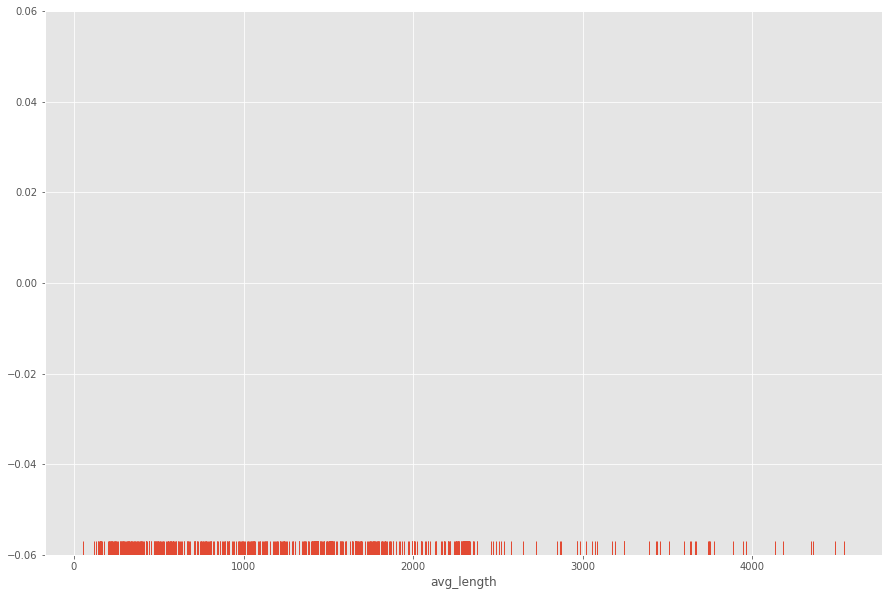

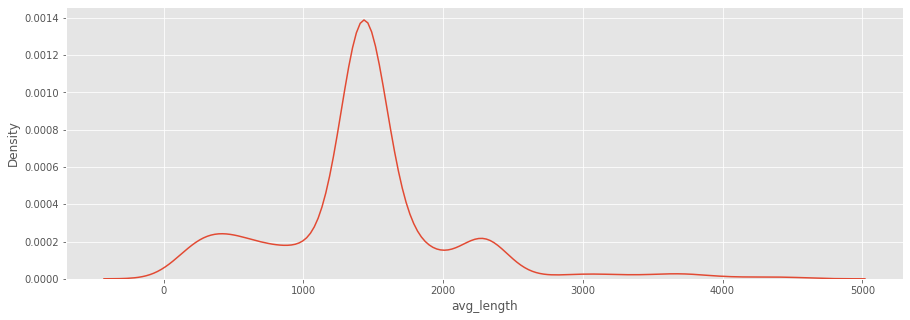

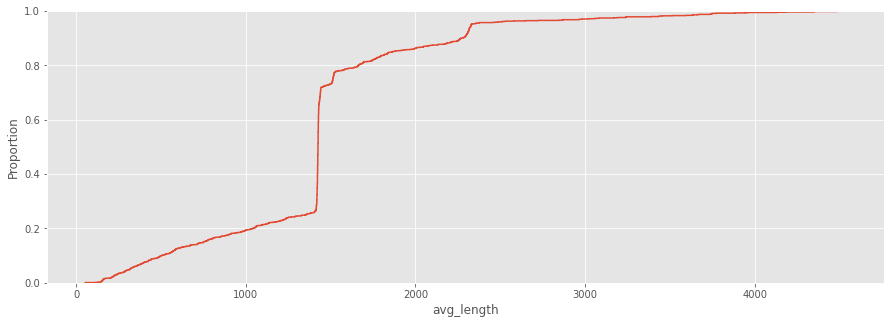

In [106]:
bpsos.plot()

### Observations

In [107]:
df = bpsos.df
limit = 1000

In [108]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

6       TAND t·ªânh Kh√°nh H√≤a ƒë√£ ƒë∆∞a ra x√©t x·ª≠ s∆° th·∫©m v...
28      Lu·∫≠t b·∫£o v·ªá b√≠ m·∫≠t nh√† n∆∞·ªõc\nSau Video ‚ÄúQuy·∫øt ...
55      Nh·ªØng ƒëi·ªÉm c·∫ßn l∆∞u √Ω trong Ngh·ªã ƒë·ªãnh 162/2017/...
67      TS Nguy·ªÖn ƒê√¨nh Th·∫Øng ph√°t bi·ªÉu t·∫°i H·ªôi ƒê·ªìng Nh...
84      \n\nBPSOS - ƒê·ªÅ √Ån D√¢n Quy·ªÅn Vi·ªát Nam heeft het...
                              ...                        
1372    https://tuoitre.vn/lam-gi-khi-cong-an-trieu-ta...
1374    ƒê√¢y l√† video th·ª© 2 v·ªÅ t√¨nh tr·∫°ng ‚Äúv√¥ t·ªï qu·ªëc‚Äù ...
1377    https://www.vncrp.org/hmong-statelessness-proj...
1384    https://news.zing.vn/bi-cong-an-phuong-moi-len...
1387    http://www.tinmungchonguoingheo.com/blog/2018/...
Name: content, Length: 218, dtype: object
--------------------





In [109]:
for post in df[df['avg_length'] < limit ]['content']:
    print(post)
    print('-----------------------')

TAND t·ªânh Kh√°nh H√≤a ƒë√£ ƒë∆∞a ra x√©t x·ª≠ s∆° th·∫©m v·ª• √°n √¥ng Nguy·ªÖn VƒÉn B√¨nh (ng·ª• t·∫°i TP Nha Trang) kh·ªüi ki·ªán Ch·ªß t·ªãch UBND t·ªânh Kh√°nh H√≤a v·ªÅ vi·ªác t·ª´ ch·ªëi cung c·∫•p gi·∫•y ch·ª©ng nh·∫≠n ƒë·∫ßu t∆∞ s√¢n golf do UBND t·ªânh ƒë√£ c·∫•p cho C√¥ng ty TNHH Ho√†n C·∫ßu t·∫°i d·ª± √°n khu du l·ªãch v√† gi·∫£i tr√≠ S√¥ng L√¥, TP Nha Trang trong ng√†y 4-5/5/2021.

TAND t·ªânh Kh√°nh H√≤a ƒë√£ ƒë∆∞a ra x√©t x·ª≠ s∆° th·∫©m v·ª• √°n √¥ng Nguy·ªÖn VƒÉn B√¨nh (ng·ª• t·∫°i TP Nha Trang) kh·ªüi ki·ªán Ch·ªß t·ªãch UBND t·ªânh Kh√°nh H√≤a v·ªÅ vi·ªác t·ª´ ch·ªëi cung c·∫•p gi·∫•y ch·ª©ng nh·∫≠n ƒë·∫ßu t∆∞ s√¢n golf do UBND t·ªânh ƒë√£ c·∫•p cho C√¥ng ty TNHH Ho√†n C·∫ßu t·∫°i d·ª± √°n khu du l·ªãch v√† gi·∫£i tr√≠ S√¥ng L√¥, TP Nha Trang trong ng√†y 4-5/5/2021.

RFA.ORG
C√∫ h√≠ch m·ªõi cho vi·ªác th·ª±c thi quy·ªÅn ti·∫øp c·∫≠n th√¥ng tin?
V·ª• vi·ªác √¥ng Nguy·ªÖn VƒÉn B√¨nh ‚Äì m·ªôt ng∆∞·ªùi d√¢n ·ªü Nha Trang ki·ªán Ch·ªß t·ªãch ·ª¶y ban Nh√¢n d√¢n t·ªânh K

In [110]:
limit = 4000

In [111]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[-2])

175     Lu·∫≠t gia Nguy·ªÖn B·∫Øc Truy·ªÉn l√† m·ªôt nh√† ho·∫°t ƒë·ªôn...
262     T√≠n ƒë·ªì Ph·∫≠t Gi√°o H√≤a H·∫£o, lu·∫≠t gia Nguy·ªÖn B·∫Øc ...
299     NG∆Ø·ªúI C·ª¶A CHI PH√ÅI 1997 GI·ªû TH√ìI C√îN ƒê·ªí, VI PH...
992     Theo ƒë·ªãnh nghƒ©a c·ªßa b√°o l·ªÅ ƒë·∫£ng v·ªÅ t·ª± do t√¥n g...
1120    ƒê·ªÅ √Ån D√¢n Quy·ªÅn nh·∫≠n ƒë∆∞·ª£c ph·∫£n h·ªìi t·ª´ b·∫°n ƒë·ªçc ...
1168    K√≠nh ch√†o qu√Ω anh ch·ªã,\nTrong qu√° tr√¨nh Livest...
Name: content, dtype: object
--------------------



ƒê·ªÅ √Ån D√¢n Quy·ªÅn nh·∫≠n ƒë∆∞·ª£c ph·∫£n h·ªìi t·ª´ b·∫°n ƒë·ªçc trong n∆∞·ªõc l√† b√†i "Th√¢n ph·∫≠n Nghi·ªáp ƒëo√†n ƒê·ªôc l·∫≠p ·ªü Vi·ªát Nam" tr√™n trang Ti·∫øng D√¢n ƒë√£ b·ªã ch·∫∑n. Do ƒë√≥ ch√∫ng t√¥i xin ƒë∆∞·ª£c ch√©p l·∫°i d∆∞·ªõi ƒë√¢y ƒë·ªÉ ti·ªán cho c√°c b·∫°n ƒë·ªçc.
‚Ä¶ Meer ---------------------------------------------
Ngu·ªìn: B√°o Ti·∫øng D√¢n, ng√†y 2-5-2019.
https://baotiengdan.com/2019/05/02/than-phan-nghiep-doan-doc-lap-o-viet-nam
T√°c gi·∫£: Ph·∫°m Tr·∫ßn
D·ª± lu·∫≠t La

### Run Preprocessing method

In [112]:
# 1000 - 4000
# ...
bpsos.preprocess()

Enter < limit:1000
Enter > limit:4000


### Save

In [113]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.pickle		 phamminhvu.pickle	thanhnienconggiao.pickle
chantroimoi.csv		 rfa_fixed.csv		viettan.csv
chantroimoi.pickle	 rfa.pickle		viettan_fb.csv
giaochucchuvanan.pickle  sbtn.csv		viettan_fb.pickle
khoi8406.csv		 sbtn.pickle		viettan.pickle
khoi8406.pickle		 thanhnienconggiao.csv


In [114]:
bpsos.df.iloc[1]['content']

'Trong cu·ªôc b·∫ßu c·ª≠ ng√†y 23 th√°ng 5 nƒÉm 2021 v·ª´a qua, m·ªôt s·ªë ng∆∞·ªùi Vi·ªát Nam ƒë√£ ch·ªçn l·ª±a t·∫©y chay cu·ªôc b·∫ßu c·ª≠ nh∆∞ m·ªôt gi·∫£i ph√°p duy nh·∫•t ƒë·ªÉ ch·ªëi b·ªè s·ª± t·ªìn t·∫°i c·ªßa nh√† n∆∞·ªõc Vi·ªát Nam hi·ªán h√†nh. ƒê√¢y l√† m·ªôt c√°ch bi·ªÉu‚Ä¶ Meer ƒë·∫°t trong m·ªôt tr·∫°ng th√°i b·∫•t l·ª±c v√¨ kh√¥ng bi·∫øt l√†m g√¨ h∆°n.\nB√†i vi·∫øt n√†y mong ƒë∆∞·ª£c ƒë√≥ng g√≥p m·ªôt g√≥c nh√¨n kh√°c ƒë·ªÉ ƒë·ªôc gi·∫£ c√≥ r·ªông ƒë∆∞·ªùng d∆∞ lu√¢n. T·∫©y chay b·∫ßu c·ª≠ s·∫Ω kh√¥ng ƒë·∫°t ƒë∆∞·ª£c k·∫øt qu·∫£ g√¨ khi s·ªë ƒë√¥ng ng∆∞·ªùi d√¢n do ch·ªãu c√°c √°p l·ª±c kh√°c nhau n√™n v·∫´n ƒëi b·∫ßu c·ª≠ cho xong chuy·ªán. Do ƒë√≥, c·∫ßn ph·∫£i nghƒ© ƒë·∫øn k·∫ø s√°ch kh√°c ƒë·ªÉ c√≥ th·ªÉ ƒëem ƒë·∫øn nh·ªØng k·∫øt qu·∫£ mong mu·ªën m·ªôt c√°ch c·ª• th·ªÉ ch·ª© kh√¥ng th·ªÉ theo m·ªôt c√°ch l√†m c≈© m√† ch√∫ng ta v·ªën bi·∫øt s·∫Ω kh√¥ng ƒë·∫°t ƒë∆∞·ª£c m·ª•c ti√™u.\n\nTrong cu·ªôc b·∫ßu c·ª≠ ng√†y 23 th√°ng 5 nƒÉm 2021 v·ª´a qua, m·ªôt s·ªë ng∆∞·ªùi 

In [115]:
bpsos.save_preprocess(os.getcwd() + "/bpsos")

In [116]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## PhamMinhVu

### Define new instances

In [117]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [118]:
# viettan_ls = []

# for i in range(4):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     test.read_csv()
#     viettan_ls.append(test.df)

bpsos = Dataframe('/1/' + 'PhamMinhVuFBd.csv', 1)
print(bpsos.name)
bpsos.read_csv()

df = bpsos.df 
df

# viettan.df = pd.concat(viettan_ls)
# df = viettan.df

/1/PhamMinhVuFBd.csv
df:       Unnamed: 0                                            content
0             0  Trong khi c·∫£ th·∫ø gi·ªõi ƒëang d·∫ßn ƒë·∫©y l√πi ƒë∆∞·ª£c Vi...
1             1  Ng∆∞·ªùi Vi·ªát Nam t·ª´ khi n√†o l·∫°i t√†n nh·∫´n th·∫ø?\n\...
2             2  Tuy√™n gi√°o VN h√®n h·∫°!\n\nƒê√¢y l√† h√¨nh ·∫£nh c·ªßa h...
3             3  M·ªõi ƒë√¢y, ch√≠nh quy·ªÅn th√†nh ph·ªë Mungyeong, t·ªânh...
4             4  Hi·ªán nay, c·∫£ h·ªá th·ªëng tuy√™n gi√°o ƒëang ƒëƒÉng b√†i...
..          ...                                                ...
947         947                                 H·ªì Xu√¢n H∆∞∆°ng 1925
948         948  H·∫£i N√∫i Tr∆∞·ªùng TrƒÉm\nV·ªçng Non S∆°n NƒÉm\nNg√†n Na...
949         949  H√¥m nay l√™n ƒë·ªânh B√†n c·ªù, ƒë√°nh c·ªù v·ªõi l√£o gi√† k...
950         950  H√≥ng h·ªõt......\n\nCh·ªâ l√† ƒëi coi ng∆∞·ªùi ta c√¢u c...
951         951  ƒê·ª£i ƒë·∫øn ng√†y tr√πng d∆∞∆°ng\nV·∫´n c√≤n nguy√™n hoa c...

[952 rows x 2 columns]


content  label  avg_length
0    Trong khi c·∫£ th·∫ø gi·ªõi ƒëang d·∫ßn ƒë·∫©y l√πi ƒë∆∞·ª£c Vi...      1        3641
1    Ng∆∞·ªùi Vi·ªát Nam t·ª´ khi n√†o l·∫°i t√†n nh·∫´n th·∫ø?\n\...      1        2386
2    Tuy√™n gi√°o VN h√®n h·∫°!\n\nƒê√¢y l√† h√¨nh ·∫£nh c·ªßa h...      1        2011
3    M·ªõi ƒë√¢y, ch√≠nh quy·ªÅn th√†nh ph·ªë Mungyeong, t·ªânh...      1        2611
4    Hi·ªán nay, c·∫£ h·ªá th·ªëng tuy√™n gi√°o ƒëang ƒëƒÉng b√†i...      1        3963
..                                                 ...    ...         ...
947                                 H·ªì Xu√¢n H∆∞∆°ng 1925      1          18
948  H·∫£i N√∫i Tr∆∞·ªùng TrƒÉm\nV·ªçng Non S∆°n NƒÉm\nNg√†n Na...      1         127
949  H√¥m nay l√™n ƒë·ªânh B√†n c·ªù, ƒë√°nh c·ªù v·ªõi l√£o gi√† k...      1         235
950  H√≥ng h·ªõt......\n\nCh·ªâ l√† ƒëi coi ng∆∞·ªùi ta c√¢u c...      1          51
951  ƒê·ª£i ƒë·∫øn ng√†y tr√πng d∆∞∆°ng\nV·∫´n c√≤n nguy√™n hoa c...      1          50

[950 rows x 3 columns]

### Content Filter

In [119]:
temp = df[df['content'].str.contains("CS|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|c√¥ng an|" + 
        "quan ch·ª©c|c∆∞·ªõp|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|ch√≠nh tr·ªã|ch√≠nh quy·ªÅn|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(bpsos.name)
bpsos.df = temp
bpsos.df

/1/PhamMinhVuFBd.csv


content  label  avg_length
0    Trong khi c·∫£ th·∫ø gi·ªõi ƒëang d·∫ßn ƒë·∫©y l√πi ƒë∆∞·ª£c Vi...      1        3641
1    Ng∆∞·ªùi Vi·ªát Nam t·ª´ khi n√†o l·∫°i t√†n nh·∫´n th·∫ø?\n\...      1        2386
2    Tuy√™n gi√°o VN h√®n h·∫°!\n\nƒê√¢y l√† h√¨nh ·∫£nh c·ªßa h...      1        2011
3    M·ªõi ƒë√¢y, ch√≠nh quy·ªÅn th√†nh ph·ªë Mungyeong, t·ªânh...      1        2611
4    Hi·ªán nay, c·∫£ h·ªá th·ªëng tuy√™n gi√°o ƒëang ƒëƒÉng b√†i...      1        3963
..                                                 ...    ...         ...
936  L·ªëi S·ªëng ƒê√≥ L√† L·ªëi S·ªëng C·ªßa B·ªçn Ti·ªÉu T∆∞ S·∫£n, B...      1        2446
938  Chuy·ªán v·ªÅ m·ªôt Nghƒ©a Trang\n\nTrong m·ªôt l·∫ßn l√™n...      1        2565
942  T·∫£n m·∫°n v·ªÅ Sinh Nh·∫≠t L·∫ßn Th·ª© 5 C·ªßa H·ªôi Anh Em ...      1        6835
945                                  C√† ph√™ T√πng, 1967      1          17
949  H√¥m nay l√™n ƒë·ªânh B√†n c·ªù, ƒë√°nh c·ªù v·ªõi l√£o gi√† k...      1         235

[759 rows x 3 columns]

In [120]:
for post in bpsos.df['content'].iloc[:60]:
    print(post)
    print("---------------------")
# print(bpsos.df['content'].iloc[:-1])

Trong khi c·∫£ th·∫ø gi·ªõi ƒëang d·∫ßn ƒë·∫©y l√πi ƒë∆∞·ª£c Virus V.≈© H.√°n khi nh·ªØng qu·ªëc gia t·ª´ng l√† n·ªói ho·∫£ng s·ª£ n·∫øu nh·∫Øc ƒë·∫øn t√™n tr∆∞·ªõc ƒë√¢y, th√¨ nay h·ªç ƒëang b∆∞·ªõc v√†o t√¨nh tr·∫°ng ·ªïn ƒë·ªãnh, nh∆∞ ·ªü M·ªπ cu·ªôc s·ªëng g·∫ßn nh∆∞ ƒë√£ b·∫Øt ƒë·∫ßu tr·ªü l·∫°i b√¨nh th∆∞·ªùng. L√Ω do l√† Vaccine ƒë√£ t√≠ch c·ª±c ti√™m mi·ªÖn ph√≠ cho to√†n d√¢n.

Ch·ªâ nƒÉm ngo√°i ƒë√¢y th√¥i, khi Th·ªß t∆∞·ªõng Ph√∫c ng·∫°o ngh·ªÖ c∆∞·ªùi nh·∫°o M·ªπ r·∫±ng, c√¢y c·ªôt ƒëi·ªán c√≥ ch√¢n c≈©ng b·ªè M·ªπ m√† ƒëi v·ªÅ VN, tuy√™n gi√°o ƒë∆∞·ª£c m·ªôt phen l√™n c√≥t nh·∫°o b√°ng M·ªπ m·ªôt c√°ch h·∫£ h√™. Nay, c√≥ v·∫ª s·ª± ng·∫°o ngh·ªÖ ·∫•y c√≥ ph·∫ßn l√¢m li bi ƒë√°t, b·ªüi, t√¨nh h√¨nh d·ªãch b·ªánh hi·ªán nay ·ªü Vi·ªát Nam g·∫ßn nh∆∞ m·∫•t ki·ªÉm so√°t v√† h·ªá l·ª•y c·ªßa n√≥ th·∫≠t kh√≥ l∆∞·ªùng khi ch√≠nh ph·ªß VN ƒë·ªìi b·∫°i t·ªõi m·ª©c kh√¥ng ch·ªãu th·ª´a nh·∫≠n do m√¨nh t·∫Øc tr√°ch m·ªõi l√†m cho d·ªãch b·ªánh th√™m nghi√™m tr·ªçng, m√† c·ª© ƒë·ªï v·∫

In [121]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[0])

Ng∆∞·ªùi duy nh·∫•t ch∆∞a t·ª´ng c·∫ßm s√∫ng m√† l·∫°i c√≥ hu√¢n ch∆∞∆°ng kh√°ng chi·∫øn ch·ªëng M·ªπ.

Ng∆∞·ªùi duy nh·∫•t ng√†y x∆∞a tr·ªën l√≠nh m√† h√¥m nay c·∫ßm quy·ªÅn su·ªët 3 nhi·ªám k·ª≥, v√† l√∫c n√†o c≈©ng rƒÉn d·∫°y th·∫ø h·ªá sau ph·∫£i y√™u n∆∞·ªõc th·∫ø n√†y th·∫ø n·ªç.

H√¥m nay, c√≥ tri·ªáu ng∆∞·ªùi bu·ªìn c≈©ng c√≥ tri·ªáu ng∆∞·ªùi vui, trong s·ªë tri·ªáu ng∆∞·ªùi vui ·∫•y, c√≥ ai vui b·∫±ng c·ª•‚ò∫Ô∏è


### Plot distribution

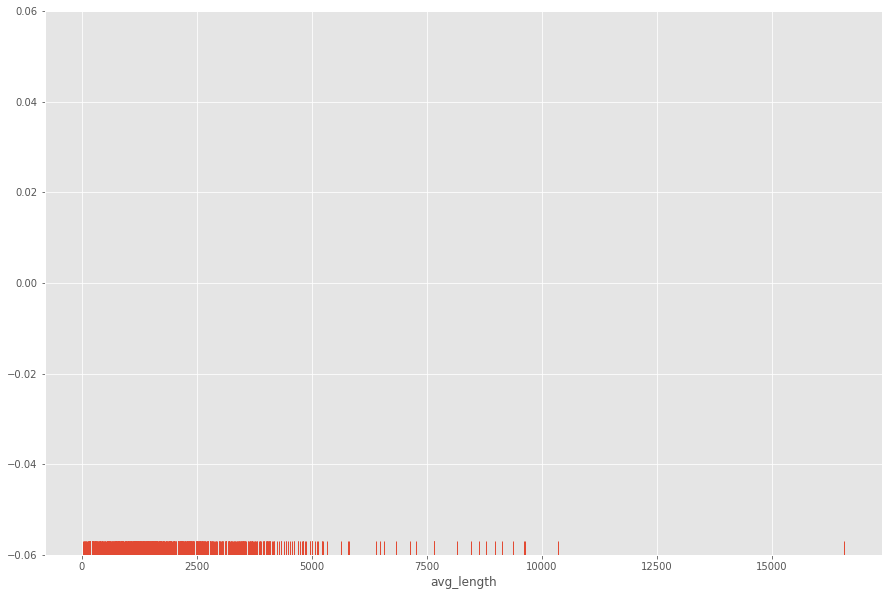

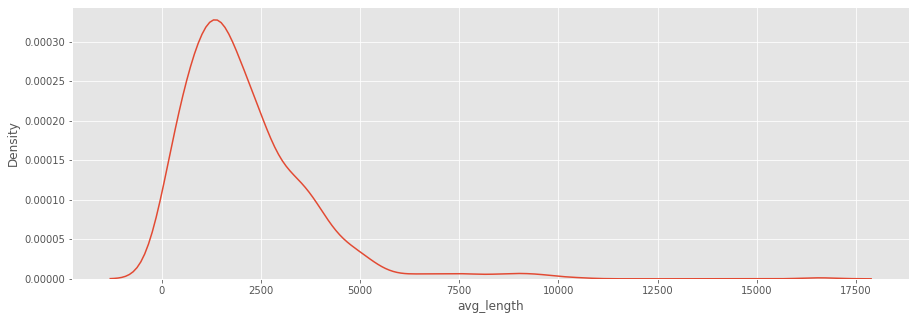

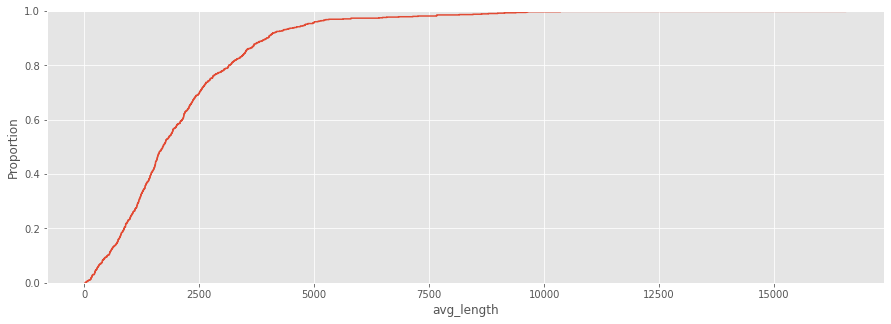

In [122]:
bpsos.plot()

### Observations

In [123]:
df = bpsos.df
limit = 200

In [124]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

426    Ch√∫c cho ƒë·∫°i h·ªôi ƒë·∫£ng to√†n qu·ªëc s·∫Øp t·ªõi ƒë∆∞·ª£c V...
566    ƒê√Ä L·∫†T - 20 nƒÉm nh√¨n l·∫°i c·ªßa nhi·∫øp ·∫£nh Tr∆∞∆°ng ...
581    N·∫øu kh√¥ng ph·∫£i l√† ng∆∞·ªùi c√°ch m·∫°ng v√¥ s·∫£n th√¨ s...
694       T√¨nh c·∫£m c√¥ng an v·ªõi t·ªôi ph·∫°m th·∫≠t khƒÉng kh√≠tüôà
701    Xin l·ªói ƒë∆∞·ª£c th√¨ L√™ VƒÉn Luy·ªán ƒë√¢u c·∫ßn ·ªü t√π?\n\...
703    √îng T. b·ªã t·ªë nhi·ªÅu l·∫ßn d√πng ƒë·ªãa v·ªã x√£ h·ªôi c·ªßa ...
717    Qu√¢n L·ªánh Cu·ªëi C√πng- T∆∞·ªüng Nh·ªõ Ng≈© H·ªï T∆∞·ªõng C·ªß...
723    Nh·ªõ Ch·ªã\n\nH√¥m nay l√† ng√†y Sinh nh·∫≠t c·ªßa ch·ªã v...
740    ƒêƒÉng ƒë·ªÉ bi·∫øt th√™m v·ªÅ c√°i 4 t·ªët 16 ch·ªØ v√†ng c·ªßa...
755    Nguy·ªÖn VƒÉn Tr√°ng ch√≠nh th·ª©c b·ªã truy n√£üò≥\n\nPh·∫£...
796    S√°ng nay ·∫£nh bu·ªìn l·∫Øm, t√¢m t∆∞ l·∫Øm. Th·∫•y ·∫£nh t√¢...
799    C·∫•p b√°o-c·∫•p b√°o: th√™m 2 ng∆∞·ªùi n·ªØa t·ª´ b·ªè ƒë·∫£ng C...
800    Ti·∫øp t·ª•c b√† con ∆°iü§£ vui nh∆∞ tr·∫©y h·ªôi\n\nT√¥i, T...
801    Thu n√†y bu·ªìn h·∫≥n m·∫•y th

In [125]:
for post in df[df['avg_length'] < limit ]['content']:
    print(post)
    print('-----------------------')

Ch√∫c cho ƒë·∫°i h·ªôi ƒë·∫£ng to√†n qu·ªëc s·∫Øp t·ªõi ƒë∆∞·ª£c V·∫°n s·ª± nh∆∞ √ù‚ù§Ô∏è
-----------------------
ƒê√Ä L·∫†T - 20 nƒÉm nh√¨n l·∫°i c·ªßa nhi·∫øp ·∫£nh Tr∆∞∆°ng Ng·ªçc Thu·ªµ.

T√¥i t·ª± h·ªèi, ng∆∞·ªùi c·ªông s·∫£n t·ª´ r·ª´ng ra, ƒë√∫ng ra h·ªç ph·∫£i y√™u r·ª´ng m·ªõi ph·∫£i? Sao l·∫°i bƒÉm n√°t c·∫£ r·ª´ng xanh th·∫ø?
-----------------------
N·∫øu kh√¥ng ph·∫£i l√† ng∆∞·ªùi c√°ch m·∫°ng v√¥ s·∫£n th√¨ s·∫Ω kh√¥ng th·ªÉ n√†o c√≥ cu·ªôc s·ªëng th·∫ßn ti√™n th·∫ø n√†y ƒë√¢uüòç

Ch√†o m·ª´ng c√°c b·∫°n ƒë·∫øn v·ªõi thi√™n ƒë∆∞·ªùng XHCNüôèüèΩ
-----------------------
T√¨nh c·∫£m c√¥ng an v·ªõi t·ªôi ph·∫°m th·∫≠t khƒÉng kh√≠tüôà
-----------------------
Xin l·ªói ƒë∆∞·ª£c th√¨ L√™ VƒÉn Luy·ªán ƒë√¢u c·∫ßn ·ªü t√π?

M·ªôt l≈© ph∆∞·ªùng th·∫£o kh·∫•u, ph∆∞·ªùng quen th√≥i tr·ªôm c∆∞·ªõp, n√≥i nh∆∞ CCCüòè

C∆∞·ªõp xong xin l·ªói l√† xong ƒë√≥ h·∫£? Tr·∫£ ti·ªÅn l·∫°i cho d√¢n ƒë√™ b·ªçn c∆∞·ªõpüò°
-----------------------
√îng T. b·ªã t·ªë nhi·ªÅu l·∫ßn d√πng ƒë·ªãa v·ªã

In [126]:
limit = 10000

In [127]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[1])

249    N·ªói bu·ªìn c·ªßa m·ªôt tang gia!\n\nC·∫£ b·ªánh vi·ªán m·ªôt...
831    T·∫§M TH·∫∫ B√ÄI C·ª¶A C√î B√ÅC Sƒ® VIVIAN LE\n\nC√¢u chu...
Name: content, dtype: object
--------------------



T·∫§M TH·∫∫ B√ÄI C·ª¶A C√î B√ÅC Sƒ® VIVIAN LE

C√¢u chuy·ªán ƒë∆∞·ª£c b·∫Øt ƒë·∫ßu v√†o s√°ng ng√†y 23-3-1975

Sau khi ch·ªìng v√† con trai b·ªã ch·∫øt v√¨ ƒë·∫°n ph√°o k√≠ch c·ªßa Vc ƒë·ªìng th·ªùi b·ªã th·∫•t l·∫°c ƒë·ª©a con g√°i trong ng√†y di t·∫£n t·∫°i b√£i bi·ªÉn Chu Lai, ch·ªã Bu√¥n qu·∫•n qu√Ωt ch·∫°y kh·∫Øp n∆°i ƒë·ªÉ h·ªèi thƒÉm v·ªÅ ƒë·ª©a con g√°i c·ªßa m√¨nh... ch·ªã ƒë√£ ƒë∆∞·ª£c m·ªôt ng∆∞·ªùi ch·∫°y n·∫°n cho bi·∫øt:

"Con b√© kho·∫£ng 9 hay 10 tu·ªïi m·∫∑c c√°i √°o xanh, qu·∫ßn ƒëen, c·ªï c√≥ ƒëeo c√°i th·∫ª b√†i c·ªßa l√≠nh l√† con ch·ªã sao? N√≥ ƒë∆∞·ª£c m·ªôt ng∆∞·ªùi tr√™n ca-n√¥ nh√†o xu·ªëng n∆∞·ªõc b∆°i v√†o v·ªõt n√≥ ƒë∆∞a l√™n ca-n√¥ ra t·∫ßu l·ªõn r·ªìi. Th·∫≠t l√† may m·∫Øn cho n√≥!"...

L·ªá, ƒë·ª©a con th·∫•t l·∫°c c·ªßa ch·ªã Bu√¥n ƒë∆∞·ª£c ƒë∆∞a l√™n t·∫ßu H·∫£i

### Run Preprocessing method

In [128]:
# 200 - 10000
# ...
bpsos.preprocess()

Enter < limit:200
Enter > limit:10000


### Save

In [129]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.csv		 khoi8406.pickle    thanhnienconggiao.csv
bpsos.pickle		 phamminhvu.pickle  thanhnienconggiao.pickle
chantroimoi.csv		 rfa_fixed.csv	    viettan.csv
chantroimoi.pickle	 rfa.pickle	    viettan_fb.csv
giaochucchuvanan.pickle  sbtn.csv	    viettan_fb.pickle
khoi8406.csv		 sbtn.pickle	    viettan.pickle


In [130]:
bpsos.df.iloc[1]['content']

'Ng∆∞·ªùi Vi·ªát Nam t·ª´ khi n√†o l·∫°i t√†n nh·∫´n th·∫ø?\n\nƒê·ªçc l·ªùi tr·∫ßn t√¨nh con g√°i M·ª•c s∆∞ T√¢n - Loan, c√πng xin l·ªói k√®m c√°i c√∫i ƒë·∫ßu v√† mong m·ªçi ng∆∞·ªùi tha th·ª© M·ª•c s∆∞ T√¢n, th·∫≠t x√≥t xa, v√† cay ƒë·∫Øng, v√¨ ƒë·∫±ng sau ƒë√≥ l√† nh·ªØng chu·ªói ng√†y b·ªã d∆∞ lu·∫≠n t·∫•n c√¥ng kh√¥ng ng∆°i ngh·ªâ, c√≥ nhi·ªÅu b·∫°n y√™u ƒë·∫£ng, y√™u nh√† n∆∞·ªõc c√≤n tung l·ªùi ƒëe d·ªça thi√™u s·ªëng c·∫£ gia ƒë√¨nh M·ª•c s∆∞.\n\nSao ng∆∞·ªùi Vi·ªát c√≥ th·ªÉ nh·∫´n t√¢m, v√† t√†n √°c ƒë·∫øn nh∆∞ th·∫ø?\n\nH·ªèi thƒÉm qua hai ng∆∞·ªùi b·∫°n m·ªôt ·ªü M·ªπ, m·ªôt ·ªü ƒê·ª©c, v√¨ hai qu·ªëc gia n√†y c√≥ s·ªë ng∆∞·ªùi ch·∫øt v√¨ d·ªãch v√† s·ªë ng∆∞·ªùi nhi·ªÖm tr∆∞·ªõc ƒë√¢y thu·ªôc top c·ªßa th·∫ø gi·ªõi. H·ªç ng·∫°c nhi√™n v√¨ t·∫°i M·ªπ v√† t·∫°i ƒê·ª©c nh·ªØng tr∆∞·ªùng h·ª£p t∆∞∆°ng t·ª± c·ªßa v·ª£ ch·ªìng M·ª•c s∆∞ T√¢n-Loan c√πng l·∫Øm ch·ªâ l√† b·ªã ph·∫°t ti·ªÅn th√¥i, ch·ª© ch·∫≥ng ai b·ªã kh·ªüi t·ªë.\n\nV√¨ Ch√≠nh ph·ªß M·ªπ hay ch√≠nh ph·ªß ƒê·ª©c l√†

In [131]:
bpsos.save_preprocess(os.getcwd() + "/phamminhvu")

In [132]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Giao chuc chu van an

### Define new instances

In [133]:
dataset_1

['viettan_quandiem.csv',
 'viettan_org_4.csv',
 'viettan_org_3.csv',
 'viettan_org_2.csv',
 'viettan_org.csv',
 'viettan_hoatdong.csv',
 'viettan_fb.csv',
 'viettan_diendan_3.csv',
 'viettan_diendan_2.csv',
 'viettan_diendan_1.csv',
 'thanhnienconggiao.csv',
 'sbtn.csv',
 'rfa.csv',
 'khoi8406.csv',
 'haudue_vnch.csv',
 'chantroimoi_media.csv',
 'bpsos.csv',
 'PhamMinhVuFBd.csv',
 'KhoaLuatTapChi_XaHoi.csv',
 'KhoaLuatTapChi_VNCH.csv',
 'KhoaLuatTapChi_ChinhTri.csv',
 'GiaoChucChuVanAn.csv']

In [134]:
# viettan_ls = []
# df_ls = []

# for i in range(-4, -1):
#     test = Dataframe('/1/' + dataset_1[i], 1)
#     print(test.name)
#     test.read_csv()
#     df_ls.append(test.df)

bpsos = Dataframe('/1/' + 'GiaoChucChuVanAn.csv', 1)
print(bpsos.name)
bpsos.read_csv()



# bpsos = Dataframe()
# bpsos.df = pd.concat(df_ls)

df = bpsos.df 
df

/1/GiaoChucChuVanAn.csv
df:       Unnamed: 0                                            content
0             0  Lu√¢n L√™\n27 th√°ng 5 l√∫c 16:34 ¬∑\n\nVƒÇN T·ª™ C·ª¶A ...
1             1  TH·∫¶Y GI√ÅO TH·ªÇ HI·ªÜN VƒÇN H√ìA ƒê·∫¢NG?\n\nKho·∫£ng Tr·ªù...
2             2  Nguy·ªÖn ƒê√¨nh C·ªëng\n3 gi·ªù ¬∑\nTH∆Ø TR·∫¢ L·ªúI C·ª¶A B·ªò ...
3             3  https://www.youtube.com/watch?v=rXQQ-oXEnFs\n\...
4             4  Video th·ª© 10 ƒë∆∞·ª£c th·ª±c hi·ªán nh√¢n m·ªôt th√†nh t·ª±u...
..          ...                                                ...
282         282  Xin ƒë∆∞·ª£c gi·ªõi thi·ªáu b√†i vi·∫øt c·ªßa ƒë√†i √Å Ch√¢u T·ª±...
283         283  VIDEO PH√ÅT BI·ªÇU C·ª¶A NH√Ä GI√ÅO PH·∫†M TO√ÄN\n\nPh√°t...
284         284  VIDEO PH√ÅT BI·ªÇU C·ª¶A GI√ÅO S∆Ø NGUY·ªÑN ƒê√åNH C·ªêNG\n...
285         285                                                NaN
286         286  K√≠nh m·ªùi m·ªçi ng∆∞·ªùi theo d√µi cu·ªôc trao ƒë·ªïi c·ªßa ...

[287 rows x 2 columns]


content  label  avg_length
0    Lu√¢n L√™\n27 th√°ng 5 l√∫c 16:34 ¬∑\n\nVƒÇN T·ª™ C·ª¶A ...      1        1873
1    TH·∫¶Y GI√ÅO TH·ªÇ HI·ªÜN VƒÇN H√ìA ƒê·∫¢NG?\n\nKho·∫£ng Tr·ªù...      1         644
2    Nguy·ªÖn ƒê√¨nh C·ªëng\n3 gi·ªù ¬∑\nTH∆Ø TR·∫¢ L·ªúI C·ª¶A B·ªò ...      1        1384
3    https://www.youtube.com/watch?v=rXQQ-oXEnFs\n\...      1         157
4    Video th·ª© 10 ƒë∆∞·ª£c th·ª±c hi·ªán nh√¢n m·ªôt th√†nh t·ª±u...      1         374
..                                                 ...    ...         ...
281  M·ªçi ng∆∞·ªùi qu√¢n t√¢m ƒë·∫øn gi√°o d·ª•c h√£y b√¨nh lu·∫≠n ...      1         370
282  Xin ƒë∆∞·ª£c gi·ªõi thi·ªáu b√†i vi·∫øt c·ªßa ƒë√†i √Å Ch√¢u T·ª±...      1         147
283  VIDEO PH√ÅT BI·ªÇU C·ª¶A NH√Ä GI√ÅO PH·∫†M TO√ÄN\n\nPh√°t...      1         643
284  VIDEO PH√ÅT BI·ªÇU C·ª¶A GI√ÅO S∆Ø NGUY·ªÑN ƒê√åNH C·ªêNG\n...      1         806
286  K√≠nh m·ªùi m·ªçi ng∆∞·ªùi theo d√µi cu·ªôc trao ƒë·ªïi c·ªßa ...      1         300

[284 rows x 3 columns]

### Content Filter

In [135]:
temp = df[df['content'].str.contains("CS|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|c√¥ng an|" + 
        "quan ch·ª©c|c∆∞·ªõp|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|ch√≠nh tr·ªã|ch√≠nh quy·ªÅn|XHCN|CNXH", regex = True, flags=re.IGNORECASE)]

print(bpsos.name)
bpsos.df = temp
bpsos.df

/1/GiaoChucChuVanAn.csv


content  label  avg_length
1    TH·∫¶Y GI√ÅO TH·ªÇ HI·ªÜN VƒÇN H√ìA ƒê·∫¢NG?\n\nKho·∫£ng Tr·ªù...      1         644
2    Nguy·ªÖn ƒê√¨nh C·ªëng\n3 gi·ªù ¬∑\nTH∆Ø TR·∫¢ L·ªúI C·ª¶A B·ªò ...      1        1384
10   https://www.youtube.com/watch?v=5Lp6MGINBIs\n\...      1         146
11   https://www.youtube.com/watch?v=0b5RsM8Ob_A\n\...      1         157
13   https://www.youtube.com/watch?v=0wTwAmx2axc\n\...      1         117
..                                                 ...    ...         ...
266  V√¨ sao nh√† n∆∞·ªõc CSVN kh√¥ng ƒë∆∞a cu·ªôc chi·∫øn tran...      1         914
271  GI√ÅO S∆Ø NGUY·ªÑN ƒê√åNH C·ªêNG TUY√äN B·ªê T·ª™ B·ªé ƒê·∫¢NG C...      1        1080
273  http://tiengnoicongdan.blogspot.com/2016/01/hi...      1         423
282  Xin ƒë∆∞·ª£c gi·ªõi thi·ªáu b√†i vi·∫øt c·ªßa ƒë√†i √Å Ch√¢u T·ª±...      1         147
283  VIDEO PH√ÅT BI·ªÇU C·ª¶A NH√Ä GI√ÅO PH·∫†M TO√ÄN\n\nPh√°t...      1         643

[87 rows x 3 columns]

In [136]:
for post in bpsos.df['content'].iloc[:60]:
    print(post)
    print("---------------------")
# print(bpsos.df['content'].iloc[:-1])

TH·∫¶Y GI√ÅO TH·ªÇ HI·ªÜN VƒÇN H√ìA ƒê·∫¢NG?

Kho·∫£ng Tr·ªùi C√≥ M∆∞a
1 th√°ng 5 l√∫c 23:02 ¬∑

Kh√¥ng bi·∫øt v·ªõi nh·ªØng h√†nh vi nh∆∞ th·∫ø c·ªßa m·ªôt gi√°o vi√™n ƒë·∫°i di·ªán ng√†nh gi√°o d·ª•c th√¨ tr√°ch nhi·ªám tr∆∞·ªõc ph√°p lu·∫≠t v√† to√†n x√£ h·ªôi s·∫Ω l√†Kh√°c t·∫°m ƒë√¨nh ch·ªâ gi·∫£ng d·∫°y hay l√† ph·∫£i x·ª≠ l√Ω h√¨nh s·ª±?!
Th·∫ßy gi√°o m√† c·ª© ng·ª° m.a c√¥!

https://www.facebook.com/khoangtroicomua1/posts/330266272001555

Kho·∫£ng Tr·ªùi C√≥ M∆∞a
1 th√°ng 5 l√∫c 18:02 ¬∑

Kh√¥ng bi·∫øt v·ªõi nh·ªØng h√†nh vi nh∆∞ th·∫ø c·ªßa m·ªôt gi√°o vi√™n ƒë·∫°i di·ªán ng√†nh gi√°o d·ª•c th√¨ tr√°ch nhi·ªám tr∆∞·ªõc ph√°p lu·∫≠t v√† to√†n x√£ h·ªôi s·∫Ω l√† t·∫°m ƒë√¨nh ch·ªâ gi·∫£ng d·∫°y hay l√† ph·∫£i x·ª≠ l√Ω h√¨nh s·ª±?!
Th·∫ßy gi√°o m√† c·ª© ng·ª° m.a c√¥!

Like Page üëâ üëâ

Kho·∫£ng Tr·ªùi C√≥ M∆∞a
---------------------
Nguy·ªÖn ƒê√¨nh C·ªëng
3 gi·ªù ¬∑
TH∆Ø TR·∫¢ L·ªúI C·ª¶A B·ªò TR∆Ø·ªûNG
T√¥i v·ª´a nh·∫≠n th∆∞ tr·∫£ l·ªùi c·ªßa B·ªô tr∆∞·ªüng, ch√©p l√™n ƒë√¢y 

In [137]:
aaa = pd.concat([temp, df])
print(aaa.drop_duplicates('content', keep = False)['content'].iloc[0])

Lu√¢n L√™
27 th√°ng 5 l√∫c 16:34 ¬∑

VƒÇN T·ª™ C·ª¶A NH·ªÆNG K·∫∫ V√î L·∫†I

Nh·ªØng k·∫ª ch·∫≥ng c√≤n nh√¢n t√≠nh, nh∆∞ng, l·∫°i l√† nh·ªØng c√°i nh∆∞ng ch·∫•t ch·ª©a n·ªói x√≥t xa v√† ph·∫´n n·ªô, nh·ªØng b·ªô m·∫∑t g√°nh v√°c tr·ªçng tr√°ch ‚Äúg√¢y d·ª±ng t√¢m h·ªìn‚Äù sonKh√°c ph·∫øt r·∫°ng r·ª° v·∫ª ngo√†i ‚Äúnh√¢n vƒÉn‚Äù l·∫°i l√† nh·ªØng k·∫ª v√¥ l·∫°i v√¨ t√¢m h·ªìn ƒë√£ l·∫•m b·∫©n ƒë·∫ßy b√πn ƒë·∫•t.
C√°c c√¢u ch·ªØ ƒë∆∞·ª£c b√†y ra ch·ªâ cho th·∫•y h·ªç kh√¥ng ch·ªâ t√†n b·∫°o v·ªõi ƒë·ªìng nghi·ªáp, m√† h·ªç c√≤n ƒëang th·ª±c hi·ªán m·ªôt cu·ªôc l·∫≠t ƒë·ªï v·ªÅ nh√¢n t√≠nh con ng∆∞·ªùi, khi ƒëang nh√¢n danh s·ª± gi√°o d·ª•c.
‚Äúƒê√π phe m√¨nh kh√¥ng‚Äù, hay ‚Äúd·∫≠p cho ch·∫øt b√† nh√† n√≥ ƒëi‚Äù, m·ªôt c√°ch vui th√∫, trong m·ªôt ƒëo·∫°n tho·∫°i ng·∫Øn ng·ªßi gi·ªØa v√†i g∆∞∆°ng m·∫∑t nh√† gi√°o v·ªõi nhau. V√† ng∆∞·ªùi th·ª© ba v·∫Øng m·∫∑t tr·ªü th√†nh ti√™u ng·∫Øm ƒë·ªÉ b·ªçn h·ªç th·ª±c h√†nh nh·ªØng s·ª± tri·ªát h·∫° m√† ch√∫ng ƒëang ƒë∆∞·ª£c th·∫£o b√†n trong s·ª± 

### Plot distribution

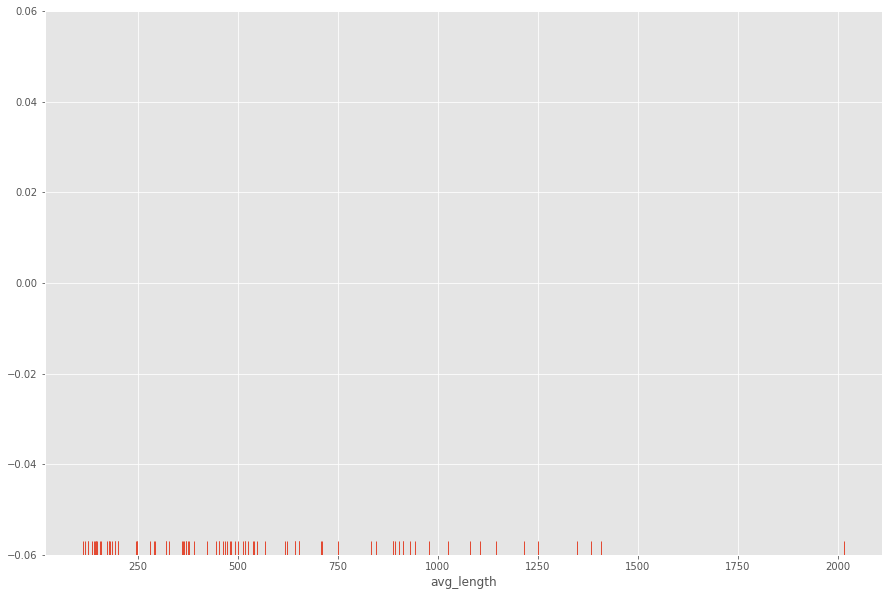

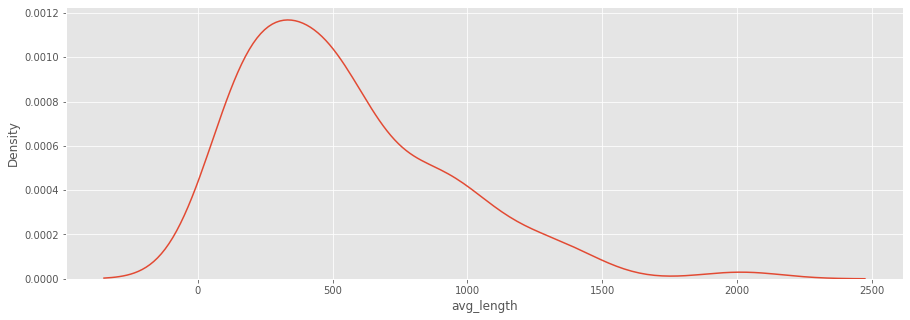

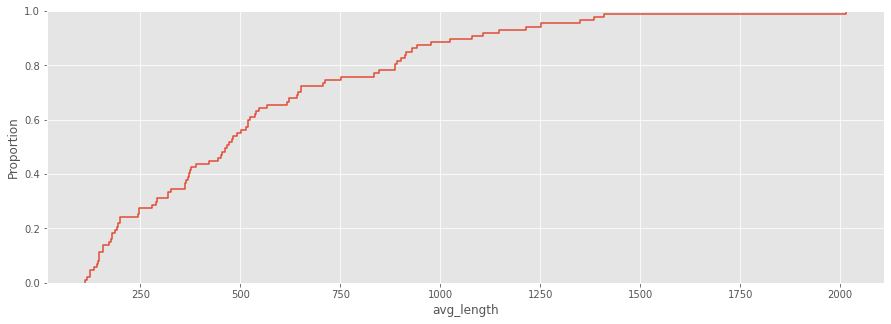

In [138]:
bpsos.plot()

### Observations

In [139]:
df = bpsos.df
limit = 300

In [140]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")

10     https://www.youtube.com/watch?v=5Lp6MGINBIs\n\...
11     https://www.youtube.com/watch?v=0b5RsM8Ob_A\n\...
13     https://www.youtube.com/watch?v=0wTwAmx2axc\n\...
18     https://www.youtube.com/watch?v=w2lvBG9ykiM\n\...
27     https://www.facebook.com/nguyentrongmai55/post...
31     https://www.voatiengviet.com/a/thu-truong-bo-g...
42     https://www.facebook.com/anh.toi.14224/posts/1...
50     H·ªçc ch·ªëng tham nh≈©ng, ch·ªëng ai? Ch·ªëng ƒë·∫£ng √†?\...
61     S·ªü gi√°o d·ª•c H√† Tƒ©nh ti·∫øp kh√°ch h∆°n 3 t·ª∑ ƒë·ªìng 1...
62     B·ªô tr∆∞·ªüng b·ªô gi√°o d·ª•c thi·∫øu c·∫£ ƒë·∫°o ƒë·ª©c l·∫´n tr√≠...
99     https://chantroimoimedia.com/2018/08/14/kinh-d...
102    X√£ h·ªôi Vi·ªát Nam d∆∞·ªõi s·ª± l√£nh ƒë·∫°o "to√†n di·ªán, t...
104    Gi√°o vi√™n ph√° thai ƒë·ªÉ g√≥p ph·∫ßn gi·ªØ "th√†nh t√≠ch...
117    https://www.youtube.com/watch?v=3Erdrkg_XBQ\n\...
122    T·ªët nghi·ªáp ƒë·∫°i h·ªçc ·ªü ch·ªën thi√™n ƒë∆∞·ªùng XHCN !\n...
140    S√°ng nay ng√†y 24/8/2017 (2/7 √¢m l·ª

In [141]:
for post in df[df['avg_length'] < limit ]['content']:
    print(post)
    print('-----------------------')

https://www.youtube.com/watch?v=5Lp6MGINBIs

YOUTUBE.COM
TR√íN 1 NƒÇM NG√ÄY TH·∫¶Y GI√ÅO, T√ô NH N L∆Ø∆†NG T M ƒê√ÄO QUANG TH·ª∞C QUA ƒê·ªúI TRONG NH√Ä T√ô C·ªòNG S·∫¢N
-----------------------
https://www.youtube.com/watch?v=0b5RsM8Ob_A

YOUTUBE.COM
KTV t·ªëi 25/11: Danh s√°ch l√£nh ƒë·∫°o CSVN tr√¨nh ƒë·ªô c·∫•p 2, mua b·∫±ng TS gi·∫£ ƒë∆∞·ª£c c·∫•t nh·∫Øc gh·∫ø quan tr·ªçng?
-----------------------
https://www.youtube.com/watch?v=0wTwAmx2axc

YOUTUBE.COM
C·∫£i c√°ch c√°i ƒë·∫ßu quan ch·ª©c tr∆∞·ªõc khi c·∫£i c√°ch s√°ch gi√°o khoa
-----------------------
https://www.youtube.com/watch?v=w2lvBG9ykiM

YOUTUBE.COM
KTV Live tr∆∞a 26/9: L·ª≠a ƒêH13 lan ƒë·∫øn ƒêH T√¥n ƒê·ª©c Th·∫Øng & nh·ªØng b√™ b·ªëi ·ªü T·ªïng li√™n ƒëo√†n Lƒê?
-----------------------
https://www.facebook.com/nguyentrongmai55/posts/1184396571745879

BAOMOI.COM
H∆°n 2.200 sinh vi√™n Tr∆∞·ªùng ƒêH C√¥ng nghi·ªáp TP.HCM t·ª± √Ω b·ªè h·ªçc

Nguy·ªÖn Tr·ªçng Mai
16 th√°ng 12, 2019 l√∫c 18:28 ¬∑

ƒê·∫øn CNXH r·ªìi
-----------

In [142]:
limit = 2000

In [143]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

20    KH√îNG BI·∫æT NH·ª§C SAO C√íN T·ª∞ HAÃÄO?\n\nƒê·∫£ng csVn ...
Name: content, dtype: object
--------------------



KH√îNG BI·∫æT NH·ª§C SAO C√íN T·ª∞ HAÃÄO?

ƒê·∫£ng csVn ƒë∆∞a v√†o s√°ch gi√°o khoa d·∫°y cho c√°c th·∫ø h·ªá tr·∫ª r·∫±ng: "ƒë·∫•t n∆∞·ªõc ta gi√†u v√† ƒë·∫πp. C√≥ r·ª´ng v√†ng, bi·ªÉn b·∫°c, kho√°ng saÃân, d·∫ßu moÃâ....bao la". R·ªìi ƒë·∫£ng v·ªó ng·ª±c t·ª± h√†o v√¨ th·∫øKh√°c h·ªá c·ªßa h·ªç ƒë√£ b√°n ƒë·ªï, b√°n th√°o, b√°n s·∫°ch s√†nh sanh c√°c t√†i nguy√™n m√† t·ªï ti√™n ƒë√£ ƒë·ªÉ l·∫°i ·∫•y. L√Ω do t·ª± h√†o c·ªßa h·ªç ƒë∆∞a ra l√†: th·∫ø h·ªá ch√°u con s·∫Ω kh√¥ng coÃÄn d·ª±a v√†o t√†i nguy√™n thi√™n nhi√™n n·ªØa, m√† con ƒë∆∞·ªùng duy nh·∫•t mu·ªën t·ªìn taÃ£i l√† ph·∫£i h·ªçc?

√îi! ƒÇn h·∫øt ph·∫ßn c·ªßa con ch√°u m√† t·ª± h√†o sao m·∫•y √¥ng c·ªông s·∫£n? Tr√™n ƒë·ªùi n√†y c√≥ lo√†i g√¨ d√†nh ƒÉn v·ªõi con ch√°u m√† v·ªó ng·ª±c t·ª± h√†o h·∫£ tr·ªùi? Th·ª≠ quan s√°t xem lo√†i Ong, lo√†i Ki·∫øn c√≤n bi·∫øt t√¨m ki·∫øm t√≠ch tr·ªØ l∆∞∆°ng th·ª±c v·ªÅ ch

### Run Preprocessing method

In [144]:
# 300 - 10000
# ...
bpsos.preprocess()

Enter < limit:300
Enter > limit:10000


### Save

In [145]:
%cd ..
%cd preprocessed 
%cd 1/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/1
bpsos.csv		 phamminhvu.csv		thanhnienconggiao.pickle
bpsos.pickle		 phamminhvu.pickle	viettan.csv
chantroimoi.csv		 rfa_fixed.csv		viettan_fb.csv
chantroimoi.pickle	 rfa.pickle		viettan_fb.pickle
giaochucchuvanan.pickle  sbtn.csv		viettan.pickle
khoi8406.csv		 sbtn.pickle
khoi8406.pickle		 thanhnienconggiao.csv


In [146]:
bpsos.df['content'].iloc[0]

'TH·∫¶Y GI√ÅO TH·ªÇ HI·ªÜN VƒÇN H√ìA ƒê·∫¢NG?\n\nKho·∫£ng Tr·ªùi C√≥ M∆∞a\n1 th√°ng 5 l√∫c 23:02 ¬∑\n\nKh√¥ng bi·∫øt v·ªõi nh·ªØng h√†nh vi nh∆∞ th·∫ø c·ªßa m·ªôt gi√°o vi√™n ƒë·∫°i di·ªán ng√†nh gi√°o d·ª•c th√¨ tr√°ch nhi·ªám tr∆∞·ªõc ph√°p lu·∫≠t v√† to√†n x√£ h·ªôi s·∫Ω l√†Kh√°c t·∫°m ƒë√¨nh ch·ªâ gi·∫£ng d·∫°y hay l√† ph·∫£i x·ª≠ l√Ω h√¨nh s·ª±?!\nTh·∫ßy gi√°o m√† c·ª© ng·ª° m.a c√¥!\n\n\nKho·∫£ng Tr·ªùi C√≥ M∆∞a\n1 th√°ng 5 l√∫c 18:02 ¬∑\n\nKh√¥ng bi·∫øt v·ªõi nh·ªØng h√†nh vi nh∆∞ th·∫ø c·ªßa m·ªôt gi√°o vi√™n ƒë·∫°i di·ªán ng√†nh gi√°o d·ª•c th√¨ tr√°ch nhi·ªám tr∆∞·ªõc ph√°p lu·∫≠t v√† to√†n x√£ h·ªôi s·∫Ω l√† t·∫°m ƒë√¨nh ch·ªâ gi·∫£ng d·∫°y hay l√† ph·∫£i x·ª≠ l√Ω h√¨nh s·ª±?!\nTh·∫ßy gi√°o m√† c·ª© ng·ª° m.a c√¥!\n\nLike Page üëâ üëâ\n\nKho·∫£ng Tr·ªùi C√≥ M∆∞a'

In [147]:
bpsos.save_preprocess(os.getcwd() + "/giaochucchuvanan")

In [148]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Chinhtri vnexpress

### Define new instances

In [149]:
dataset_0

['vnexpress_thoisu_2.csv',
 'tinnoichinh.csv',
 'vnexpress_kinhdoanh.csv',
 'qdnd_dienbienhoabinh.csv',
 'vnexpress_phapluat.csv',
 'vnexpress_thoisu_1.csv',
 'qdnd_chinhtri.csv']

In [150]:
viettan_ls = []

for i in [0, 2, 3, 4, 5, 6]:
    test = Dataframe('/0/' + dataset_0[i], 0)
    print(test.name)
    test.read_csv()
    viettan_ls.append(test.df)

viettan= Dataframe('', 0)
viettan.df = pd.concat(viettan_ls)
df = viettan.df

print(df)
print(df.shape)

/0/vnexpress_thoisu_2.csv
df:        Unnamed: 0                                            content
0              0  L√£nh ƒë·∫°o qu·∫≠n Th·ªß ƒê·ª©c x√¢y d·ª±ng kh√¥ng ph√©p\nTP ...
1              1  Ph√≥ gi√°m ƒë·ªëc S·ªü ·ªü ƒê·ªìng Th√°p b·ªã ƒë√¨nh ch·ªâ ch·ª©c v...
2              2  Nh·ªØng m√πa b√£o qu√©t qua nh√† gi√†n DK1\nTr∆∞·ªõc l√∫c...
3              3  19 h·ªçc sinh nh·∫≠p vi·ªán do h∆°i cay\nQu·∫£ng Ninh19...
4              4  C√¥ gi√°o d√†nh n·ª≠a cu·ªôc ƒë·ªùi gi√∫p tr·∫ª khuy·∫øt t·∫≠t\...
...          ...                                                ...
8487        8487  Trung v·ªá B√πi Ti·∫øn D≈©ng k√Ω t·∫∑ng ·∫£nh g√¢y qu·ªπ gi√∫...
8488        8488  B√£o c·∫•p 8 g·∫ßn bi·ªÉn ƒê√¥ng\nChi·ªÅu nay 11/2, √°p th...
8489        8489  T·∫øt s·ªõm c·ªßa sƒ© quan g√¨n gi·ªØ h√≤a b√¨nh Vi·ªát Nam ...
8490        8490  Ba Th·ª© tr∆∞·ªüng Ngo·∫°i giao ngh·ªâ h∆∞u\nBa Th·ª© tr∆∞·ªü...
8491        8491  Ng∆∞ d√¢n H√† Tƒ©nh tr√∫ng ƒë·∫≠m m·∫ª c√° thu\nKhoang t√†...

[8492 rows

### Content Filter

In [151]:
temp = df[df['content'].str.contains("CS|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|c√¥ng an|" + 
        "quan ch·ª©c|c∆∞·ªõp|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|ch√≠nh tr·ªã|ch√≠nh quy·ªÅn|XHCN", regex = True, flags=re.IGNORECASE)]

# print(viettan.name)
viettan.df = temp
df = viettan.df
# temp.iloc[3].content
viettan.df

content  label  avg_length
0     L√£nh ƒë·∫°o qu·∫≠n Th·ªß ƒê·ª©c x√¢y d·ª±ng kh√¥ng ph√©p\nTP ...      0        3284
1     Ph√≥ gi√°m ƒë·ªëc S·ªü ·ªü ƒê·ªìng Th√°p b·ªã ƒë√¨nh ch·ªâ ch·ª©c v...      0        2902
2     Nh·ªØng m√πa b√£o qu√©t qua nh√† gi√†n DK1\nTr∆∞·ªõc l√∫c...      0        9709
3     19 h·ªçc sinh nh·∫≠p vi·ªán do h∆°i cay\nQu·∫£ng Ninh19...      0         582
4     C√¥ gi√°o d√†nh n·ª≠a cu·ªôc ƒë·ªùi gi√∫p tr·∫ª khuy·∫øt t·∫≠t\...      0        5349
...                                                 ...    ...         ...
3035  Th·ªß t∆∞·ªõng Nguy·ªÖn Xu√¢n Ph√∫c d·ª± H·ªôi ngh·ªã t·ªïng k·∫ø...      0        5759
3036  Ch·ªß t·ªãch Qu·ªëc h·ªôi Nguy·ªÖn Th·ªã Kim Ng√¢n ch·ªß tr√¨ ...      0        2631
3037  Ch·ªß t·ªãch n∆∞·ªõc Tr·∫ßn ƒê·∫°i Quang d·ª± ch∆∞∆°ng tr√¨nh n...      0        3147
3038  √îng H·∫ßu A L·ªÅnh gi·ªØ ch·ª©c Ph√≥ ch·ªß t·ªãch - T·ªïng th...      0        4380
3039  VƒÉn ph√≤ng Qu·ªëc h·ªôi tri·ªÉn khai nhi·ªám v·ª• nƒÉm 201...      0        3993

[30578 rows x 3 columns]

### Plot distribution

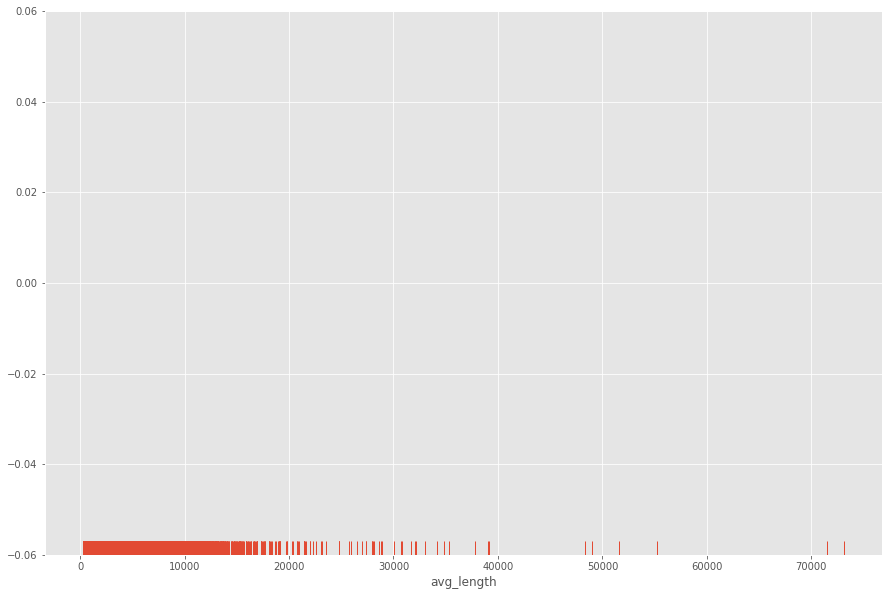

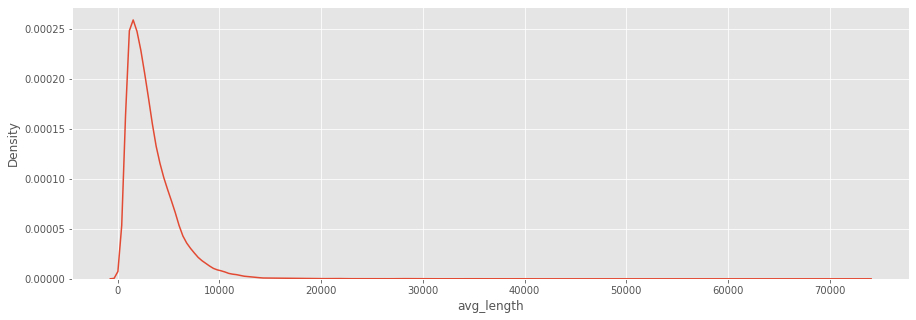

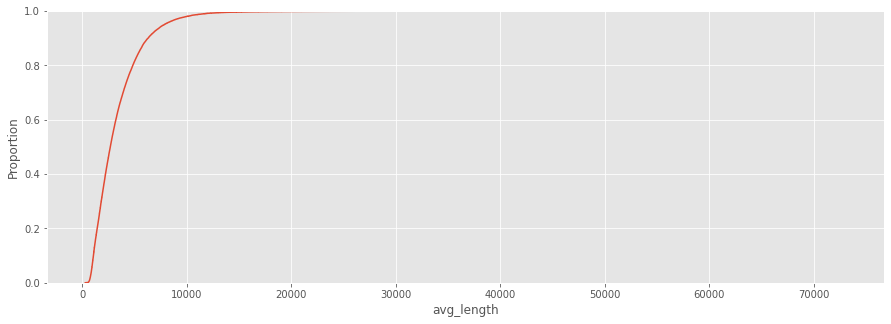

In [152]:
viettan.plot()

### Observations

In [153]:
limit = 400

In [154]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

5944    Ng·∫≠p k√©o d√†i, h∆°n ngh√¨n h·ªô d√¢n H√† N·ªôi m·∫•t ƒëi·ªán...
5993    Nh·ªØng kho·∫£nh kh·∫Øc ghi d·∫•u th·ªùi ƒëi·ªÉm H√† N·ªôi m·ªü ...
8207    ƒê√™m 'tr·ªëng v·ª° l√† y√™u' gi·ªØa ƒë·∫°i ng√†n Tr∆∞·ªùng S∆°n...
937     Chuy√™n gia ph√¢n t√≠ch k·ªãch b·∫£n chuy·ªÉn ƒë·ªïi s·ªë ng...
1665    C√°ch doanh nghi·ªáp nh·ªè v√† v·ª´a khai th√°c Hi·ªáp ƒë·ªã...
3506    'Ph√°t tri·ªÉn th√†nh ph·ªë th√¥ng minh c·∫ßn c√≥ s·ª± h·ª£p...
3811    DKRA Vietnam: 'Th·ªã tr∆∞·ªùng cƒÉn h·ªô B√¨nh D∆∞∆°ng n√≥...
4001    15 Th·ªëng ƒë·ªëc Ng√¢n h√†ng Nh√† n∆∞·ªõc qua c√°c th·ªùi k...
5050    N√∫i n·ª£ trƒÉm nƒÉm c·ªßa th·∫ø gi·ªõi cao th√™m v√¨ Covid...
7933    10 ng∆∞·ªùi gi√†u nh·∫•t h√†nh tinh\nNƒÉm nay, Jeff Be...
8068    Kh·ªßng ho·∫£ng n·ª£ to√†n c·∫ßu c√≥ th·ªÉ ƒëang ƒë·∫øn\nTh·∫ø g...
215     8 kh√∫c m·∫Øc v·ªÅ quy·ªÅn ki·ªÉm so√°t c·ªßa cha m·∫π v·ªõi c...
253     7 ƒëi·ªÅu c·∫ßn bi·∫øt khi s·ª≠ d·ª•ng m·∫°ng x√£ h·ªôi\nVi·∫øt ...
352     Gi·∫£i m√£ nh·ªØng ng·ªô nh·∫≠n v·ªÅ bi·ªÉn 

In [155]:
limit = 45000

In [156]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

519     Ch·ªß thuy·∫øt ch√≠nh tr·ªã Vi·ªát Nam trong th·ªùi ƒë·∫°i n...
560     X√¢y d·ª±ng ƒê·∫£ng l√† nhi·ªám v·ª• then ch·ªët, c√≥ √Ω nghƒ©...
2754    B√°o c√°o c·ªßa Ban Ch·∫•p h√†nh Trung ∆∞∆°ng kh√≥a XII ...
716     Vi·ªát Nam l√† m·ªôt trong nh·ªØng qu·ªëc gia tƒÉng tr∆∞·ªü...
1214    D·ª± ki·∫øn, nƒÉm 2019 l√† nƒÉm th·ª© hai li√™n ti·∫øp ƒë·∫°t...
2664    ƒê√°nh gi√° b·ªï sung k·∫øt qu·∫£ ph√°t tri·ªÉn kinh t·∫ø-x√£...
Name: content, dtype: object
--------------------



Ch·ªß thuy·∫øt ch√≠nh tr·ªã Vi·ªát Nam trong th·ªùi ƒë·∫°i ng√†y nay
QƒêND - Ch·ªß thuy·∫øt ch√≠nh tr·ªã Vi·ªát Nam th·ªùi ƒë·∫°i ng√†y nay l√† ƒë·ªôc l·∫≠p d√¢n t·ªôc g·∫Øn li·ªÅn v·ªõi ch·ªß nghƒ©a x√£ h·ªôi d∆∞·ªõi ng·ªçn c·ªù l√£nh ƒë·∫°o c·ªßa ƒê·∫£ng C·ªông s·∫£n Vi·ªát Nam tr√™n n·ªÅn t·∫£ng ch·ªß nghƒ©a M√°c - L√™-nin, t∆∞ t∆∞·ªüng H·ªì Ch√≠ Minh ph√°t tri·ªÉn t·ª´ h∆°n 80 nƒÉm nay v√† m√£i t·ª´ nay v·ªÅ sau...
QƒêND - Ch·ªß thuy·∫øt ch√≠nh tr·ªã Vi·ªát Nam th·ªùi ƒë·∫°i ng√†y nay l√† ƒë·ªôc l·∫≠p d√¢n 

### Run Preprocessing method

In [157]:
# 400 - 45000
# ...
viettan.preprocess()

Enter < limit:400
Enter > limit:45000


### Save

In [158]:
%cd ..
%cd preprocessed 
%cd 0/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/0
tinnoichinh.pickle  vnexpress_v2.pickle


In [159]:
print(viettan.df)

                                                content  label  avg_length
0     L√£nh ƒë·∫°o qu·∫≠n Th·ªß ƒê·ª©c x√¢y d·ª±ng kh√¥ng ph√©p\nTP ...      0        3284
1     Ph√≥ gi√°m ƒë·ªëc S·ªü ·ªü ƒê·ªìng Th√°p b·ªã ƒë√¨nh ch·ªâ ch·ª©c v...      0        2902
2     Nh·ªØng m√πa b√£o qu√©t qua nh√† gi√†n DK1\nTr∆∞·ªõc l√∫c...      0        9709
3     19 h·ªçc sinh nh·∫≠p vi·ªán do h∆°i cay\nQu·∫£ng Ninh19...      0         582
4     C√¥ gi√°o d√†nh n·ª≠a cu·ªôc ƒë·ªùi gi√∫p tr·∫ª khuy·∫øt t·∫≠t\...      0        5349
...                                                 ...    ...         ...
3035  Th·ªß t∆∞·ªõng Nguy·ªÖn Xu√¢n Ph√∫c d·ª± H·ªôi ngh·ªã t·ªïng k·∫ø...      0        5759
3036  Ch·ªß t·ªãch Qu·ªëc h·ªôi Nguy·ªÖn Th·ªã Kim Ng√¢n ch·ªß tr√¨ ...      0        2631
3037  Ch·ªß t·ªãch n∆∞·ªõc Tr·∫ßn ƒê·∫°i Quang d·ª± ch∆∞∆°ng tr√¨nh n...      0        3147
3038  √îng H·∫ßu A L·ªÅnh gi·ªØ ch·ª©c Ph√≥ ch·ªß t·ªãch - T·ªïng th...      0        4380
3039  VƒÉn ph√≤ng Qu·ªëc h·ªôi tr

In [160]:
viettan.save_preprocess(os.getcwd() + "/vnexpress_v2")

In [161]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


## Tinnoichinh

### Define new instances

In [162]:
dataset_0

['vnexpress_thoisu_2.csv',
 'tinnoichinh.csv',
 'vnexpress_kinhdoanh.csv',
 'qdnd_dienbienhoabinh.csv',
 'vnexpress_phapluat.csv',
 'vnexpress_thoisu_1.csv',
 'qdnd_chinhtri.csv']

In [163]:
viettan_ls = []

for i in [-1]:
    test = Dataframe('/0/' + dataset_0[i], 0)
    print(test.name)
    test.read_csv()
    viettan_ls.append(test.df)

viettan= Dataframe('', 9)
viettan.df = pd.concat(viettan_ls)
df = viettan.df

print(df.shape)

/0/qdnd_chinhtri.csv
df:        Unnamed: 0                                            content
0              0  Kh·∫Øc ph·ª•c 2 khuynh h∆∞·ªõng l√†m gi·∫£m ‚Äútu·ªïi th·ªç‚Äù c...
1              1  Th·ªß t∆∞·ªõng Ph·∫°m Minh Ch√≠nh: Vi·ªác ch·ªëng d·ªãch Cov...
2              2  Ch·ªß t·ªãch n∆∞·ªõc Nguy·ªÖn Xu√¢n Ph√∫c: N√¢ng cao ch·∫•t ...
3              3  Ch·ªß t·ªãch Qu·ªëc h·ªôi V∆∞∆°ng ƒê√¨nh Hu·ªá thƒÉm B√°o Nh√¢n...
4              4  Th·ªß t∆∞·ªõng Ph·∫°m Minh Ch√≠nh: S·ª© m·ªánh c·ªßa nh·ªØng n...
...          ...                                                ...
3035        3035  Th·ªß t∆∞·ªõng Nguy·ªÖn Xu√¢n Ph√∫c d·ª± H·ªôi ngh·ªã t·ªïng k·∫ø...
3036        3036  Ch·ªß t·ªãch Qu·ªëc h·ªôi Nguy·ªÖn Th·ªã Kim Ng√¢n ch·ªß tr√¨ ...
3037        3037  Ch·ªß t·ªãch n∆∞·ªõc Tr·∫ßn ƒê·∫°i Quang d·ª± ch∆∞∆°ng tr√¨nh n...
3038        3038  √îng H·∫ßu A L·ªÅnh gi·ªØ ch·ª©c Ph√≥ ch·ªß t·ªãch - T·ªïng th...
3039        3039  VƒÉn ph√≤ng Qu·ªëc h·ªôi tri·ªÉn khai nhi·ªám v·ª• nƒÉm 201..

### Content Filter

In [164]:
temp = df[df['content'].str.contains("CS|ƒë√°nh|t√π|d√¢n ch·ªß|C·ªông S·∫£n|vi·ªát c·ªông|t·ªôi √°c|k√≠ch ƒë·ªông|ƒë√†n √°p|ƒê·∫£ng|cai tr·ªã|tham nh≈©ng|CSVN|nh√† c·∫ßm quy·ªÅn|gi√†u|t·ª≠ vong|ch·ªß nghƒ©a|ch·∫ø ƒë·ªô|c√°n b·ªô|b·∫ßu c·ª≠|c√¥ng an|" + 
        "quan ch·ª©c|c∆∞·ªõp|nh√† n∆∞·ªõc|t·ª± do|d·ªëi|th·∫•t b·∫°i|b√™ b·ªëi|ch√≠nh tr·ªã|ch√≠nh quy·ªÅn|XHCN", regex = True, flags=re.IGNORECASE)]

print(viettan.name)
viettan.df = temp
df = viettan.df

viettan.df

content  label  avg_length
0     Kh·∫Øc ph·ª•c 2 khuynh h∆∞·ªõng l√†m gi·∫£m ‚Äútu·ªïi th·ªç‚Äù c...      0        4838
1     Th·ªß t∆∞·ªõng Ph·∫°m Minh Ch√≠nh: Vi·ªác ch·ªëng d·ªãch Cov...      0        5595
2     Ch·ªß t·ªãch n∆∞·ªõc Nguy·ªÖn Xu√¢n Ph√∫c: N√¢ng cao ch·∫•t ...      0       12639
3     Ch·ªß t·ªãch Qu·ªëc h·ªôi V∆∞∆°ng ƒê√¨nh Hu·ªá thƒÉm B√°o Nh√¢n...      0        6574
4     Th·ªß t∆∞·ªõng Ph·∫°m Minh Ch√≠nh: S·ª© m·ªánh c·ªßa nh·ªØng n...      0        4897
...                                                 ...    ...         ...
3035  Th·ªß t∆∞·ªõng Nguy·ªÖn Xu√¢n Ph√∫c d·ª± H·ªôi ngh·ªã t·ªïng k·∫ø...      0        5759
3036  Ch·ªß t·ªãch Qu·ªëc h·ªôi Nguy·ªÖn Th·ªã Kim Ng√¢n ch·ªß tr√¨ ...      0        2631
3037  Ch·ªß t·ªãch n∆∞·ªõc Tr·∫ßn ƒê·∫°i Quang d·ª± ch∆∞∆°ng tr√¨nh n...      0        3147
3038  √îng H·∫ßu A L·ªÅnh gi·ªØ ch·ª©c Ph√≥ ch·ªß t·ªãch - T·ªïng th...      0        4380
3039  VƒÉn ph√≤ng Qu·ªëc h·ªôi tri·ªÉn khai nhi·ªám v·ª• nƒÉm 201...      0        3993

[2965 rows x 3 columns]

### Plot distribution

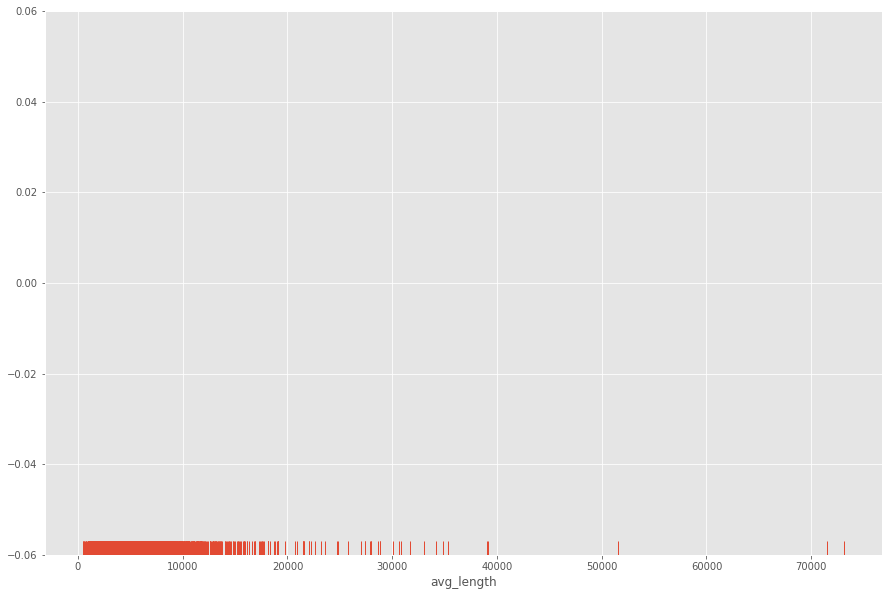

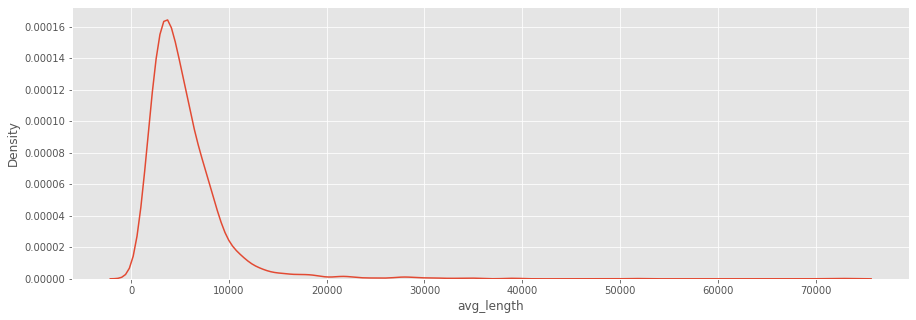

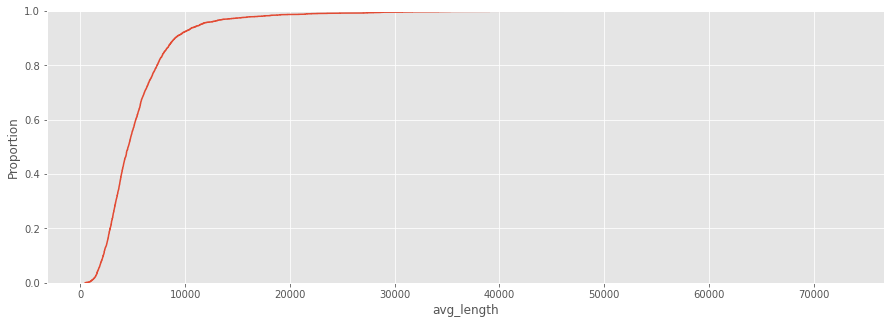

In [165]:
viettan.plot()

### Observations

In [166]:
limit = 320

In [167]:
print(df[df['avg_length'] < limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] < limit]['content'].iloc[0])

Series([], Name: content, dtype: object)
--------------------





IndexError: ignored

In [168]:
limit = 48000

In [169]:
print(df[df['avg_length'] > limit ]['content'])
print("--------------------\n\n\n")
print(df[df['avg_length'] > limit]['content'].iloc[0])

716     Vi·ªát Nam l√† m·ªôt trong nh·ªØng qu·ªëc gia tƒÉng tr∆∞·ªü...
1214    D·ª± ki·∫øn, nƒÉm 2019 l√† nƒÉm th·ª© hai li√™n ti·∫øp ƒë·∫°t...
2664    ƒê√°nh gi√° b·ªï sung k·∫øt qu·∫£ ph√°t tri·ªÉn kinh t·∫ø-x√£...
Name: content, dtype: object
--------------------



Vi·ªát Nam l√† m·ªôt trong nh·ªØng qu·ªëc gia tƒÉng tr∆∞·ªüng cao nh·∫•t trong khu v·ª±c v√† tr√™n th·∫ø gi·ªõi(*)
Theo ch∆∞∆°ng tr√¨nh k·ª≥ h·ªçp, Ch√≠nh ph·ªß ƒë√£ g·ª≠i ƒë·∫øn Qu·ªëc h·ªôi 74 b√°o c√°o v√† t·ªù tr√¨nh v·ªÅ c√°c lƒ©nh v·ª±c, trong ƒë√≥ c√≥ c√°c b√°o c√°o ƒë√°nh gi√° ƒë·∫ßy ƒë·ªß, to√†n di·ªán t√¨nh h√¨nh th·ª±c hi·ªán k·∫ø ho·∫°ch ph√°t tri·ªÉn kinh t·∫ø-x√£ h·ªôi (KT-XH) nƒÉm 2020 v√† 5 nƒÉm 2016-2020; d·ª± ki·∫øn k·∫ø ho·∫°ch ph√°t tri·ªÉn KT-XH nƒÉm 2021 v√† ph∆∞∆°ng h∆∞·ªõng, nhi·ªám v·ª• 5 nƒÉm 2021-2025. Thay m·∫∑t Ch√≠nh ph·ªß, t√¥i xin tr√¢n tr·ªçng b√°o c√°o Qu·ªëc h·ªôi v√† ƒë·ªìng b√†o, c·ª≠ tri c·∫£ n∆∞·ªõc nh·ªØng n·ªôi dung ch·ªß y·∫øu nh∆∞ sau:
I. T√åNH H√åNH TH·ª∞C HI·ªÜN K·∫æ HO·∫†CH P

### Run Preprocessing method

In [170]:
# 750 - 48000
# ...
viettan.preprocess()

Enter < limit:750
Enter > limit:48000


### Save

In [171]:
%cd ..
%cd preprocessed 
%cd 0/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed/0
tinnoichinh.pickle  vnexpress_v2.csv  vnexpress_v2.pickle


In [172]:
viettan.save_preprocess(os.getcwd() + "/tinnoichinh")

In [173]:
os.getcwd()
%cd .. 
%cd .. 
%cd datasets

/content/Vietnamese-Reactionary-Article-Classification-/data/preprocessed
/content/Vietnamese-Reactionary-Article-Classification-/data
/content/Vietnamese-Reactionary-Article-Classification-/data/datasets


# Dataset summary

In [174]:
!ls

0  1  README.md


In [175]:
row = 0
sum_len = 0
df_ls = []
for data in os.listdir('./1/'):
    df = pd.read_csv('./1/' + data)
    df = df.drop(['Unnamed: 0'], axis = 1)
    if 'blue' in df.columns:
        df.rename(columns = {'blue': 'content'}, inplace = True)
    df['label'] = np.ones((df.shape)).astype('int')
    df['label'].astype('category')
    df = df.dropna()
    df['avg_length'] = df['content'].apply(len)

    row += df.shape[0]
    sum_len += np.sum(df['avg_length'])

    df_ls.append(df)


print("Rows: ", row)
print("Length: ", sum_len / row)

print(pd.concat(df_ls).duplicated('content').sum())

Rows:  25558
Length:  2506.2541669927223
500


In [176]:
row = 0
sum_len = 0
sum_ls = []
for data in os.listdir('./0/'):
    try: 
        with open("./0/" + data, "rb") as f:
            df = pickle.load(f)
    except:
        continue

    # df = df.drop(['Unnamed: 0'], axis = 1)
    # if 'blue' in df.columns:
        # df.rename(columns = {'blue': 'content'}, inplace = True)
    df['label'] = np.ones((df.shape)).astype('int')
    df['label'].astype('category')
    df = df.dropna()
    df['avg_length'] = df['content'].apply(len)

    row += df.shape[0]
    
    sum_ls.append(df)


final_df = pd.concat(sum_ls) 



print("Row: ", final_df.shape[0])

print("Avg length: ", np.median(final_df['avg_length']))

temp = final_df[final_df['avg_length'] < 20000]
print(temp.shape)

sns.kdeplot(temp['avg_length'])

ValueError: ignored